In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier, Fourier

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from torch.utils.data import Dataset, Subset


import ipdb


from torch import nn
from torch.utils.data import DataLoader
import torch

import warnings
warnings.filterwarnings('ignore')

import time
from dateutil.relativedelta import relativedelta


plt.rcParams['figure.figsize'] = (20, 10)

# Import data

In [4]:
#flu_id = pd.read_csv("VIW_FID_EPI.csv")
flu_net = pd.read_csv("data\\VIW_FNT-12-6-2024.csv")

#flu_dict = pd.read_csv("VIW_FLU_METADATA.csv")
#flu_surv= pd.read_csv("data\\FluViewPhase5Data\\Weekly_Data_Counts_by_Virus.csv",encoding='cp1252')


In [5]:
flu_surv= pd.read_csv("data\\FluViewPhase5DataNew\\Weekly_Data_Counts_by_Virus.csv",encoding='cp1252')

In [6]:
flu_surv

Influenza-Associated Hospitalizations by Virus Type Number (data downloaded on 12/31/2024)
SEASON                                             WEEK_NUMBER INFLUENZA A INFLUENZA B INFLUENZA A AND B                                            UNKNOWN                                        
2003-04                                            2003-40     0           0           0                                                                  0                                        
                                                   2003-41     1           0           0                                                                  0                                        
                                                   2003-42     0           0           0                                                                  0                                        
                                                   2003-43     0           0           0                                                                  0                                        
...                                                                                                                                                     ...                                        
2023-24                                            2024-37     15          11          0                                                                  0                                        
                                                   2024-38     26          11          0                                                                  0                                        
                                                   2024-39     29          6           1                                                                  0                                        
1. The Influenza Hospitalization Surveillance N... NaN         NaN         NaN         NaN                                                              NaN                                        
2. In all influenza seasons except 2009-10 and ... NaN         NaN         NaN         NaN                                                              NaN                                        

[667 rows x 1 columns]

## Fix flu surv

In [7]:
def fix_flu_surv(flu_surv):
    columns =["SEASON", "WEEK_NUMBER", "INFLUENZA A", "INFLUENZA B", "INFLUENZA A AND B"]
    data = []
    print(columns)

    for i in range(len(flu_surv)-1):
        data.append(flu_surv.iloc[i+1].name)
    data = np.array(data)
    print(data.shape)
    return pd.DataFrame(data=data,columns = columns)

In [8]:
def pdflusurv_to_weektime(df):
    
    indices_ = list(df.index)
   # indices_.sort()
    df = df.loc[indices_]

    indices_new = []
    for i in range(len(indices_)):
        d =  str(indices_[i])[:5]
        if len(str(indices_[i])[5:]) == 1:
            d+='0'
        d+=str(indices_[i])[5:]
       # d= datetime.datetime.strptime(d + '-1', "%Y-%W-%w")
        indices_new.append(d)
    indices_new
    df.index = indices_new
    return df

In [9]:
flu_surv = fix_flu_surv(flu_surv)
flu_surv = flu_surv.set_index('WEEK_NUMBER')
flu_surv["INFLUENZA A"] = flu_surv["INFLUENZA A"].astype('float32')
flu_surv["INFLUENZA B"] = flu_surv["INFLUENZA B"].astype('float32')
flu_surv = flu_surv.fillna(0.0)
flu_surv

['SEASON', 'WEEK_NUMBER', 'INFLUENZA A', 'INFLUENZA B', 'INFLUENZA A AND B']
(666, 5)


SEASON  INFLUENZA A  \
WEEK_NUMBER                                                                   
2003-40                                                2003-04          0.0   
2003-41                                                2003-04          1.0   
2003-42                                                2003-04          0.0   
2003-43                                                2003-04          0.0   
2003-44                                                2003-04          3.0   
...                                                        ...          ...   
2024-37                                                2023-24         15.0   
2024-38                                                2023-24         26.0   
2024-39                                                2023-24         29.0   
nan          1. The Influenza Hospitalization Surveillance ...          0.0   
nan          2. In all influenza seasons except 2009-10 and...          0.0   

             INFLUENZA B INFLUENZA A AND B  
WEEK_NUMBER                                 
2003-40              0.0                 0  
2003-41              0.0                 0  
2003-42              0.0                 0  
2003-43              0.0                 0  
2003-44              0.0                 0  
...                  ...               ...  
2024-37             11.0                 0  
2024-38             11.0                 0  
2024-39              6.0                 1  
nan                  0.0               nan  
nan                  0.0               nan  

[666 rows x 4 columns]

In [10]:
flu_surv = pdflusurv_to_weektime(flu_surv[:'2024-39'])

In [11]:
flu_surv['INF_ALL'] = flu_surv['INFLUENZA A']+flu_surv['INFLUENZA B']

In [12]:
flu_surv.groupby('SEASON')[['INF_ALL']].sum()

INF_ALL
SEASON          
2003-04   1000.0
2004-05    558.0
2005-06   1845.0
2006-07   1231.0
2007-08   3761.0
2008-09   1618.0
2009-10   6998.0
2010-11   6222.0
2011-12   2398.0
2012-13  12349.0
2013-14   9526.0
2014-15  17602.0
2015-16   8713.0
2016-17  17381.0
2017-18  29527.0
2018-19  18386.0
2019-20  19158.0
2020-21    217.0
2021-22   5162.0
2022-23  18125.0
2023-24  25422.0

## Southern Hemisphere Correlations

In [13]:
southern_countries = list(flu_net[flu_net.HEMISPHERE=="SH"]["COUNTRY_CODE"].unique())

In [16]:
def pd_to_weektime(df):
    
    indices_ = list(df.index)
    indices_.sort()
    df = df.loc[indices_]

    indices_new = []
    for i in range(len(indices_)):
        d =  str(indices_[i])[:4]+"-"+str(indices_[i])[4:]
       # d= datetime.datetime.strptime(d + '-1', "%Y-%W-%w")
        indices_new.append(d)
    indices_new
    df.index = indices_new
    return df

In [17]:
def join_countries(country_list):

    
    c = 0
    country_codes = country_list
    for country in country_codes:
        tmp = flu_net[flu_net.COUNTRY_CODE == country][["MMWRYW","INF_ALL"]]
        tmp = tmp.groupby("MMWRYW").sum() #.set_index("MMWRYW")
        tmp = pd_to_weektime(tmp)
        tmp.columns = ["INF_ALL"+country]
        if c == 0:
            df = tmp
            c+=1
        else:
            df = df.join(tmp,on=df.index)

    return df

In [20]:
def create_lags(df,col,num_lags,start,space):
    df_new = df.copy()
    for i in range(num_lags):
        new_col = col+"_lag_"+str(start+i*space)
        df_new[new_col] = df_new[col].shift(start + i*space).fillna(0.0)
    return df_new.drop([col],axis=1)

In [14]:
def make_corrs(country_list):

    corrs_ = []
    for country in country_list:
        df_infall = flu_net[flu_net.COUNTRY_CODE == country][["MMWRYW","INF_ALL"]].groupby("MMWRYW").sum()
        df_infall = pd_to_weektime(df_infall)
        df_infall = df_infall.fillna(0.0)
        df_infall = create_lags(df_infall,'INF_ALL',40,1,1)
        df_infall = flu_surv.join(df_infall,on=flu_surv.index,lsuffix='_USA').loc['2012-01':]
        print(df_infall.corr())
        
        corrs_.append(abs(df_infall.corr()['INF_ALL']))

    return corrs_

In [21]:
corrs_ = make_corrs(southern_countries)

                INFLUENZA A  INFLUENZA B   INF_ALL  INF_ALL_lag_1  \
INFLUENZA A        1.000000     0.417038  0.982539            NaN   
INFLUENZA B        0.417038     1.000000  0.578860            NaN   
INF_ALL            0.982539     0.578860  1.000000            NaN   
INF_ALL_lag_1           NaN          NaN       NaN            NaN   
INF_ALL_lag_2           NaN          NaN       NaN            NaN   
INF_ALL_lag_3           NaN          NaN       NaN            NaN   
INF_ALL_lag_4     -0.093620    -0.022451 -0.088778            NaN   
INF_ALL_lag_5     -0.068134    -0.039289 -0.067789            NaN   
INF_ALL_lag_6     -0.052842     0.061740 -0.039802            NaN   
INF_ALL_lag_7     -0.047745     0.011225 -0.042135            NaN   
INF_ALL_lag_8     -0.115087    -0.010980 -0.106833            NaN   
INF_ALL_lag_9     -0.129330    -0.061444 -0.126856            NaN   
INF_ALL_lag_10    -0.135546     0.005343 -0.123293            NaN   
INF_ALL_lag_11    -0.117591    -0.

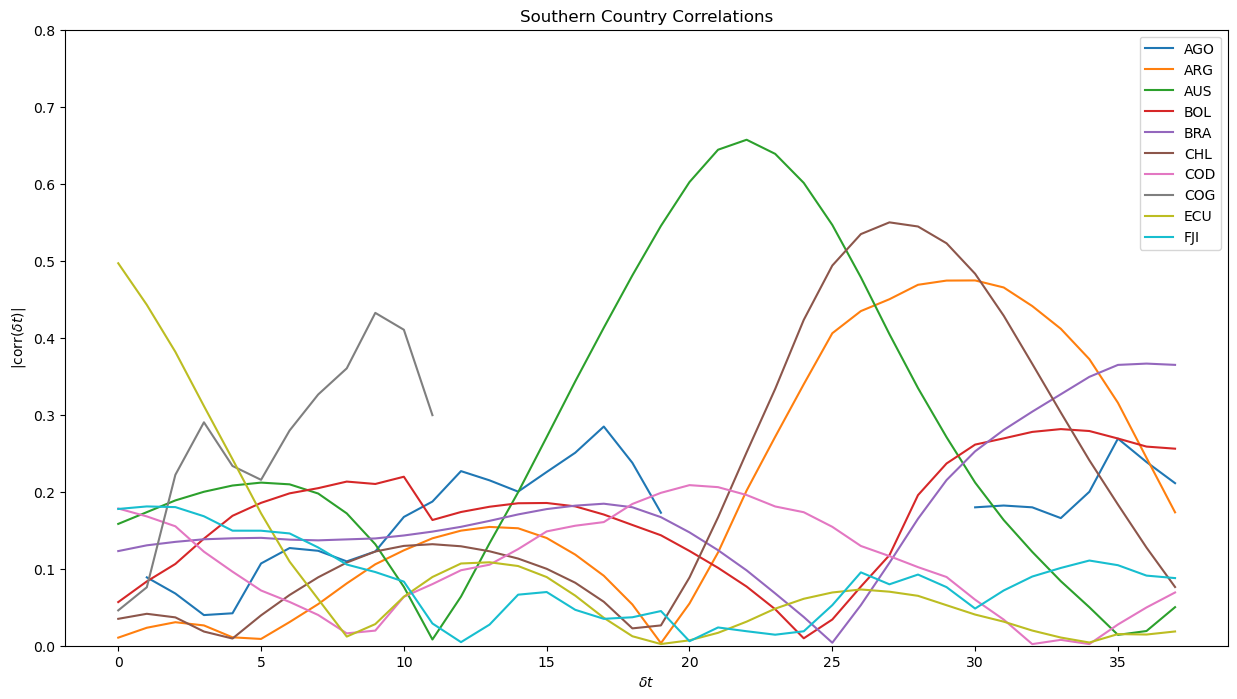

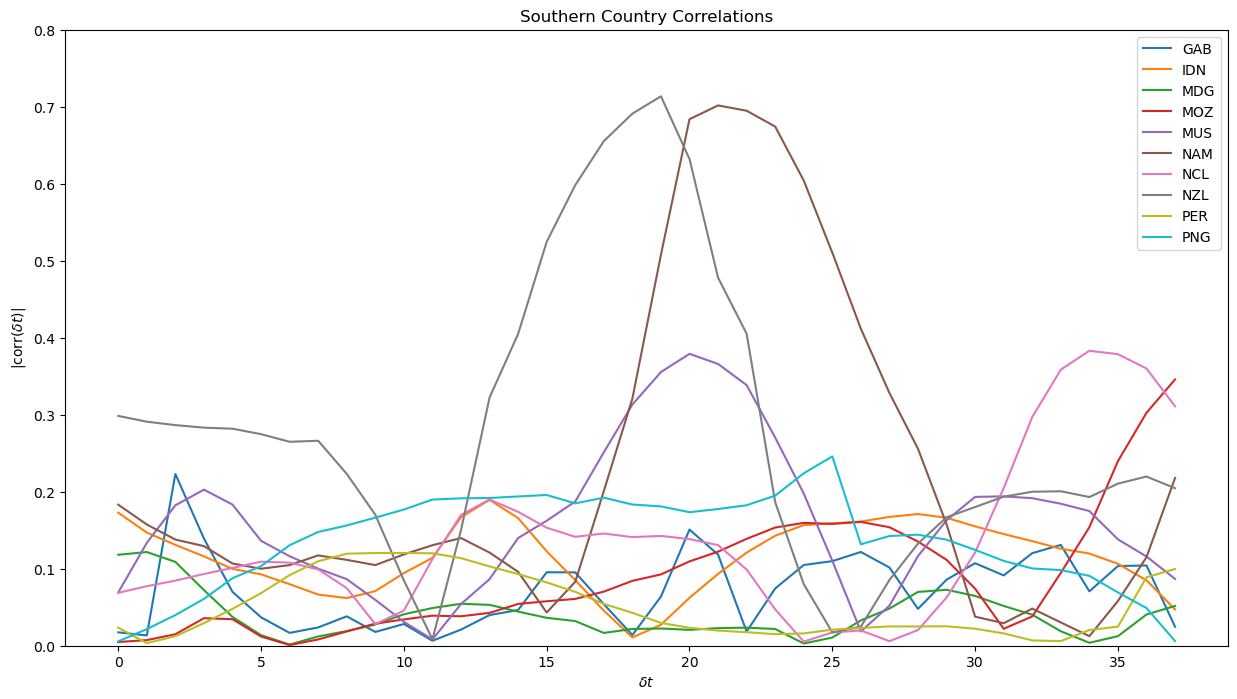

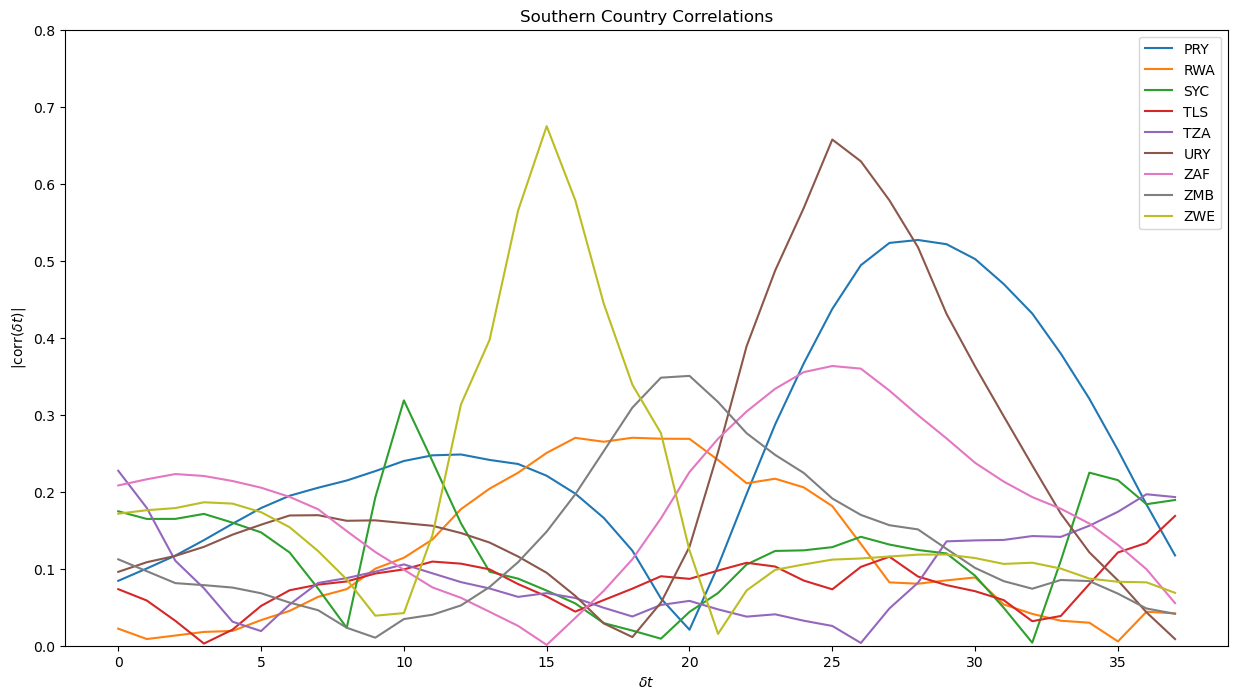

In [23]:
N = len(southern_countries)
batch_num = int(np.floor(N/10))+1
plt.rcParams['figure.figsize'] = (15, 8)

for b in range(batch_num):
    for i in range(b*10,(b+1)*10):
        if i < len(corrs_):

            tmp = corrs_[i]
            tmp = tmp[5:]
            plt.plot(range(0,len(tmp)),tmp,label=southern_countries[i])
            plt.ylim([0,0.8])
   # plt.figure(figsize=(15,8))
    plt.legend(loc='upper right')
    plt.title("Southern Country Correlations")
    plt.ylabel('|corr($\delta t$)|')
    plt.xlabel('$\delta t$')
    plt.show()

In [25]:
# southern countries with reasonable correlations
country_keep = ["AUS","CHL","PRY","ARG","URY"]
corrs_keep = make_corrs(country_keep)

                INFLUENZA A  INFLUENZA B   INF_ALL  INF_ALL_lag_1  \
INFLUENZA A        1.000000     0.417038  0.982539      -0.118037   
INFLUENZA B        0.417038     1.000000  0.578860      -0.148027   
INF_ALL            0.982539     0.578860  1.000000      -0.136201   
INF_ALL_lag_1     -0.118037    -0.148027 -0.136201       1.000000   
INF_ALL_lag_2     -0.127522    -0.155082 -0.146155       0.961356   
INF_ALL_lag_3     -0.139477    -0.161526 -0.158199       0.890317   
INF_ALL_lag_4     -0.154496    -0.170258 -0.173462       0.788127   
INF_ALL_lag_5     -0.169037    -0.181053 -0.188718       0.689134   
INF_ALL_lag_6     -0.179684    -0.189227 -0.199943       0.600670   
INF_ALL_lag_7     -0.187126    -0.196233 -0.208054       0.521277   
INF_ALL_lag_8     -0.190154    -0.201414 -0.211831       0.443795   
INF_ALL_lag_9     -0.187394    -0.202556 -0.209588       0.367065   
INF_ALL_lag_10    -0.174760    -0.199673 -0.197664       0.293870   
INF_ALL_lag_11    -0.148204    -0.

In [35]:
np.argmax(corrs_keep[0][4:])

23

(0.0, 37.0)

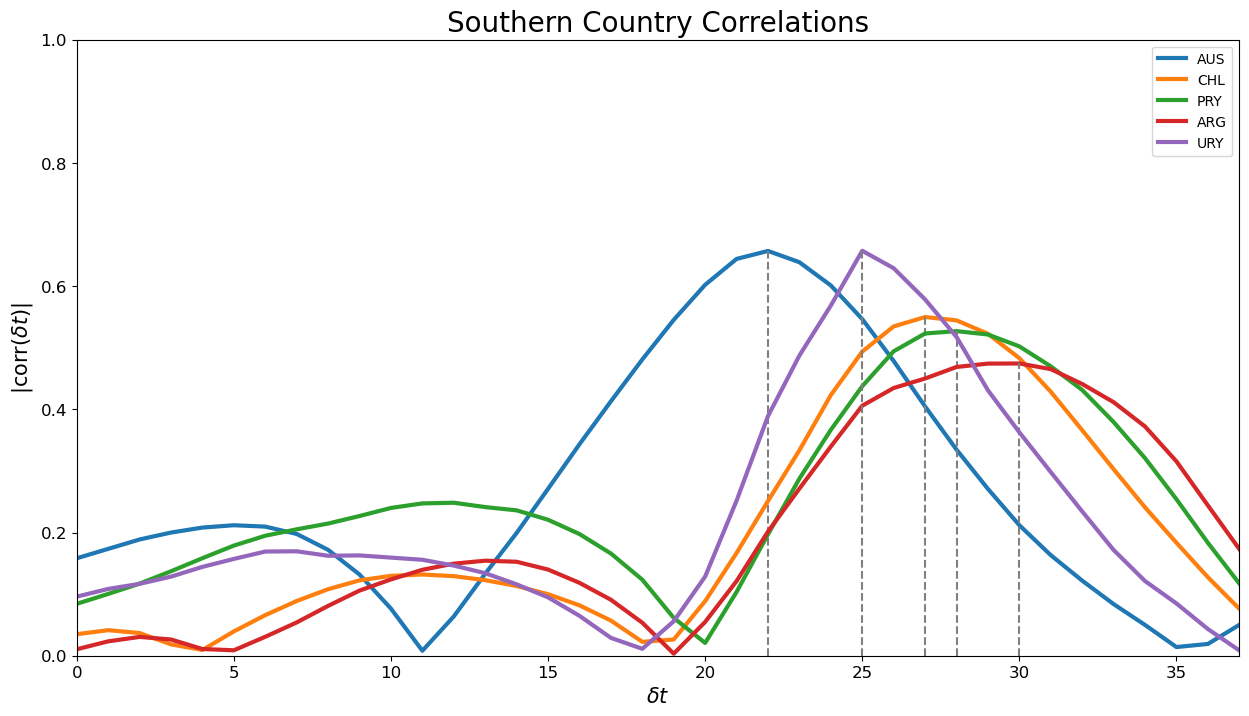

In [51]:
plt.rcParams['figure.figsize'] = (15, 8)
for i in range(len(corrs_keep)):
    tmp = corrs_keep[i]
    tmp = tmp[5:]
    plt.plot(range(0,len(tmp)),tmp,label=country_keep[i],linewidth=3)
    plt.ylim([0,1])
    max_loc = np.argmax(corrs_keep[i][5:])
    ymax_  = np.max(corrs_keep[i][5:])
    plt.axvline(x=max_loc,color='gray',ymin=0,ymax=ymax_,linestyle='dashed')
plt.legend(loc='upper right')
plt.title("Southern Country Correlations",fontsize=20)
plt.ylabel('|corr($\delta t$)|',fontsize=15)
plt.xlabel('$\delta t$',fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim([0,37])

## Create country keep and fix flu_surv index

In [52]:
country_keep = ["AUS","CHL","PRY","ARG","URY"]
df_in = join_countries(country_keep)

<AxesSubplot:>

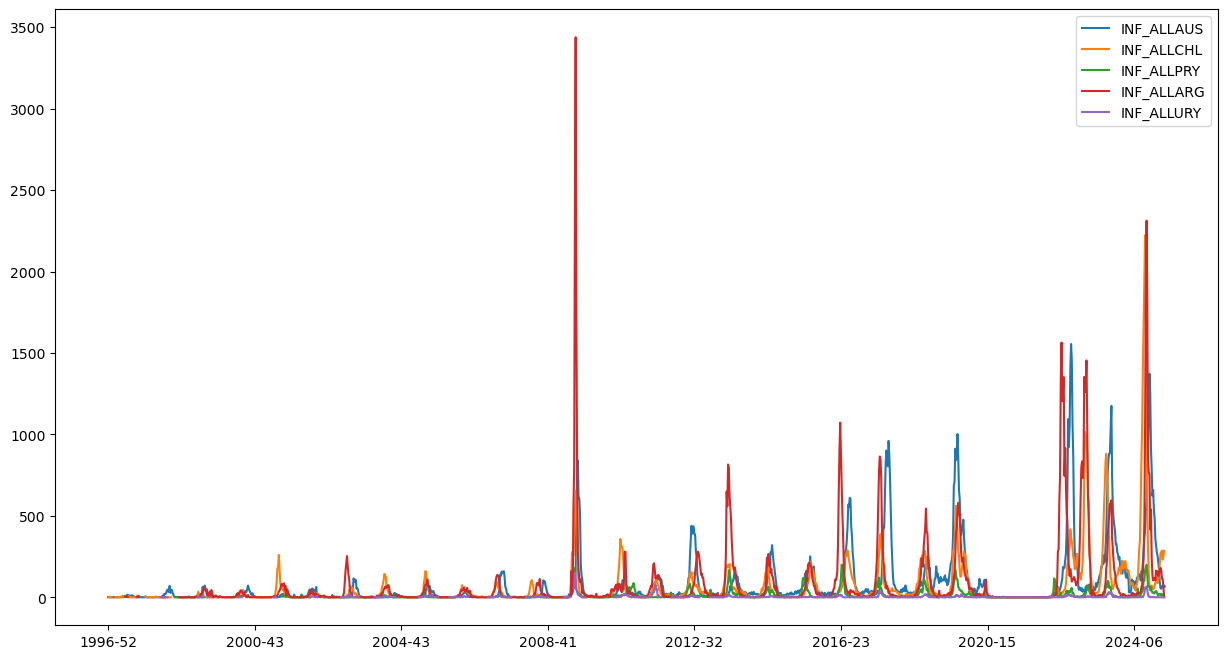

In [53]:
df_in.plot(kind='line')

In [54]:
df_in.loc['2022-41':'2023-10'] = np.zeros(shape=(len(df_in.loc['2022-41':'2023-10'] ),5))

In [55]:
df_in.loc['2022-41':'2023-10'] 

INF_ALLAUS  INF_ALLCHL  INF_ALLPRY  INF_ALLARG  INF_ALLURY
2022-41         0.0         0.0         0.0         0.0         0.0
2022-42         0.0         0.0         0.0         0.0         0.0
2022-43         0.0         0.0         0.0         0.0         0.0
2022-44         0.0         0.0         0.0         0.0         0.0
2022-45         0.0         0.0         0.0         0.0         0.0
2022-46         0.0         0.0         0.0         0.0         0.0
2022-47         0.0         0.0         0.0         0.0         0.0
2022-48         0.0         0.0         0.0         0.0         0.0
2022-49         0.0         0.0         0.0         0.0         0.0
2022-50         0.0         0.0         0.0         0.0         0.0
2022-51         0.0         0.0         0.0         0.0         0.0
2022-52         0.0         0.0         0.0         0.0         0.0
2023-01         0.0         0.0         0.0         0.0         0.0
2023-02         0.0         0.0         0.0         0.0         0.0
2023-03         0.0         0.0         0.0         0.0         0.0
2023-04         0.0         0.0         0.0         0.0         0.0
2023-05         0.0         0.0         0.0         0.0         0.0
2023-06         0.0         0.0         0.0         0.0         0.0
2023-07         0.0         0.0         0.0         0.0         0.0
2023-08         0.0         0.0         0.0         0.0         0.0
2023-09         0.0         0.0         0.0         0.0         0.0
2023-10         0.0         0.0         0.0         0.0         0.0

In [56]:
df_in = df_in.loc['2010-01-01':]

In [57]:
# normalizations

df_norm = df_in.copy()
df_norm[df_norm.columns] = MinMaxScaler().fit_transform(df_norm)
df_norm = df_norm.fillna(0.0)

usa_infall_norm = flu_surv[['INF_ALL']].copy()
norms = MinMaxScaler().fit_transform(pd.DataFrame(data=usa_infall_norm["INF_ALL"].values,columns = ["INF_ALL"]))
usa_infall_norm["INF_ALL"] = norms
usa_infall_norm = usa_infall_norm.fillna(0.0)

In [58]:
df_norm

INF_ALLAUS  INF_ALLCHL  INF_ALLPRY  INF_ALLARG  INF_ALLURY
2010-02    0.000643    0.000000       0.000    0.009083         0.0
2010-03    0.000643    0.000000       0.000    0.002595         0.0
2010-04    0.000000    0.000000       0.010    0.000433         0.0
2010-05    0.000643    0.000000       0.000    0.001730         0.0
2010-06    0.000643    0.000000       0.000    0.000000         0.0
...             ...         ...         ...         ...         ...
2024-44    0.043087    0.129105       0.095    0.049740         0.0
2024-45    0.041158    0.103914       0.080    0.048875         0.0
2024-46    0.048875    0.111561       0.035    0.026817         0.0
2024-47    0.041801    0.128205       0.025    0.000000         0.0
2024-48    0.042444    0.000000       0.000    0.000000         0.0

[777 rows x 5 columns]

In [59]:
df = df_norm.join(usa_infall_norm,on=df_norm.index)
df = df.fillna(0.0)

In [60]:
usa_infall_norm = df['INF_ALL']

In [61]:
df['INF_ALL_shift'] = df['INF_ALL'].shift(26)

<AxesSubplot:>

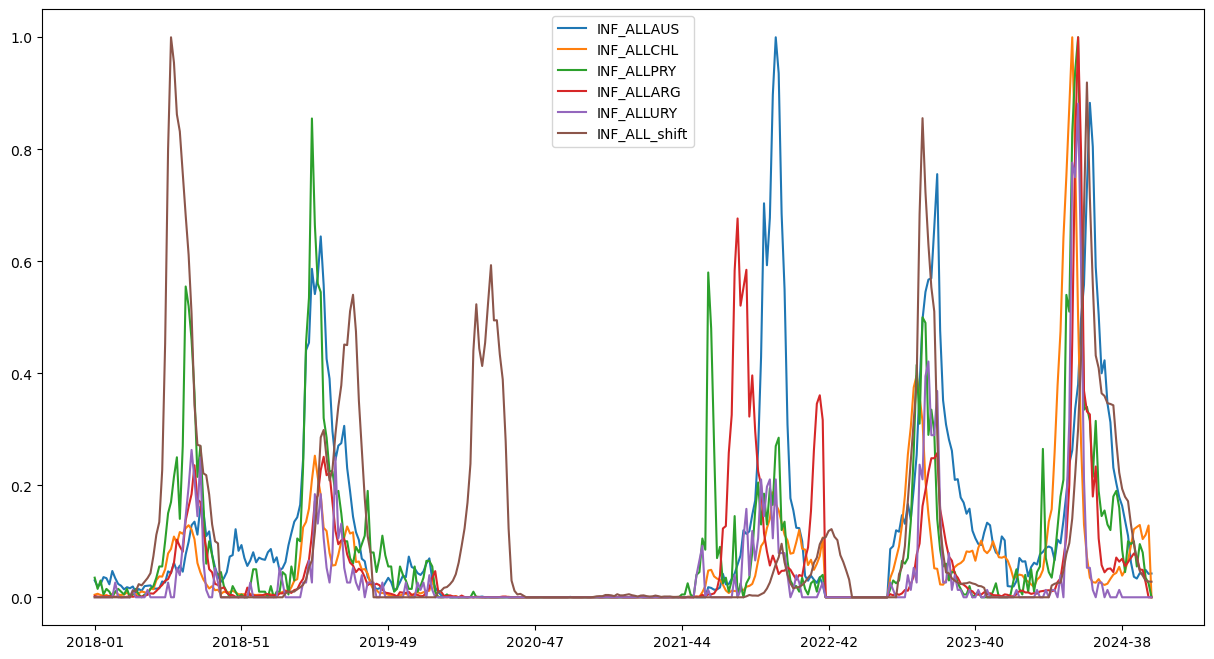

In [62]:
df.loc['2018-01':].drop('INF_ALL',axis=1).plot(kind='line')

## Create Season

In [63]:
ind_ = df.index.to_list()
season_list = []
for elem in ind_:
    week = int(elem.split('-')[1])
    if week >= 40:
        season_list.append(1)
    elif week <=18:
        season_list.append(1)
    else:
        season_list.append(0)

In [64]:
df['season'] = season_list

In [65]:
df['season'] = df['season'].shift(26)

In [66]:
df

INF_ALLAUS  INF_ALLCHL  INF_ALLPRY  INF_ALLARG  INF_ALLURY   INF_ALL  \
2010-02    0.000643    0.000000       0.000    0.009083         0.0  0.018650   
2010-03    0.000643    0.000000       0.000    0.002595         0.0  0.018989   
2010-04    0.000000    0.000000       0.010    0.000433         0.0  0.012547   
2010-05    0.000643    0.000000       0.000    0.001730         0.0  0.017294   
2010-06    0.000643    0.000000       0.000    0.000000         0.0  0.012547   
...             ...         ...         ...         ...         ...       ...   
2024-44    0.043087    0.129105       0.095    0.049740         0.0  0.000000   
2024-45    0.041158    0.103914       0.080    0.048875         0.0  0.000000   
2024-46    0.048875    0.111561       0.035    0.026817         0.0  0.000000   
2024-47    0.041801    0.128205       0.025    0.000000         0.0  0.000000   
2024-48    0.042444    0.000000       0.000    0.000000         0.0  0.000000   

         INF_ALL_shift  season  
2010-02            NaN     NaN  
2010-03            NaN     NaN  
2010-04            NaN     NaN  
2010-05            NaN     NaN  
2010-06            NaN     NaN  
...                ...     ...  
2024-44       0.047135     1.0  
2024-45       0.038657     0.0  
2024-46       0.030180     0.0  
2024-47       0.028145     0.0  
2024-48       0.027806     0.0  

[777 rows x 8 columns]

In [67]:
df = df.drop(['INF_ALL','INF_ALL_shift'],axis=1)

In [68]:
df.loc['2020-14':'2021-44']= np.zeros(shape=(len(df.loc['2020-14':'2021-44'] ),6))

<AxesSubplot:>

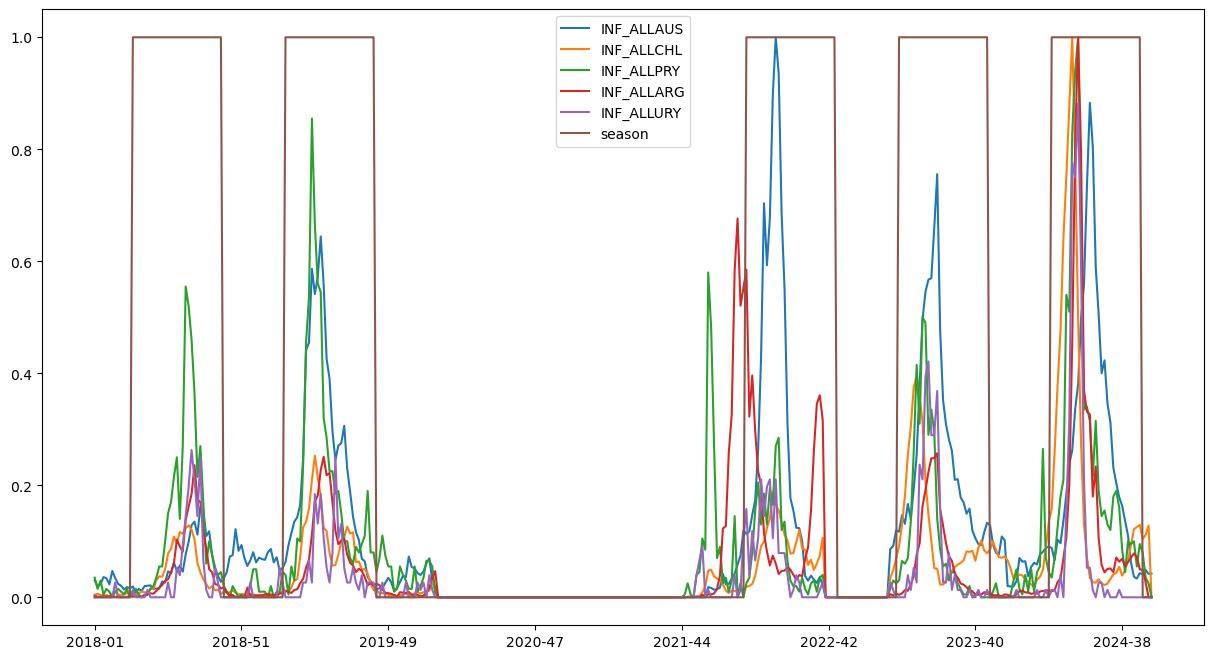

In [69]:
df.loc['2018-01':].plot(kind='line')

In [71]:
df = df.join(usa_infall_norm,on=df.index)
df = df.fillna(0.0)

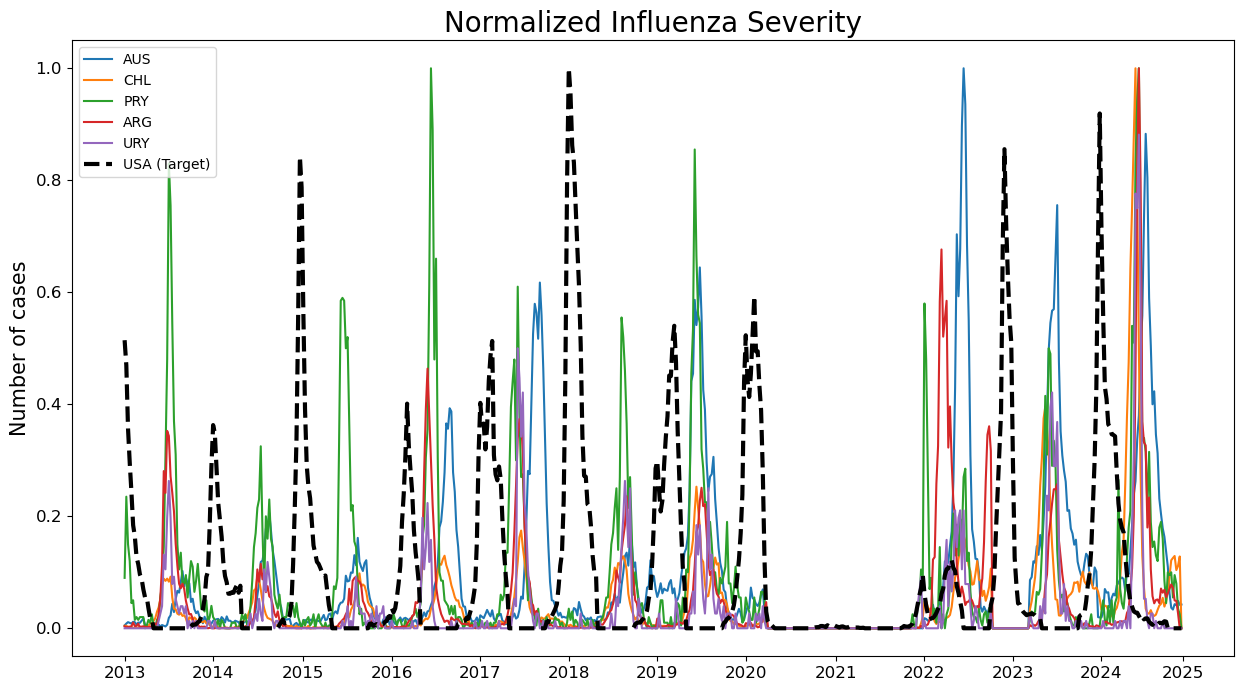

In [81]:
plt.plot(df['INF_ALLAUS'].loc['2013-01':],label='AUS')
plt.plot(df['INF_ALLCHL'].loc['2013-01':],label='CHL')
plt.plot(df['INF_ALLPRY'].loc['2013-01':],label='PRY')
plt.plot(df['INF_ALLARG'].loc['2013-01':],label='ARG')
plt.plot(df['INF_ALLURY'].loc['2013-01':],label='URY')
plt.plot(df['INF_ALL'].loc['2013-01':],label='USA (Target)',color='black',linewidth=3,linestyle='dashed')

x_ticks=['2013-01','2014-01','2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01','2024-01','2025-01']
labels = ['2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','2024','2025']
plt.xticks(ticks = x_ticks, labels=labels,rotation=0,size=12)
plt.legend(loc="upper left")
plt.title('Normalized Influenza Severity',fontsize=20)
plt.yticks(size=12)
plt.ylabel('Number of cases',fontsize=15)
#plt.xlabel('Date')
plt.show()

# Tamiflu Comparisons

In [23]:
import sys
sys.path.append('C:\\Users\\christopher.johnson\\Documents\\')
import ctj_tools as ros
import pyodbc

In [191]:
#psswd = input()
conn_string = 'Driver={ODBC Driver 17 for SQL Server}; Server=roproductionsql.database.windows.net; TrustedConnection=no; Database=ROAR; Uid={christopher.johnson@redoaksourcing.com}; Pwd={'+psswd+'}; Authentication=ActiveDirectoryPassword; '
conn = pyodbc.connect(conn_string)

In [192]:
# cvs target
gcn_list = ['67153',
'28020',
'39632',
'28020',
'61252',
'67151',
'39681',
'39632',
'39683',
'93375',
'39683',
'67070',
'93385',
'67071',
'67076',
'93375',
'98980',
'98981',
'29729',
'73441']
gcn_str = ros.get_gcn_str_for_sql(gcn_list)

            
#dispense_df = pd.read_sql_query('''select MonthStartDate, concat(year,'-', weekofyear) "WeekYear",sum("order QTY") UnitVolume, MonthEndDate, WeekStartDate, WeekEndDate,  p.GCN, p.NDC from CAHMonthlyServiceLevel as d
#                                    left join (select distinct GCN, NDC from Product) as p
#                                    on d.NDC = p.NDC
#                                    left join (select distinct Date, WeekStartDate, WeekEndDate, MonthStartDate, MonthEndDate, Year, WeekofYear from Calendar) as c
#                                    on d.Date = c.Date
#                                    where p.GCN in '''+gcn_str+'''
#                                    group by  p.GCN, p.NDC, weekofyear, WeekStartDate, WeekEndDate, MonthStartDate, MonthEndDate, year
#                                    order by MonthStartDate, MonthEndDate, WeekStartDate, WeekEndDate, c.weekofyear, c.year, p.GCN, p.NDC''',conn)

dispense_df = pd.read_sql_query('''select Date, sum("order QTY"*accunet) UnitVolume,  p.GCN, p.NDC from CAHMonthlyServiceLevel as d
                                    left join (select distinct GCN, NDC, accunet from Product) as p
                                    on d.NDC = p.NDC
                                    where p.GCN in '''+gcn_str+'''
                                    group by p.NDC, p.GCN, Date
                                    order by Date, p.GCN, p.NDC''',conn)

In [121]:
calendar_df = pd.read_sql_query('''select distinct MonthStartDate, concat(year,'-', weekofyear) "WeekYear", MonthEndDate, WeekStartDate, WeekEndDate from calendar''',conn) 

In [138]:
calendar_df= calendar_df[(calendar_df.MonthStartDate >= pd.to_datetime('2014-01-01')) & (calendar_df.MonthStartDate <= pd.to_datetime('2024-12-01'))]

In [134]:
calendar_df['WeekDelta'] = calendar_df['WeekEndDate'] - calendar_df['WeekStartDate']
calendar_df[calendar_df.MonthEndDate < calendar_df.WeekEndDate]

MonthStartDate WeekYear MonthEndDate WeekStartDate WeekEndDate WeekDelta
11       2017-02-01   2017-9   2017-02-28    2017-02-26  2017-03-04    6 days
16       2022-07-01  2022-32   2022-07-31    2022-07-31  2022-08-06    6 days
40       2019-12-01  2019-53   2019-12-31    2019-12-29  2020-01-04    6 days
55       2029-11-01  2029-48   2029-11-30    2029-11-25  2029-12-01    6 days
60       2017-05-01  2017-22   2017-05-31    2017-05-28  2017-06-03    6 days
...             ...      ...          ...           ...         ...       ...
2501     2015-07-01  2015-31   2015-07-31    2015-07-26  2015-08-01    6 days
2505     2019-06-01  2019-27   2019-06-30    2019-06-30  2019-07-06    6 days
2548     2026-12-01  2026-53   2026-12-31    2026-12-27  2027-01-02    6 days
2553     2026-09-01  2026-40   2026-09-30    2026-09-27  2026-10-03    6 days
2562     2016-10-01  2016-45   2016-10-31    2016-10-30  2016-11-05    6 days

[175 rows x 6 columns]

In [194]:
dispense_df = dispense_df.groupby(['Date','GCN'])['UnitVolume'].sum().reset_index()

In [215]:
target = dispense_df[dispense_df.GCN == '73441']
target

Date    GCN  UnitVolume
10    2017-01-01  73441    641290.0
25    2017-02-01  73441    977500.0
40    2017-03-01  73441    726000.0
55    2017-04-01  73441    157450.0
70    2017-05-01  73441     40280.0
...          ...    ...         ...
1441  2024-07-01  73441     94970.0
1457  2024-08-01  73441     49290.0
1473  2024-09-01  73441     67560.0
1489  2024-10-01  73441    104400.0
1505  2024-11-01  73441    247990.0

[95 rows x 3 columns]

<AxesSubplot:>

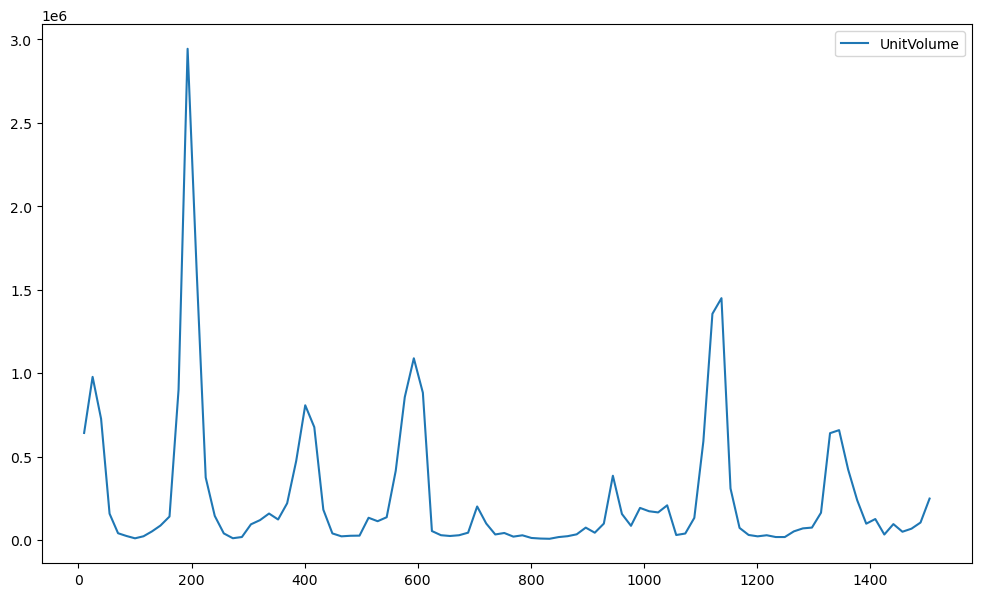

In [196]:
target.plot(kind='line')

In [231]:
season_sum_usa = [29527.0,18386.0,19158.0,217.0,5162.0,18125.0,13107.0]

In [236]:
target_susp = dispense_df[dispense_df.GCN == '29729']

In [244]:
season_start = pd.to_datetime('2017-09-01')
season_end = pd.to_datetime('2018-04-01')

season_sum, season_sum_susp = [],[]
for i in range(7):
    date_start = season_start + relativedelta(months=12*i)
    date_end = season_end + relativedelta(months=12*i)
    sum_ = target[(target.Date >= date_start) & (target.Date <= date_end)]['UnitVolume'].sum()
    season_sum.append(sum_)
    sum_ = target_susp[(target_susp.Date >= date_start) & (target_susp.Date <= date_end)]['UnitVolume'].sum()
    season_sum_susp.append(sum_)
    
tamiflu_df = pd.DataFrame(data = zip(['17-18','18-19','19-20','20-21','21-22','22-23','23-24'],season_sum,season_sum_susp,season_sum_usa),columns = ['Season','Tamiflu','Susp','Hosp'])
tamiflu_norm_df = tamiflu_df.copy()
tamiflu_norm_df['Tamiflu'] = tamiflu_df['Tamiflu']/tamiflu_df['Tamiflu'].max()
tamiflu_norm_df['Hosp'] = tamiflu_df['Hosp']/tamiflu_df['Hosp'].max()
tamiflu_norm_df['Susp'] = tamiflu_df['Susp']/tamiflu_df['Susp'].max()

<AxesSubplot:>

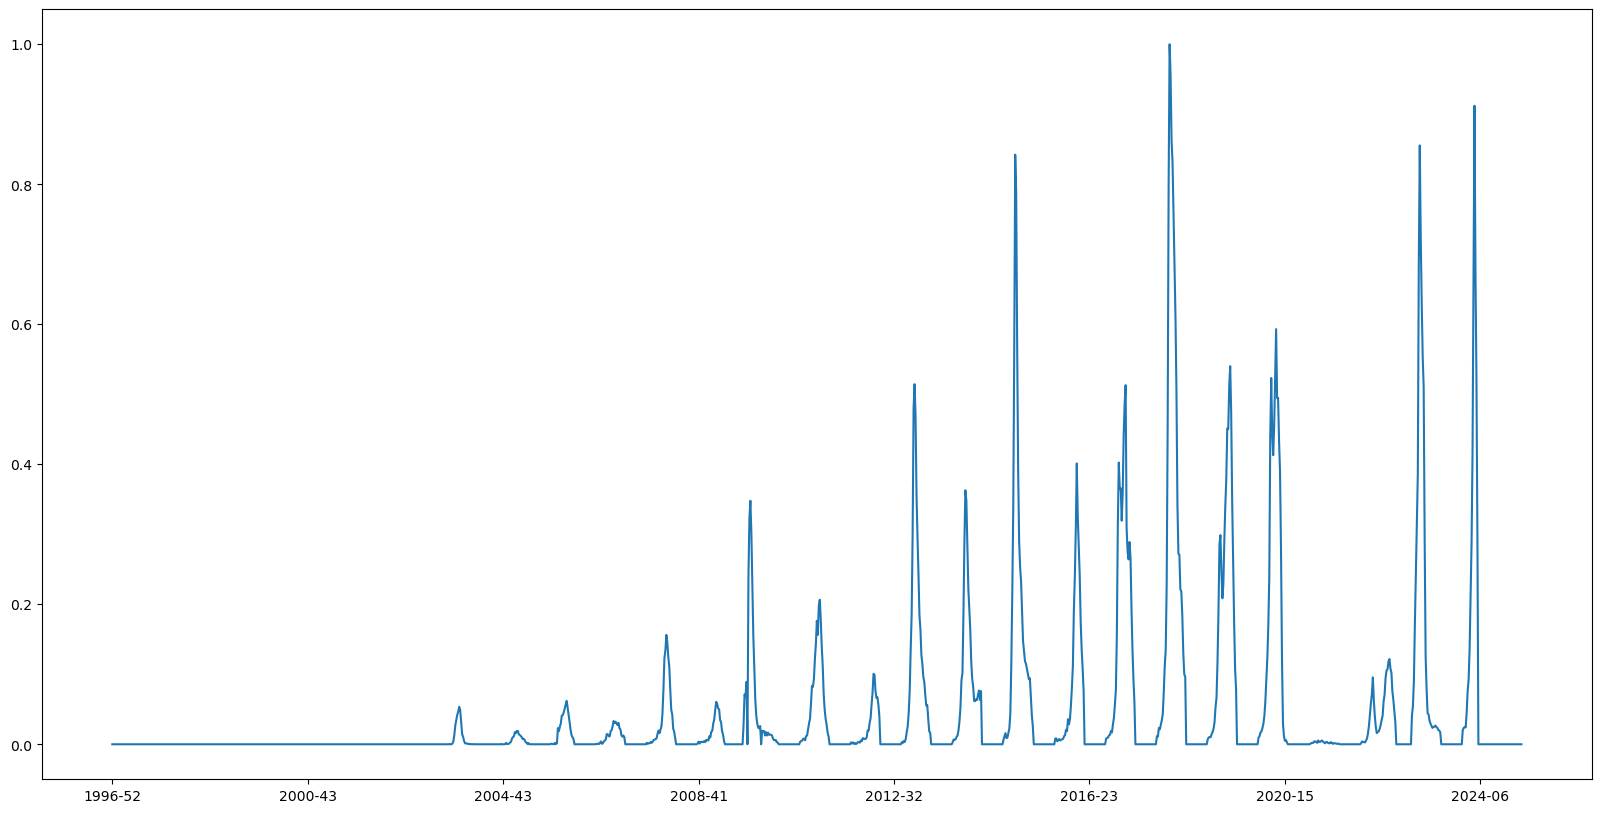

In [225]:
usa_infall_norm.plot(kind='line')

In [246]:
tamiflu_df[['Tamiflu','Hosp','Susp']].corr()

Tamiflu      Hosp      Susp
Tamiflu  1.000000  0.969803  0.952383
Hosp     0.969803  1.000000  0.967282
Susp     0.952383  0.967282  1.000000

<AxesSubplot:xlabel='Season'>

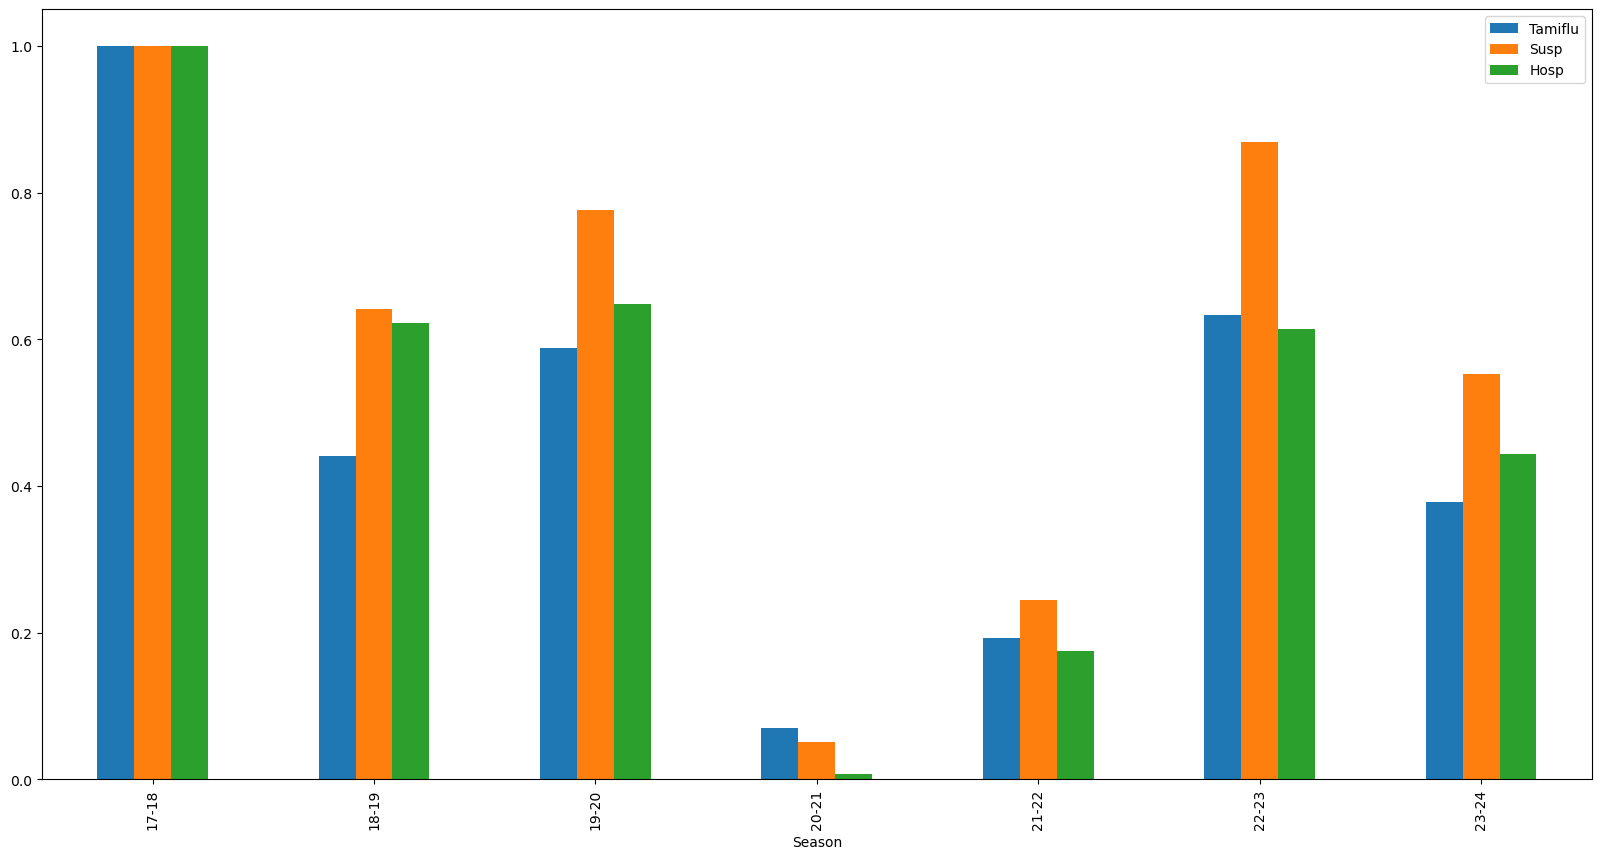

In [245]:
tamiflu_norm_df.set_index('Season').plot(kind='bar')

<AxesSubplot:xlabel='Hosp', ylabel='Susp'>

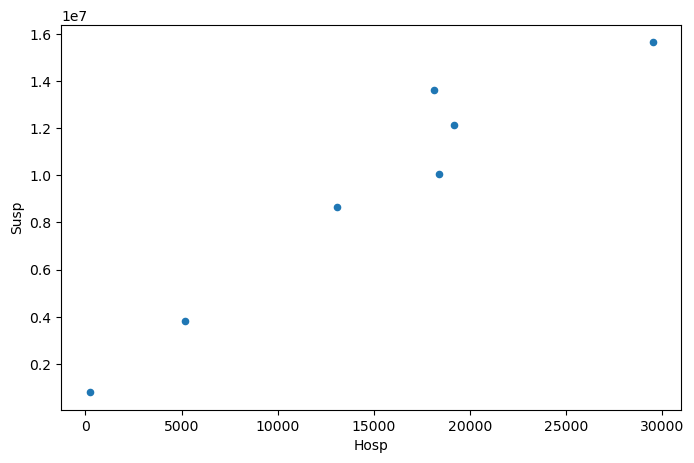

In [247]:
tamiflu_df[['Hosp','Susp']].plot(kind='scatter',x='Hosp',y='Susp',figsize=(8,5))

<AxesSubplot:xlabel='Hosp', ylabel='Tamiflu'>

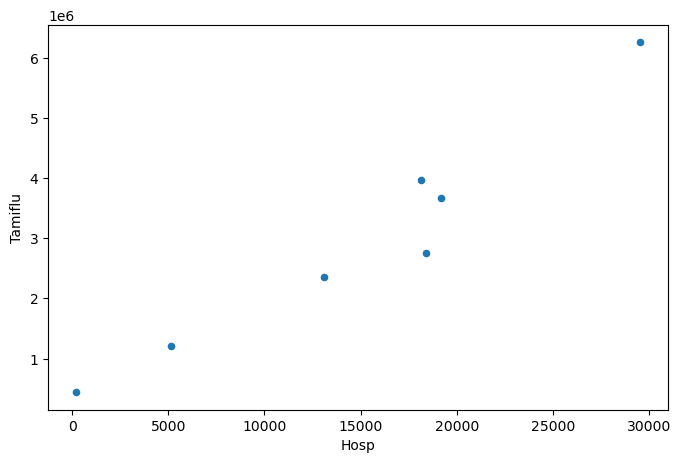

In [249]:
tamiflu_df[['Hosp','Tamiflu']].plot(kind='scatter',x='Hosp',y='Tamiflu',figsize=(8,5))

## Do fits

In [256]:
from sklearn.linear_model import LinearRegression

In [263]:
X = tamiflu_df[['Hosp']]
X['HospSquared'] = X['Hosp']**2
X['Const'] = [1]*len(X)

### Tablet 75mg

In [275]:
y = tamiflu_df['Tamiflu']
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X,y)
tablet_pred = pd.DataFrame(data = lin_reg.predict(X), index = X['Hosp'])
lin_reg.coef_

array([1.05405622e+02, 3.03049014e-03, 4.79126449e+05])

In [280]:
y = tamiflu_df['Tamiflu']
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X.drop('HospSquared',axis=1),y)
tablet_pred_lin = pd.DataFrame(data = lin_reg.predict(X.drop('HospSquared',axis=1)), index = X['Hosp'])
lin_reg.coef_

array([   191.65012659, 112541.65349635])

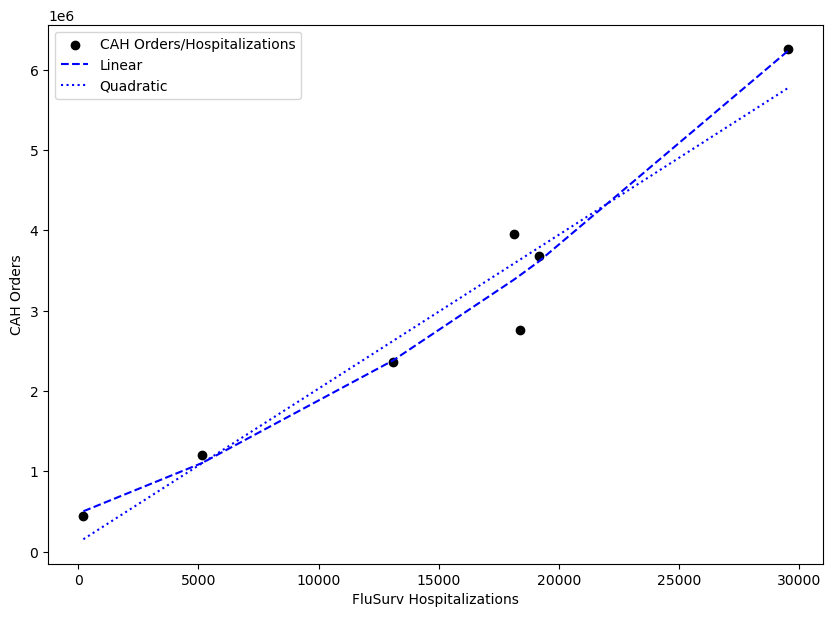

In [289]:
plt.figure(figsize= (10,7))
plt.scatter(tamiflu_df['Hosp'],tamiflu_df['Tamiflu'],color = 'black',label='CAH Orders/Hospitalizations')
plt.plot(tablet_pred.sort_index(),color='blue',linestyle='--',label='Linear')
plt.plot(tablet_pred_lin.sort_index(),linestyle=':',color='blue',label='Quadratic')
plt.ylabel('CAH Orders')
plt.xlabel('FluSurv Hospitalizations')
plt.legend(loc='upper left')

### Susp

In [276]:
y = tamiflu_df['Susp']
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X,y)
susp_pred = pd.DataFrame(data = lin_reg.predict(X), index = X['Hosp'])
lin_reg.coef_

array([ 7.66893889e+02, -8.34038011e-03,  3.94105882e+05])

In [290]:
y = tamiflu_df['Susp']
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X.drop('HospSquared',axis=1),y)
susp_pred_lin = pd.DataFrame(data = lin_reg.predict(X.drop('HospSquared',axis=1)), index = X['Hosp'])
lin_reg.coef_

array([5.29535602e+02, 1.40300424e+06])

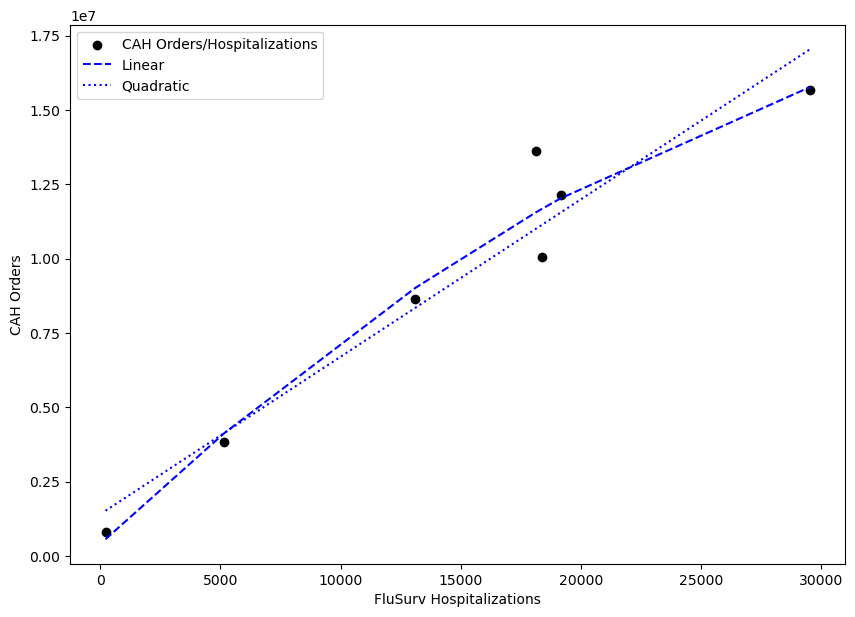

In [292]:
plt.figure(figsize= (10,7))
plt.scatter(tamiflu_df['Hosp'],tamiflu_df['Susp'],color = 'black',label='CAH Orders/Hospitalizations')
plt.plot(susp_pred.sort_index(),color='blue',linestyle='--',label='Linear')
plt.plot(susp_pred_lin.sort_index(),linestyle=':',color='blue',label='Quadratic')
plt.ylabel('CAH Orders')
plt.xlabel('FluSurv Hospitalizations')
plt.legend(loc='upper left')

# New Model Improvements

In [117]:
##################### training executable ########################################
def train(dataloader, model,device, loss_fn, optimizer,noise):
    
    # train function gets called inside function train_model
    # set up to be general but loss_fn and optimizer are hardcoded in train_model

    model.train()
    cnt = 0
    total_loss = 0
    for batches in dataloader:
            x,y = batches
         
            x=x.to_dense().to(device)
            y= y.to(device).float()
            pred=  model(x.float())
            if noise == True:
               randos = []
               for i in range(y.shape[0]):
                   rando = np.random.normal(loc=0.0, scale=.2, size=None)
                   randos.append(rando)
               randos = torch.tensor(randos)
               y = (1+rando)*y
          
            loss = loss_fn(pred,y)
           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            loss,current = loss.item(), cnt * len(x) # can't remember why I wanted "current"
          
            cnt+=1
            total_loss+= loss
    return float(total_loss)


############### test executable ##############################################
def test(dataloader, model, device,loss_fn):
    
    #same thing as train but doesn't run the optimizer or a backward

    num_batches = len(dataloader)
    
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to_dense().to(device), y.to(device)
            pred = model(X.float())
            
            test_loss+=loss_fn(pred,y.float()).item()
           
    return test_loss

def test_max(dataloader, model, device):
    
    #same thing as train but doesn't run the optimizer or a backward

    num_batches = len(dataloader)
    
    model.eval()
    pred_list, y_list = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to_dense().to(device), y.to(device)
            pred = model(X.float())
            pred_list.append(pred)
            y_list.append(y.float())
            
    test_loss = abs(np.max(pred_list) - np.max(y_list)).item()
    loc = abs(np.argmax(pred_list) - np.argmax(y_list)).item()
    return test_loss, loc

################ this is the full training executable, uses "train" and "test" ##############################################
################ user be warned I change this almost daily trying to figure out better features ##########################################

def train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast):

# This is the function for minimizing a model for a dataset, saves best val and train model in PATH and outputs two tuples of losses for train/val


# PATH = destination for saving/loading the model
# model, device = model class instance , resources
# loss_fn = loss class instance
# batched_sequence = Dataset instance
# learn_rate = (float) learn_rate 
# num_epochs = (int) number of epochs
# kill = (int) if loss does not decrease for "kill" number of epochs end the routine
# batch_size_ = (int) batch size
# t_beg = (int) index in DATES to start fit
# t_end = (int) index in DATES to end fit
# noise = (bool) true or false to introduce noise in train
# forecast = (int) number of indices to include in validation beyond t_end

    #sparse_tensor = Dataset_(Y_df,dataframe_list) 
    #batched_sequence = SequenceDataset(sparse_tensor) # this is hard coded in but could get rid of this by just feeding batched_sequence as input
    time0 = time.perf_counter()
    
    with open(PATH[:-4]+".log","w") as f:
        f.write("starting log for model: "+PATH+"\n")
        loss_values = []
        pred = []
        train_ = Subset(batched_sequence,range(t_beg,t_end)) 
        train_dataloader = DataLoader(train_, batch_size=batch_size_, shuffle=False)

        test_ = Subset(batched_sequence,range(t_end,t_end+forecast))
        test_dataloader = DataLoader(test_, batch_size=1, shuffle=False)




        #loss_fn = nn.MSELoss()
        #loss_fn = nn.L1Loss()
        #loss_fn = elastic_net_loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
        losses, losses_test, peak_match = [],[],[]
        c, epoch, loss_cut= 0,0, 1e99 # init
        d=c
        g = c
        loss_cut_t = loss_cut
        loss_cut_val = loss_cut

        while epoch < num_epochs:
        #for epoch in range(num_epochs):
            print("epoch",epoch,c,d)
            time1 = time.perf_counter()
            
            d+=1
            g+=1
            if d % 10 == 0 and d!=0:
                learn_rate*=0.1
                model.load_state_dict(torch.load(PATH[:-4]+"_train.pth"))
                optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
                
                print("Shrinking learning rate to",str(learn_rate))
                f.write("Shrinking learning rate to "+str(learn_rate)+"\n")
                if learn_rate < 1e-6:
                    print("Learning rate getting small")
                    f.write("Learning rate getting small\n")
                    break
    #         optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
            loss = train(train_dataloader,model,device,loss_fn,optimizer,noise)
            losses.append(loss)
        
            #loss_test = test(test_dataloader,model,device,loss_fn)
            loss_test, loc_test = test_max(test_dataloader,model,device)
            peak_match.append(loss_test)
            loss_test = np.sqrt(loss_test**2+(0.1*loc_test)**2+(0.1*loss)**2)

            losses_test.append(loss_test)
            time2 = time.perf_counter()
        
            print("Train loss:",loss,"Val loss:",loss_test,"Time:",time2-time1)
            f.write("Train loss: "+str(loss)+" Val loss: "+str(loss_test)+" Time: "+str(time2-time1)+"\n")

            if epoch == 0:
                loss_cut = loss_test
            if epoch > 0:
                if loss_cut < loss_test:
                    c+=1
                else:
                    c = 0
                    torch.save(model.state_dict(), PATH)
                loss_cut = loss_test
            


            
            if loss < loss_cut_t:
                loss_cut_t = loss
                torch.save(model.state_dict(), PATH[:-4]+"_train.pth")
                d = 0
            if loss_test < loss_cut_val and epoch > 15:
                loss_cut_val = loss_test
                torch.save(model.state_dict(), PATH[:-4]+"_val.pth")
                g = 0
        # test(train_dataloader,model,loss_fn)
        
            if c == kill and epoch > 30:
                print("reached val limit, early stopping now")
                break
            epoch +=1
                
        
        print("Complete")
        print("Total time:",time2-time0)
        f.write("Complete\n Total time: "+str(time2-time0))
    return losses,losses_test, peak_match

In [118]:
class Dataset_(Dataset):
    
    def __init__(self,Y_df,df,seq,shift):
    
            
        df = df.to_numpy()
        y = Y_df.to_numpy()
        data_tmp = []
        for i in range(df.shape[0]):
            batch = []
            for j in range(seq):

                ind = i+j - shift

                if ind <0:
                    batch.append(np.zeros(shape=df[ind].shape))

                else:
                    batch.append(df[ind])
            data_tmp.append(batch)

        data_tmp = np.array(data_tmp)

        data = []
        print(y.shape)
        for j in range(df.shape[0]):
            
            x = torch.from_numpy(np.asarray(data_tmp[j]))
            Y = torch.tensor(y[j])
            data.append((x,Y))
        
        self.data = data
        
    def __len__(self):

        return len(self.data)
    def __getitem__(self,i):
            
            #return item at i
            
        return self.data[i]

In [119]:
def create_prediction(PATH,NN,device,batched_sequence,Y_mean,Y_std,norm_bool):
    
    # PATH = location of model
    # NN = model class instance
    # batched_sequence= data class instance
    # Y_mean = mean of target for undoing standard scalar transform
    # Y_std = standard deviation of target for undoing standard scalar transform
    # norm_bool = True/False if you want to return Normalized/Raw transformation
    
    NN.load_state_dict(torch.load(PATH))
    NN.eval()
    #sparse_tensor = Dataset_(Y_df,dataframe_list)
    #batched_sequence = SequenceDataset(sparse_tensor)
    #sub_ = Subset(batched_sequence,range(0,136))
    sub_ = batched_sequence
    datas = DataLoader(sub_, batch_size=1, shuffle=False)
    all_,ys = [],[]
    for x,y in datas:
        x=x.to_dense().to(device)
        pred= NN(x.float())
    
        all_.append(pred[0].cpu().detach().numpy())
        ys.append(y.to_dense().numpy())
    all_ =  np.array(all_)
    
    if norm_bool==False: # undo standard scalar
        tmp = np.ones(shape = all_[:,0].shape,dtype=float)*Y_mean[0]
    
        all_ = all_[:,0] * Y_std[0]+tmp

    return all_

In [99]:
def read_logs(filename):
    
    f = open(filename,'r')
    lines = f.readlines()
    f.close()
    train_loss, val_loss = [],[]
    for line in lines:
        if line.count('Train loss')>0:
            line_split = line.split(' ')
            train_loss.append(float(line_split[2]))
            val_loss.append(float(line_split[5]))
    return train_loss, val_loss


In [120]:
index = list(df.index)

data_in = Dataset_(df["INF_ALL"],df.drop(['INF_ALL','season'],axis=1),26,26+20)

(777,)


In [330]:
df.columns

Index(['INF_ALLAUS', 'INF_ALLCHL', 'INF_ALLPRY', 'INF_ALLARG', 'INF_ALLURY',
       'season', 'INF_ALL'],
      dtype='object')

## LSTM

In [121]:
class lstm(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm, self).__init__()
        
        
        
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.lstm(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [195]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 15.962856239596684 Val loss: 1.7903661678825054 Time: 0.7239879000007932
epoch 1 0 0
Train loss: 14.352280812848422 Val loss: 1.643227616121648 Time: 0.7327323000008619
epoch 2 0 0
Train loss: 14.286208482474962 Val loss: 1.6368866365949017 Time: 0.6971281000005547
epoch 3 0 0
Train loss: 13.960427330933655 Val loss: 1.6050022135434878 Time: 0.6935952000003454
epoch 4 0 0
Train loss: 13.278035708611469 Val loss: 1.5351297536006856 Time: 0.6820757999994385
epoch 5 0 0
Train loss: 11.929443819035214 Val loss: 1.3994169189724006 Time: 0.6751777999998012
epoch 6 0 0
Train loss: 10.158346866028225 Val loss: 1.214241875442843 Time: 0.6715160999992804
epoch 7 0 0
Train loss: 8.282413327304416 Val loss: 1.0188176682177952 Time: 0.6825150000004214
epoch 8 0 0
Train loss: 7.382713878384838 Val loss: 0.92211297745046 Time: 0.7958433000003424
epoch 9 0 0
Train loss: 6.918064712524448 Val loss: 0.8715455210646053 Time: 1.5145625999994081
epoch 10 0 0
Train loss: 6.7500446302

In [100]:
loss_t, loss_v = read_logs('models\\lstm_new_22-23.log')

In [101]:
loss_v

[1.7903661678825054,
 1.643227616121648,
 1.6368866365949017,
 1.6050022135434878,
 1.5351297536006856,
 1.3994169189724006,
 1.214241875442843,
 1.0188176682177952,
 0.92211297745046,
 0.8715455210646053,
 0.8498538255089086,
 0.841025568865514,
 0.8267147835746945,
 0.8248313321029862,
 0.8138884206922044,
 0.8003128305297639,
 0.7872592211167246,
 0.7737826691499369,
 0.7734578074303544,
 0.7575148337777732,
 0.7500795493236926,
 0.7401136123000258,
 0.7407130174566364,
 0.7261874168104517,
 0.7302849958207834,
 0.7251654695203402,
 0.6933430161311106,
 0.6842437694359363,
 0.680453492600875,
 0.6859083097847918,
 0.6565868259755487,
 0.6317424460689494,
 0.6363276361510648,
 0.62649589012992,
 0.5787009160645602,
 0.5689053630576054,
 0.5574456711985998,
 0.542743120317174,
 0.5584446851347046,
 0.5235270370498096,
 0.5325634251671786,
 0.5207192879554179,
 0.5110228479199771,
 0.4790848687652153,
 0.47241919048407804,
 0.47265155039428125,
 0.4729966340642478,
 0.4462835607291203,

Text(0.5, 1.0, 'Training Log')

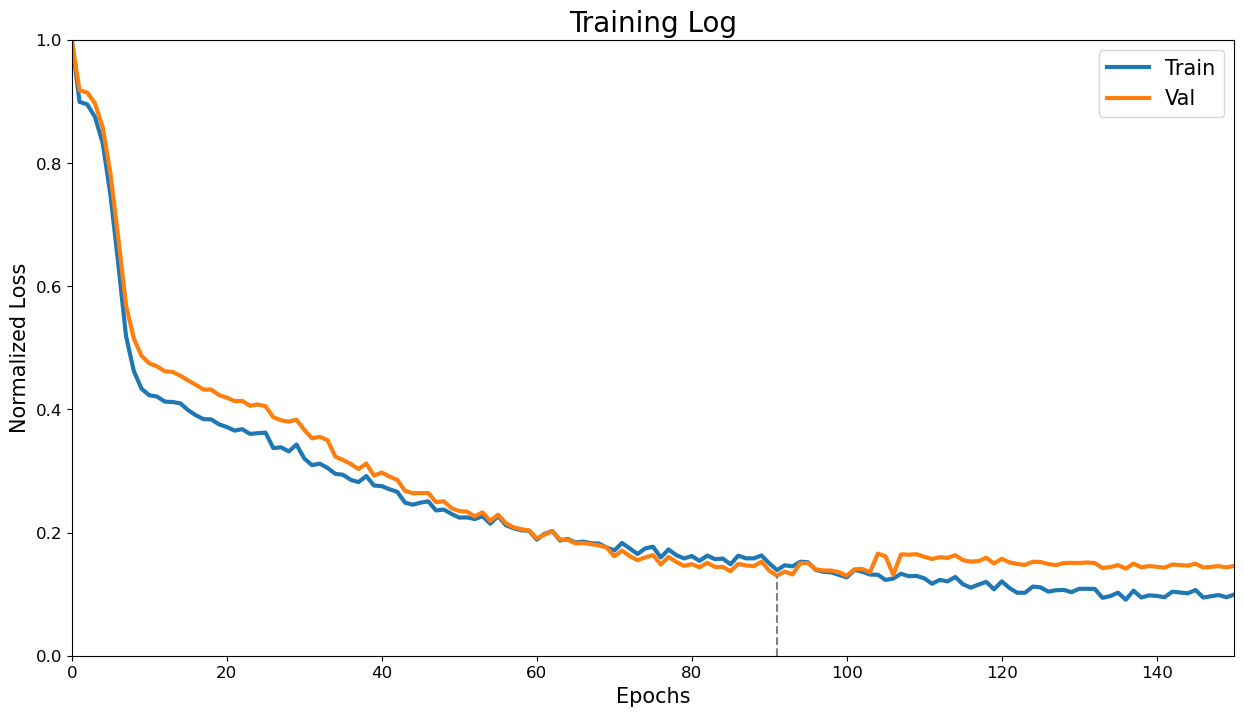

In [115]:
plt.plot(loss_t/np.max(loss_t),linewidth=3,label='Train')
plt.plot(loss_v/np.max(loss_v),linewidth=3,label='Val')
plt.legend(loc='upper right',fontsize=15)
plt.axvline(x=np.argmin(loss_v),ymin=0,ymax=np.min(loss_v)/np.max(loss_v),linestyle='dashed',color='gray')
plt.ylim([0,1])
plt.xlim([0,150])
plt.ylabel('Normalized Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Training Log',fontsize=20)

In [191]:
def plot_model(end_date):
    MODEL_PATH = PATH[:-4]+"_val.pth"
    pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

    plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
    plot_df["pred"] = pred
    plt.rcParams['figure.figsize'] = (12, 7)

    plt.plot(plot_df["INF_ALL"].loc['2015-01':end_date],linewidth=3,label='flu hospitilizations')
    #plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
    plt.plot(plot_df["pred"].loc['2015-01':end_date],linestyle="dashed",color='red',label='included')
    #plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
    plt.legend(loc='upper left')
    plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
    plt.title(model.__class__.__name__+' Forecast',size =20)
    plt.ylabel('Number of hospitalizations in the US',size =15)
    plt.xlabel('Date',size=15)

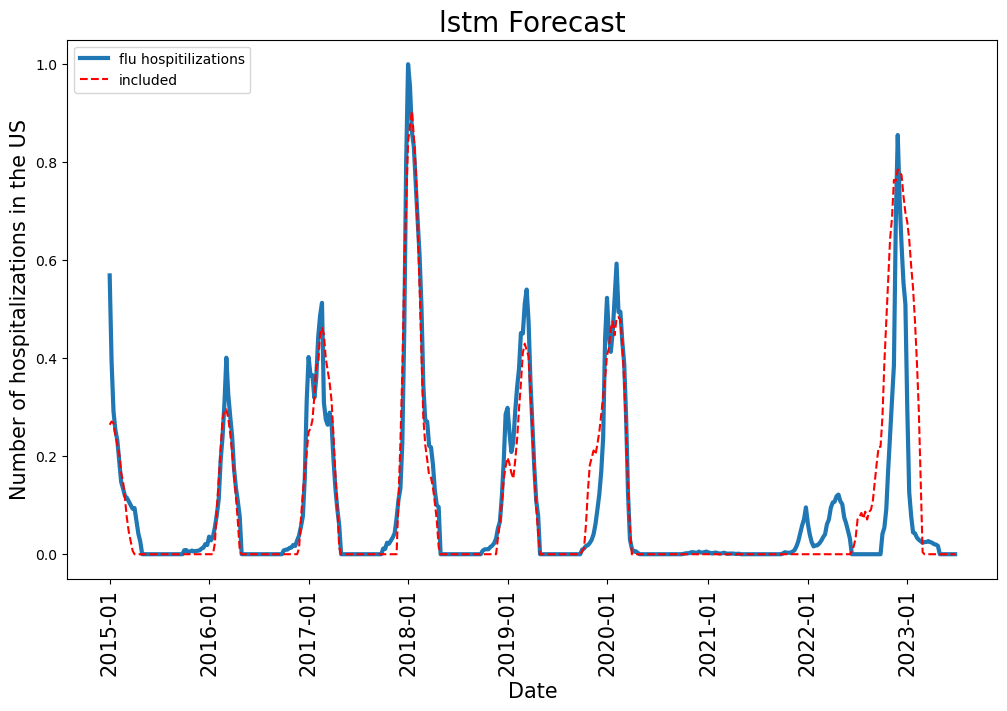

In [209]:
plot_model('2023-26')

### 23-24

In [374]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_23-24.pth'
LOAD_PATH =   'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))


loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 100
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [375]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 4.037287934061201 Val loss: 0.4468034144500511 Time: 1.0886575999902561
epoch 1 0 0
Train loss: 5.03192187295673 Val loss: 0.538216601683548 Time: 1.0221644999983255
epoch 2 1 1
Train loss: 4.5351426316064725 Val loss: 0.4833625025387861 Time: 0.925728700007312
epoch 3 0 2
Train loss: 3.889480539379803 Val loss: 0.4230622591954746 Time: 0.8286513000202831
epoch 4 0 0
Train loss: 3.947297185514234 Val loss: 0.4316426835837258 Time: 0.8056949000165332
epoch 5 1 1
Train loss: 3.8190734914264377 Val loss: 0.41688959671064585 Time: 1.4170245999994222
epoch 6 0 0
Train loss: 3.5842854129639967 Val loss: 0.3909916441470213 Time: 1.57782400000724
epoch 7 0 0
Train loss: 3.5145200363429936 Val loss: 0.3834472916381289 Time: 0.7919362999964505
epoch 8 0 0
Train loss: 3.486537078406812 Val loss: 0.37941330031150705 Time: 0.8351436999801081
epoch 9 0 0
Train loss: 3.444864870451802 Val loss: 0.3701395356203104 Time: 0.7769912999938242
epoch 10 0 0
Train loss: 3.353708874683

(0.0, 1.0)

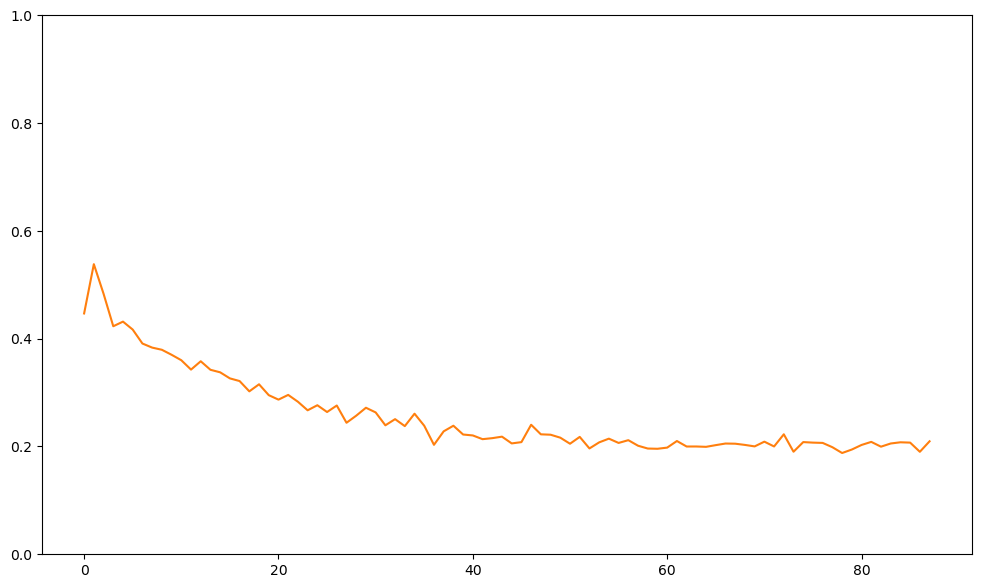

In [376]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

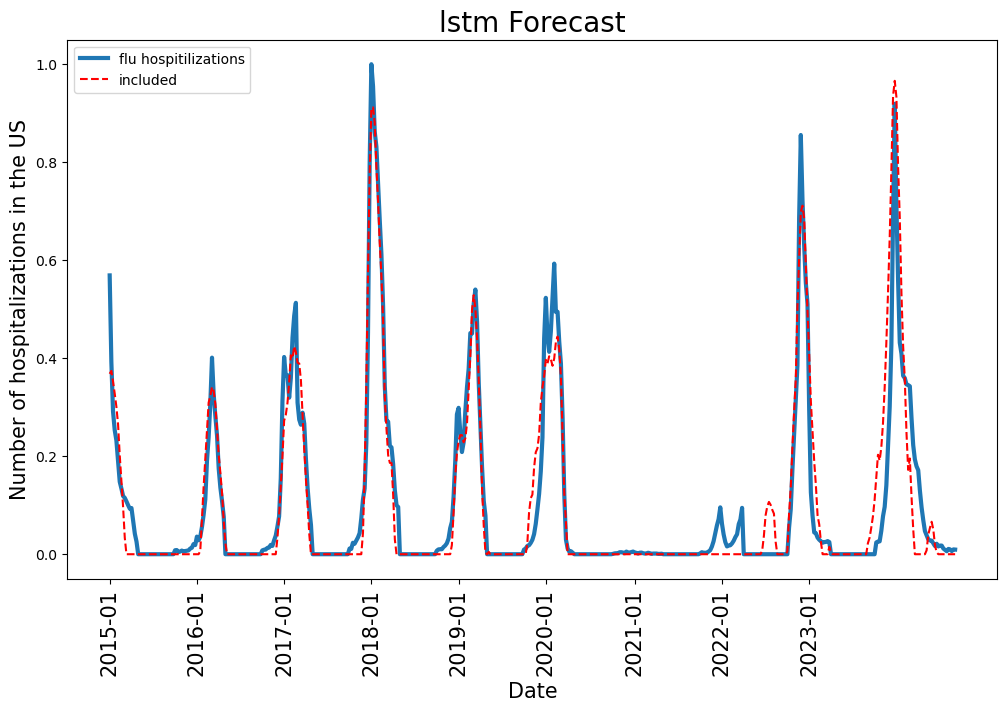

In [377]:
plot_model('2024-36')

## LSTM1

In [122]:
class lstm1(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm1, self).__init__()
        
        
        
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            #nn.Dropout(0.05),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):
        
        logits, _ = self.lstm(x.permute(0,2,1))       
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [210]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 350
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(42)

In [202]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.453722006127919 Val loss: 1.8147144248153508 Time: 0.4639515999988362
epoch 1 0 0
Train loss: 12.83926446027883 Val loss: 1.5906209099303303 Time: 0.5193548000006558
epoch 2 0 0
Train loss: 11.421030926298279 Val loss: 1.3919595404946596 Time: 0.5362834000006842
epoch 3 0 0
Train loss: 9.783732431270444 Val loss: 1.1848035474673981 Time: 0.432252000000517
epoch 4 0 0
Train loss: 8.238538820419805 Val loss: 1.0266998666768086 Time: 0.44029130000126315
epoch 5 0 0
Train loss: 7.198232363633082 Val loss: 0.9159801766729031 Time: 0.44058809999842197
epoch 6 0 0
Train loss: 6.612672965254916 Val loss: 0.8490197852847846 Time: 0.4664436000002752
epoch 7 0 0
Train loss: 6.294559845065982 Val loss: 0.8098441920789226 Time: 0.44116199999916716
epoch 8 0 0
Train loss: 6.107731360824751 Val loss: 0.785660945944857 Time: 0.4212377000003471
epoch 9 0 0
Train loss: 5.98085659834922 Val loss: 0.7689002502545202 Time: 0.4472151000009035
epoch 10 0 0
Train loss: 5.87557806954

(0.0, 1.0)

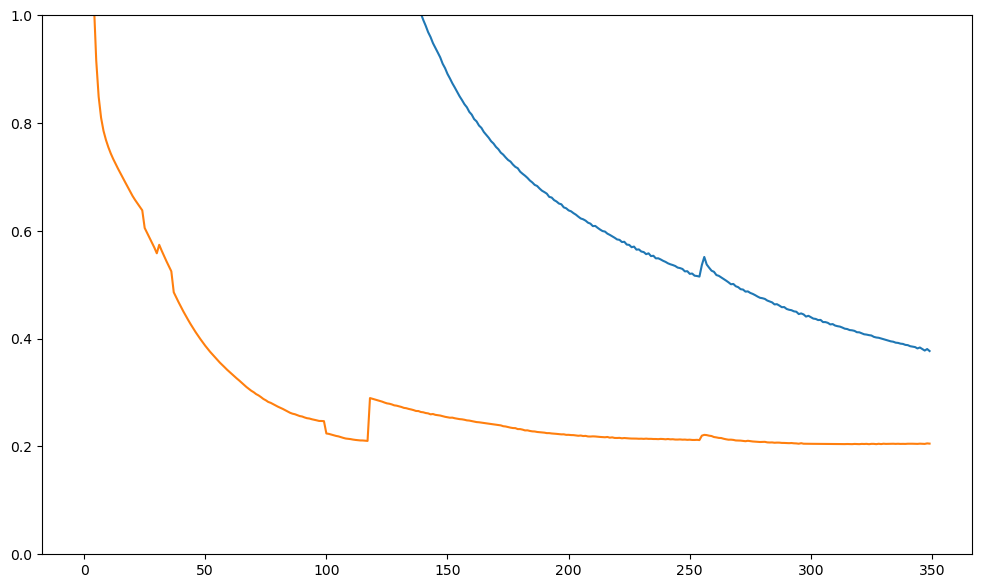

In [203]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

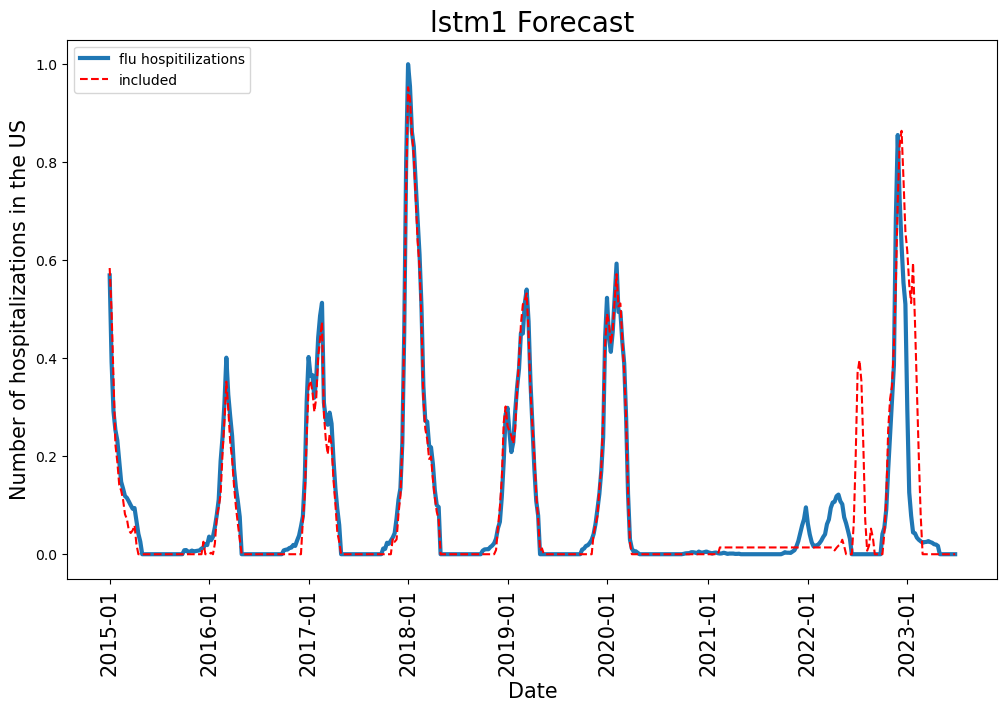

In [211]:
plot_model('2023-26')

### 23-24

In [396]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_23-24.pth'
LOAD_PATH =   'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
#print(LOAD_PATH)
#model.load_state_dict(torch.load(LOAD_PATH))


loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [397]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 16.52716639583665 Val loss: 1.835603122817809 Time: 0.6039565000100993
epoch 1 0 0
Train loss: 14.505015331437193 Val loss: 1.6308123342751084 Time: 0.5073932000086643
epoch 2 0 0
Train loss: 12.527442597112945 Val loss: 1.4274965190809954 Time: 0.5180944000021555
epoch 3 0 0
Train loss: 10.515139017596994 Val loss: 1.218185745860151 Time: 0.5224472999980208
epoch 4 0 0
Train loss: 8.932229185563525 Val loss: 1.0500158683495056 Time: 0.525952199997846
epoch 5 0 0
Train loss: 7.938614929892346 Val loss: 0.9400483811798116 Time: 0.49331019999226555
epoch 6 0 0
Train loss: 7.3858152652577544 Val loss: 0.8749028663344198 Time: 0.5350117000052705
epoch 7 0 0
Train loss: 7.056087178768829 Val loss: 0.8341601098027844 Time: 0.5510189999768045
epoch 8 0 0
Train loss: 6.823270852421771 Val loss: 0.8053271572542344 Time: 0.9701923999818973
epoch 9 0 0
Train loss: 6.636099429432607 Val loss: 0.7825734402231299 Time: 1.0268049000005703
epoch 10 0 0
Train loss: 6.47211285715

(0.0, 1.0)

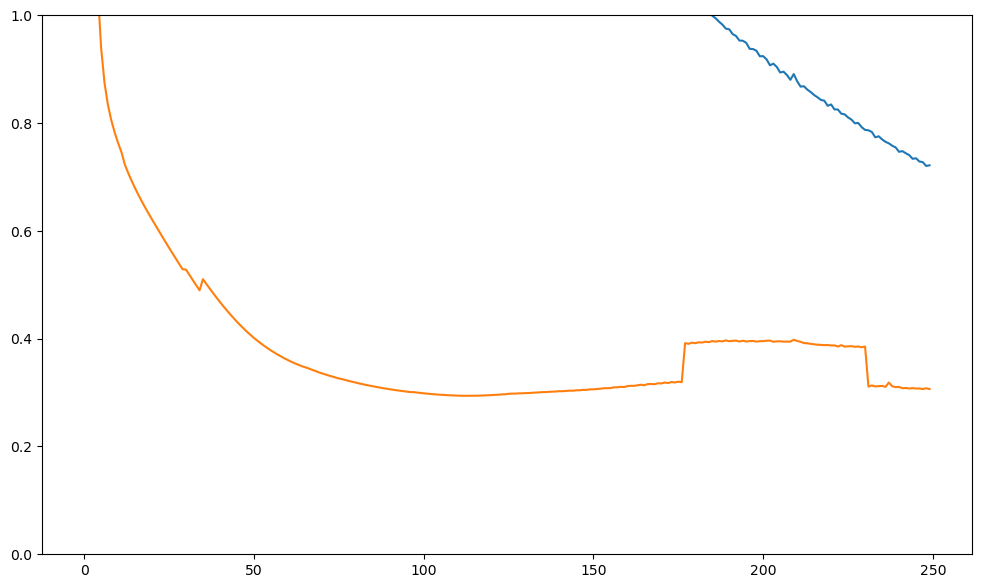

In [398]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

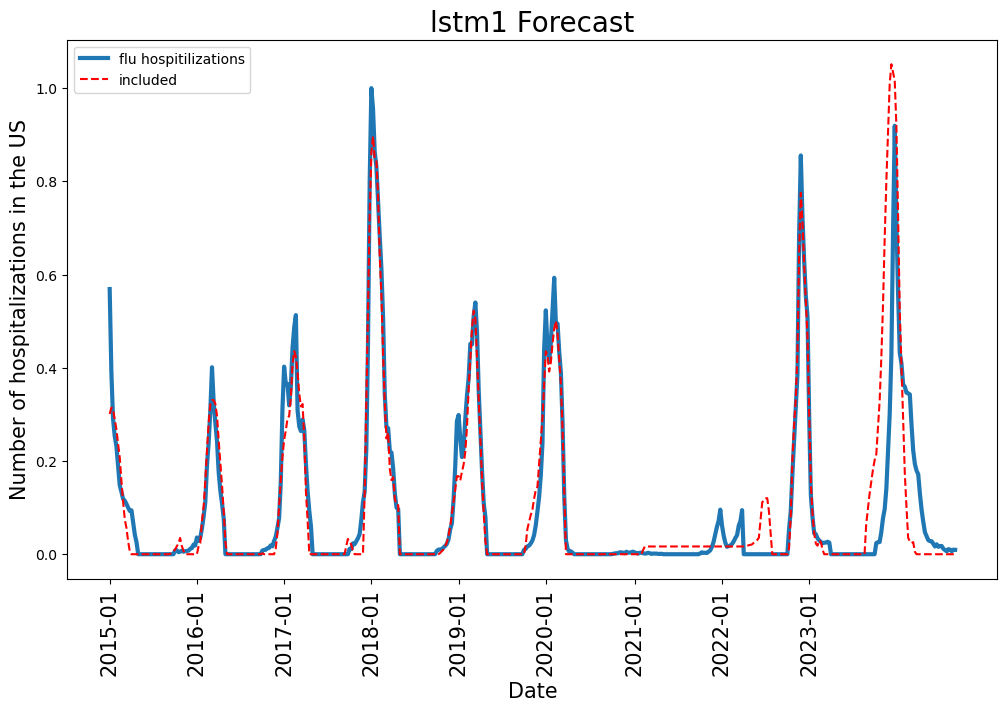

In [399]:
plot_model('2024-36')

## LSTM Lin1

In [123]:
class lstm_lin1(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm_lin1, self).__init__()
        
        
        
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.lstm(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [212]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_lin1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [213]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.803203291558585 Val loss: 1.7087993613594563 Time: 0.8374174000000494
epoch 1 0 0
Train loss: 14.231719914934018 Val loss: 1.6636014541997912 Time: 0.7828787999987981
epoch 2 0 0
Train loss: 14.220062899884311 Val loss: 1.6180609860289847 Time: 0.7584459999998217
epoch 3 0 0
Train loss: 14.148130801280473 Val loss: 1.6121274719217003 Time: 0.7977366000013717
epoch 4 0 0
Train loss: 14.208642977912 Val loss: 1.6627093696832504 Time: 0.7833850999995775
epoch 5 1 1
Train loss: 14.13490039385863 Val loss: 1.6352828410443339 Time: 0.7715170000010403
epoch 6 0 0
Train loss: 13.981629452910283 Val loss: 1.5961318661967423 Time: 0.8209296000004542
epoch 7 0 0
Train loss: 13.51546525396671 Val loss: 1.5454986388177758 Time: 0.7706171999998332
epoch 8 0 0
Train loss: 11.480205202191534 Val loss: 1.3302833836531394 Time: 0.8715353000006871
epoch 9 0 0
Train loss: 8.453344882147832 Val loss: 1.0075335085436383 Time: 1.6235098999986803
epoch 10 0 0
Train loss: 6.860989119

(0.0, 2.0)

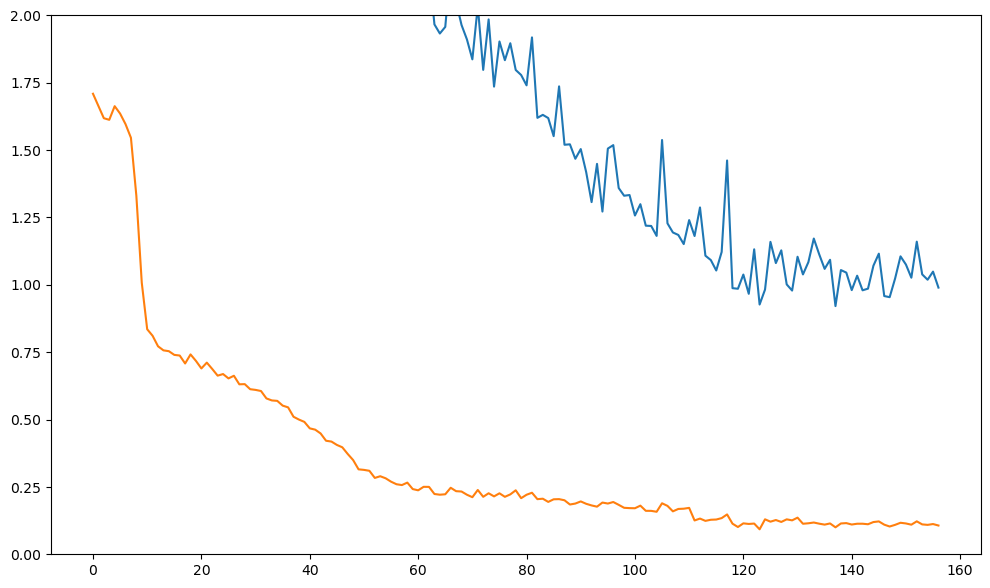

In [214]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,2])

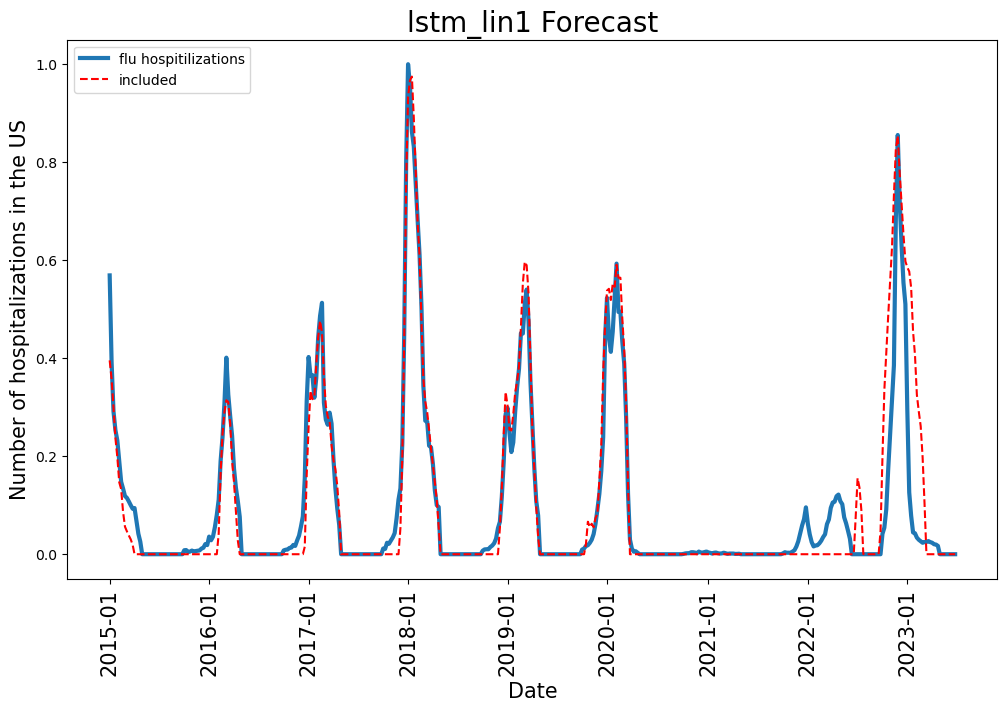

In [217]:
plot_model('2023-26')

### 23-24

In [400]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_lin1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_23-24.pth'
LOAD_PATH =   'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
#print(LOAD_PATH)
#model.load_state_dict(torch.load(LOAD_PATH))


loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [401]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 18.362216836681796 Val loss: 2.0191666177527052 Time: 1.060775099991588
epoch 1 0 0
Train loss: 16.816518897617925 Val loss: 1.8752875432005993 Time: 1.0122092999808956
epoch 2 0 0
Train loss: 16.433923823779395 Val loss: 1.8329079719404984 Time: 0.928305100009311
epoch 3 0 0
Train loss: 15.210966335822611 Val loss: 1.7021836150817462 Time: 0.8904528999992181
epoch 4 0 0
Train loss: 13.415312679669626 Val loss: 1.502853441737261 Time: 0.8827455000136979
epoch 5 0 0
Train loss: 10.417793016398901 Val loss: 1.1843322242225878 Time: 0.9095919000101276
epoch 6 0 0
Train loss: 8.865150809967197 Val loss: 1.0203350445731283 Time: 0.8937928999948781
epoch 7 0 0
Train loss: 8.272203491656366 Val loss: 0.9476781482746203 Time: 0.9252926000044681
epoch 8 0 0
Train loss: 7.868547573232016 Val loss: 0.904890344972162 Time: 0.8804513000068255
epoch 9 0 0
Train loss: 7.468870153171576 Val loss: 0.8628819547825737 Time: 0.877565799979493
epoch 10 0 0
Train loss: 7.633159022303

(0.0, 1.0)

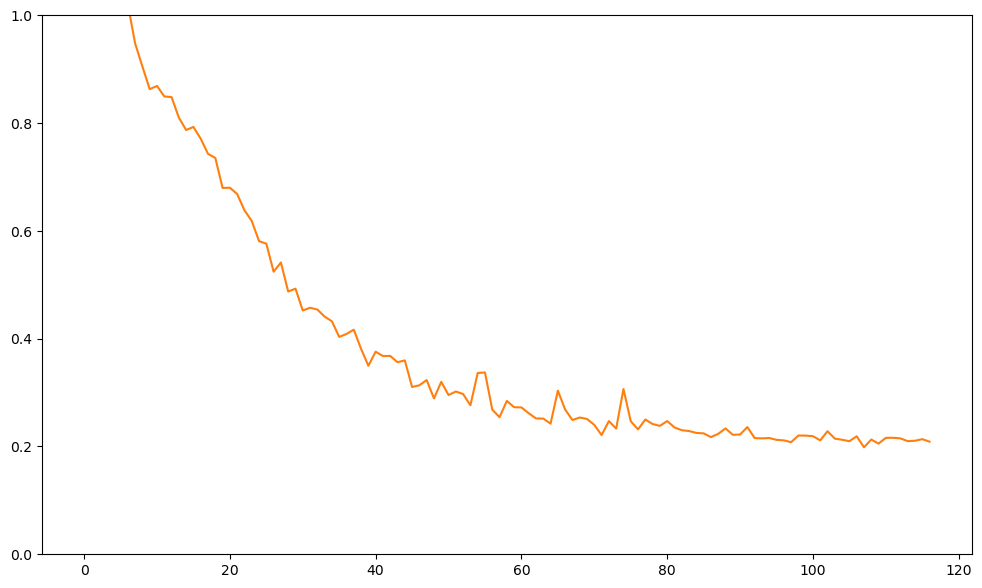

In [402]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

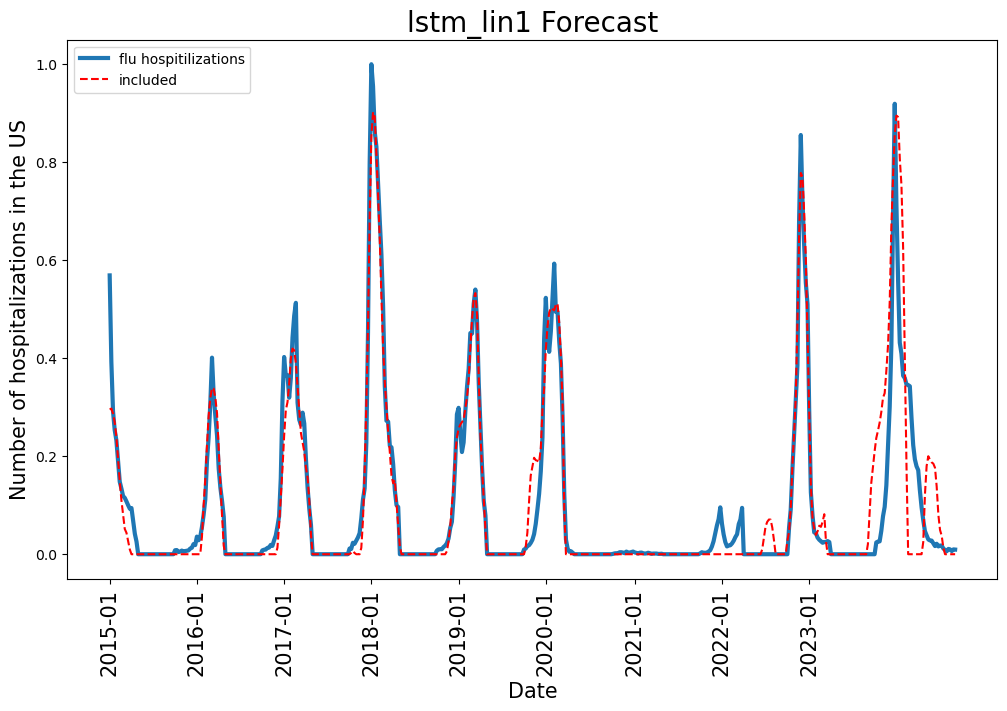

In [404]:
plot_model('2024-36')

## LSTM LinComb

In [124]:
class lstm_comb(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm_comb, self).__init__()
        
        
        
        self.comb = nn.Sequential(nn.Linear(country_len,country_len),
                                  nn.ReLU())
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
        #    nn.Dropout(0.05),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        logits = self.comb(x)
        logits, _ = self.lstm(logits.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [504]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_comb(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-3
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [505]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.853841955513253 Val loss: 2.7107788926354224 Time: 0.7987278000218794
epoch 1 0 0
Train loss: 17.80237040241545 Val loss: 1.9164913027255173 Time: 0.9830855000182055
epoch 2 0 1
Train loss: 8.980451528547674 Val loss: 1.0336864620016222 Time: 4.002969400025904
epoch 3 0 0
Train loss: 7.537477743501444 Val loss: 0.8933886313401803 Time: 1.117627400031779
epoch 4 0 0
Train loss: 7.092613090865286 Val loss: 0.858209249647647 Time: 1.1117755000013858
epoch 5 0 0
Train loss: 6.8792650951452 Val loss: 0.8410692826994838 Time: 1.089169699989725
epoch 6 0 0
Train loss: 7.294335983979352 Val loss: 0.8737525447665618 Time: 1.102364500053227
epoch 7 1 1
Train loss: 6.423410711462047 Val loss: 0.7911072145276336 Time: 1.078388299967628
epoch 8 0 0
Train loss: 6.035164604296753 Val loss: 0.7557492823455711 Time: 1.1758479000418447
epoch 9 0 0
Train loss: 5.5276905511466055 Val loss: 0.7030933261757475 Time: 1.1436790999723598
epoch 10 0 0
Train loss: 5.439661415512717 Val

(0.0, 1.0)

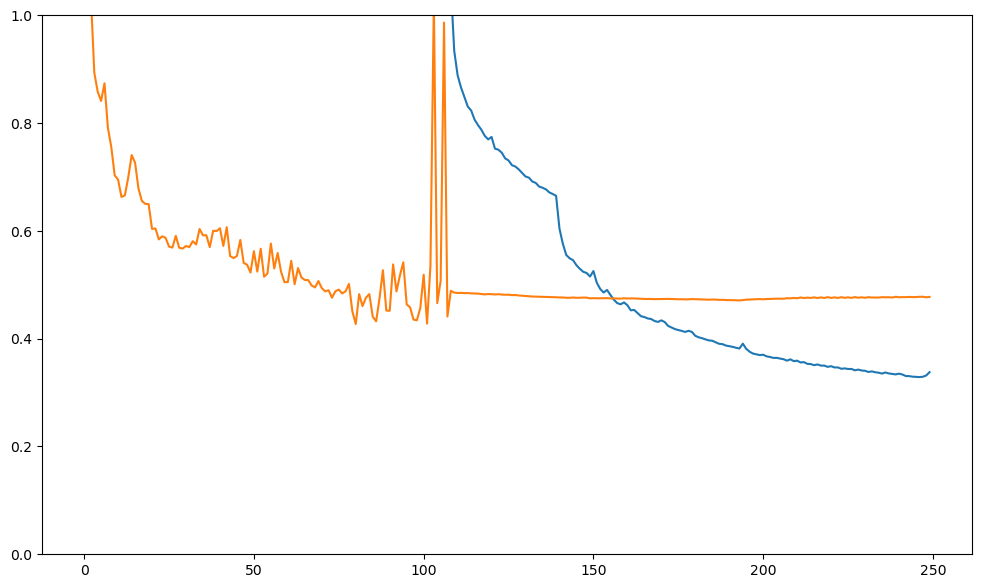

In [506]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

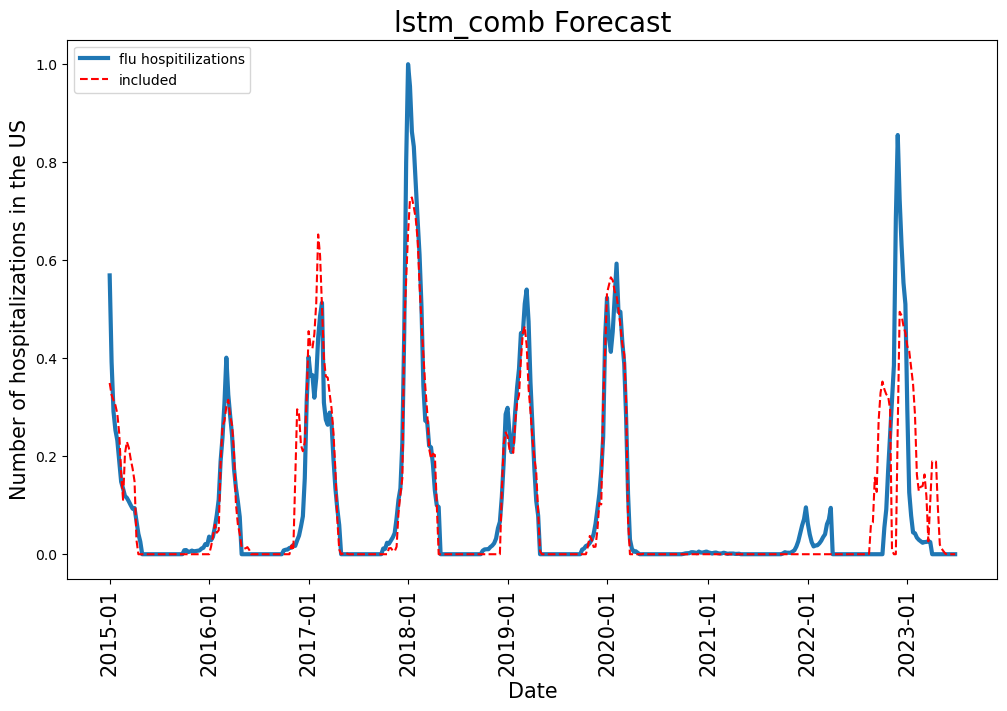

In [507]:
plot_model('2023-26')

## RNN

In [125]:
class rnn(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(rnn, self).__init__()
        
        
        
        self.rnn = nn.RNN(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.rnn(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.rnn(logits)
        
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [223]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [224]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.692223698610164 Val loss: 1.709305791339583 Time: 0.46711040000081994
epoch 1 0 0
Train loss: 13.68726192659443 Val loss: 1.6143505419879574 Time: 0.4446211000031326
epoch 2 0 0
Train loss: 12.678931763980088 Val loss: 1.489225815438206 Time: 0.45396399998571724
epoch 3 0 0
Train loss: 10.588164032865777 Val loss: 1.2751772501523653 Time: 0.45845389999158215
epoch 4 0 0
Train loss: 8.070227970208885 Val loss: 0.9974587242760958 Time: 0.4558599000010872
epoch 5 0 0
Train loss: 6.714838942482394 Val loss: 0.8489310173640434 Time: 0.5010085999965668
epoch 6 0 0
Train loss: 6.225774190144287 Val loss: 0.7881300064927491 Time: 0.45526230000541545
epoch 7 0 0
Train loss: 6.017978118174199 Val loss: 0.7712109930135044 Time: 0.4508535000059055
epoch 8 0 0
Train loss: 5.827139375057307 Val loss: 0.7472718287372059 Time: 0.5240695999964373
epoch 9 0 0
Train loss: 5.664962607948083 Val loss: 0.7295976860101467 Time: 0.46282980000250973
epoch 10 0 0
Train loss: 5.5475297

(0.0, 1.0)

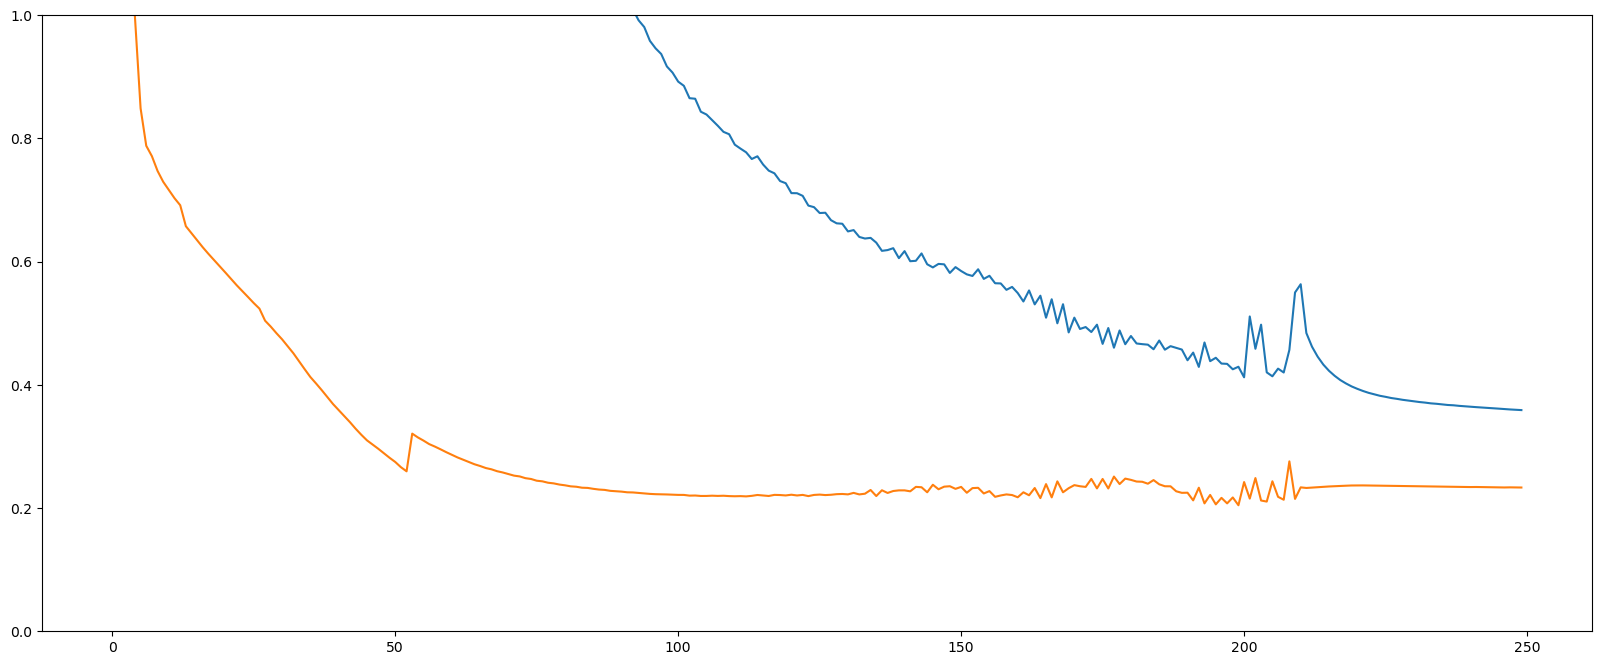

In [225]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

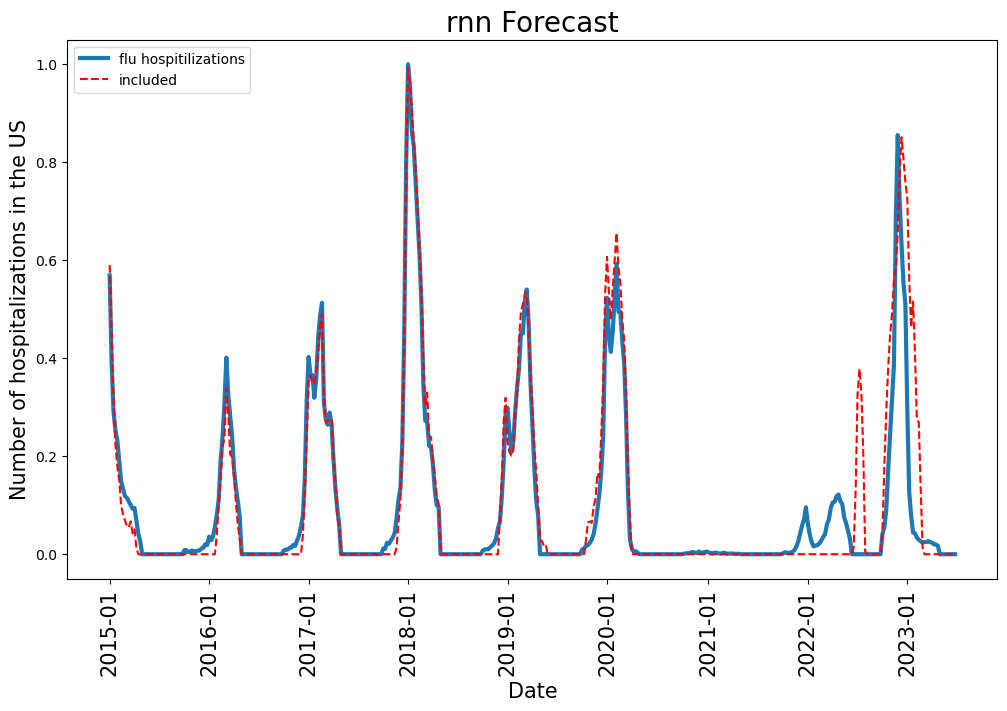

In [226]:
plot_model('2023-26')

### 23-24

In [407]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_23-24.pth'
LOAD_PATH =   'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
#print(LOAD_PATH)
#model.load_state_dict(torch.load(LOAD_PATH))


loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [408]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 17.637839007692662 Val loss: 1.9659090374654802 Time: 0.5495813000015914
epoch 1 0 0
Train loss: 15.262608749272886 Val loss: 1.72853821933218 Time: 0.4762784000195097
epoch 2 0 0
Train loss: 12.537334787342054 Val loss: 1.4462201520649502 Time: 0.4662954999948852
epoch 3 0 0
Train loss: 9.407028941857618 Val loss: 1.124396982234874 Time: 0.46931029998813756
epoch 4 0 0
Train loss: 8.047765368984596 Val loss: 0.961215363854694 Time: 0.48255720001179725
epoch 5 0 0
Train loss: 7.557493218640857 Val loss: 0.9038561122628943 Time: 0.48769810001249425
epoch 6 0 0
Train loss: 7.237784035703246 Val loss: 0.8657228849668259 Time: 0.4886056999966968
epoch 7 0 0
Train loss: 6.955722363587199 Val loss: 0.8362350257498122 Time: 0.5207025999843609
epoch 8 0 0
Train loss: 6.716355958812507 Val loss: 0.7864102537676343 Time: 0.4964582000102382
epoch 9 0 0
Train loss: 6.507595449122121 Val loss: 0.7626949211345115 Time: 0.6676854999968782
epoch 10 0 0
Train loss: 6.31432247276

(0.0, 1.0)

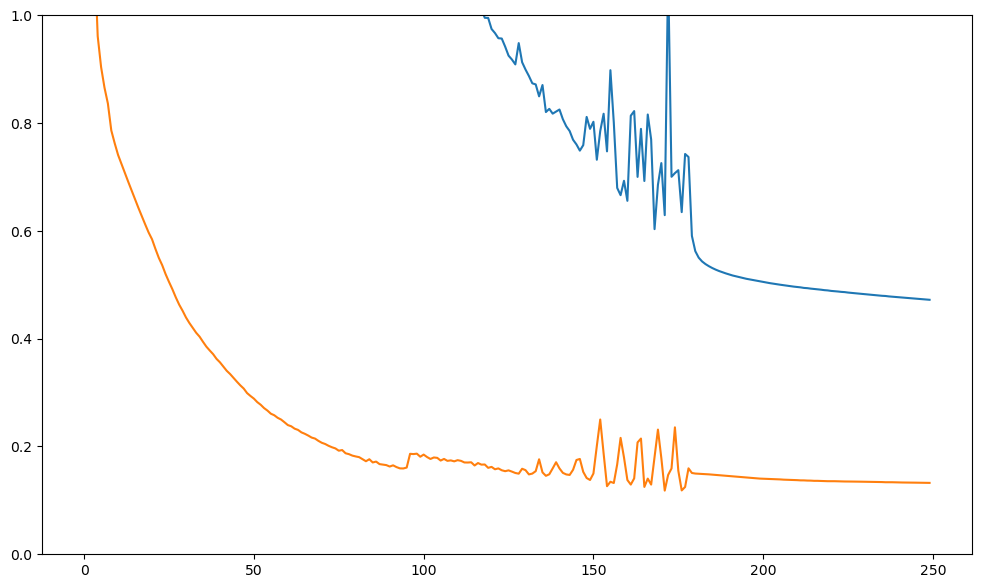

In [409]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

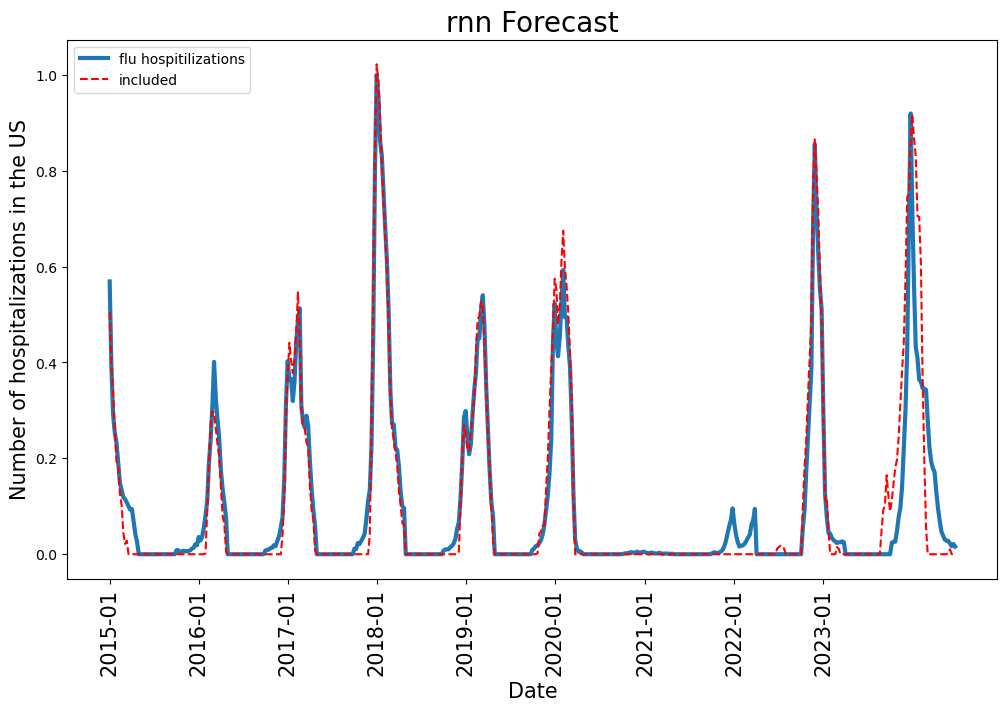

In [410]:
plot_model('2024-26')

## RNN1

In [126]:
class rnn1(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(rnn1, self).__init__()
        
        
        
        self.rnn = nn.RNN(seq_len,seq_len,num_layers = 1)
        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        

 
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.rnn(x.permute(0,2,1))        
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [232]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-3
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [233]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 11.035764489002318 Val loss: 1.1769497645151625 Time: 0.4145305999991251
epoch 1 0 0
Train loss: 6.364494855727813 Val loss: 0.713791680089268 Time: 0.3601248999912059
epoch 2 0 0
Train loss: 5.867349310721528 Val loss: 0.6552237882420684 Time: 0.37942679999105167
epoch 3 0 0
Train loss: 5.344382152861527 Val loss: 0.5926457804587297 Time: 0.35381679999409243
epoch 4 0 0
Train loss: 4.978910306712152 Val loss: 0.5515203962893592 Time: 0.34810669999569654
epoch 5 0 0
Train loss: 4.6186986749827 Val loss: 0.5100126950278943 Time: 0.4465749000082724
epoch 6 0 0
Train loss: 4.250666683190531 Val loss: 0.472594621337857 Time: 0.40595820000453386
epoch 7 0 0
Train loss: 3.9691249063361145 Val loss: 0.4444999619880156 Time: 0.3491876000043703
epoch 8 0 0
Train loss: 3.7112606106016983 Val loss: 0.4230968288690409 Time: 0.3403680000046734
epoch 9 0 0
Train loss: 3.4720242813357487 Val loss: 0.40150257710585746 Time: 0.36729909999121446
epoch 10 0 0
Train loss: 3.3334533

(0.0, 1.0)

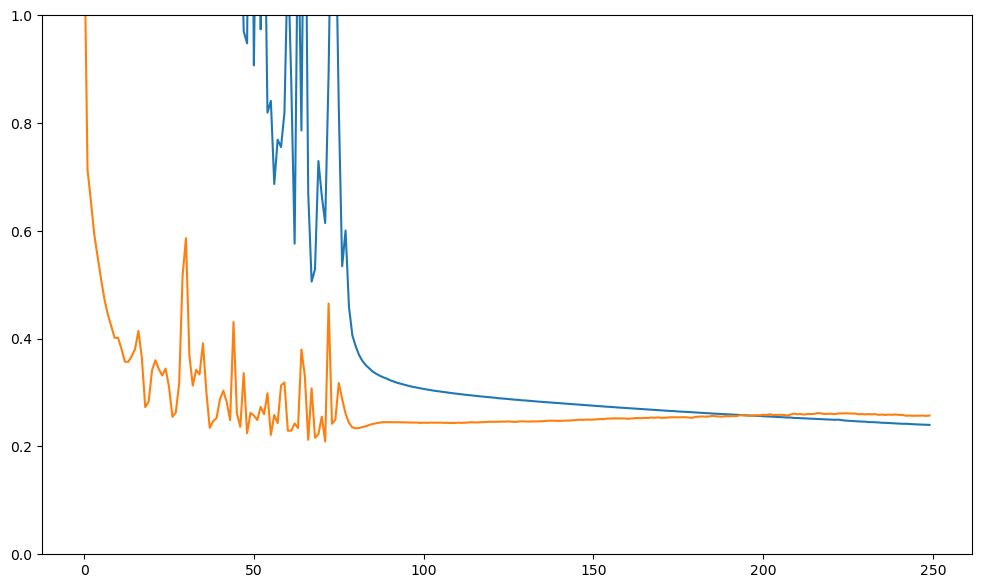

In [234]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

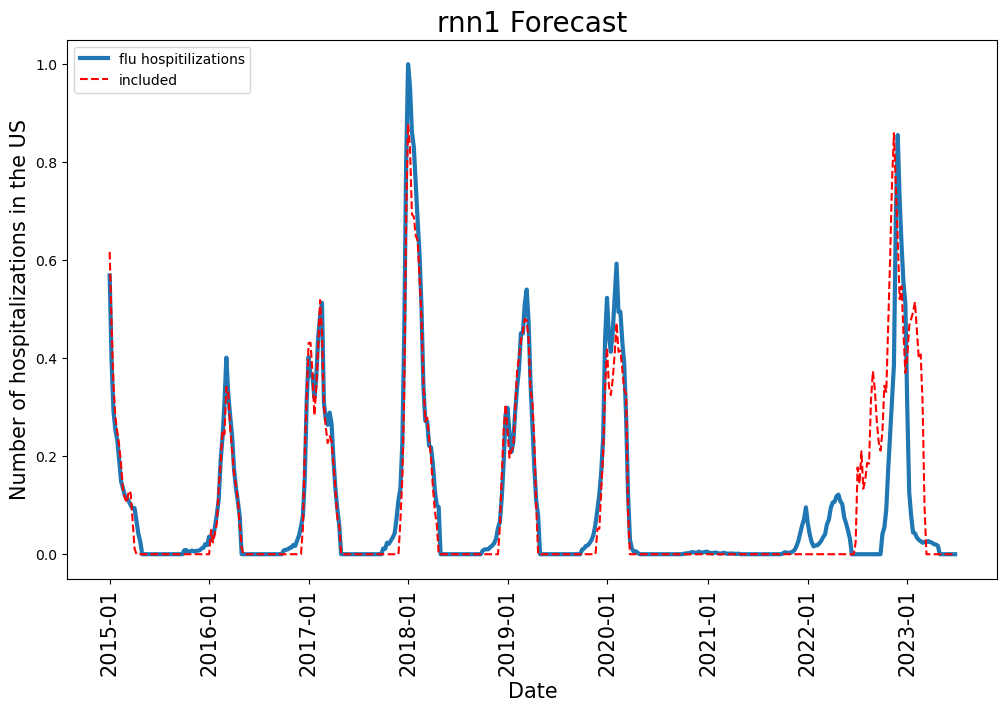

In [235]:
plot_model('2023-26')

### 23-24

In [412]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_23-24.pth'
LOAD_PATH =   'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
#print(LOAD_PATH)
#model.load_state_dict(torch.load(LOAD_PATH))


loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [413]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 19.652285601322205 Val loss: 2.1618400795007853 Time: 0.4702648000093177
epoch 1 0 0
Train loss: 13.47180529776682 Val loss: 1.5629325801190423 Time: 0.3470089000184089
epoch 2 0 0
Train loss: 10.085453506631 Val loss: 1.2031374055595778 Time: 0.33670680000795983
epoch 3 0 0
Train loss: 8.182110103152878 Val loss: 0.9999429149999942 Time: 0.33984139998210594
epoch 4 0 0
Train loss: 7.25161993293119 Val loss: 0.8988631853865432 Time: 0.3353573000058532
epoch 5 0 0
Train loss: 6.80054617779662 Val loss: 0.8438366743274468 Time: 0.4035544999933336
epoch 6 0 0
Train loss: 6.5189788020446855 Val loss: 0.8072526718356329 Time: 0.35715510000591166
epoch 7 0 0
Train loss: 6.304902947385504 Val loss: 0.7793009416494647 Time: 0.33687519998056814
epoch 8 0 0
Train loss: 6.1179292798858285 Val loss: 0.7550798239626859 Time: 0.34074350001174025
epoch 9 0 0
Train loss: 5.953884949053972 Val loss: 0.7341315563217453 Time: 0.3385493000096176
epoch 10 0 0
Train loss: 5.803022676

(0.0, 1.0)

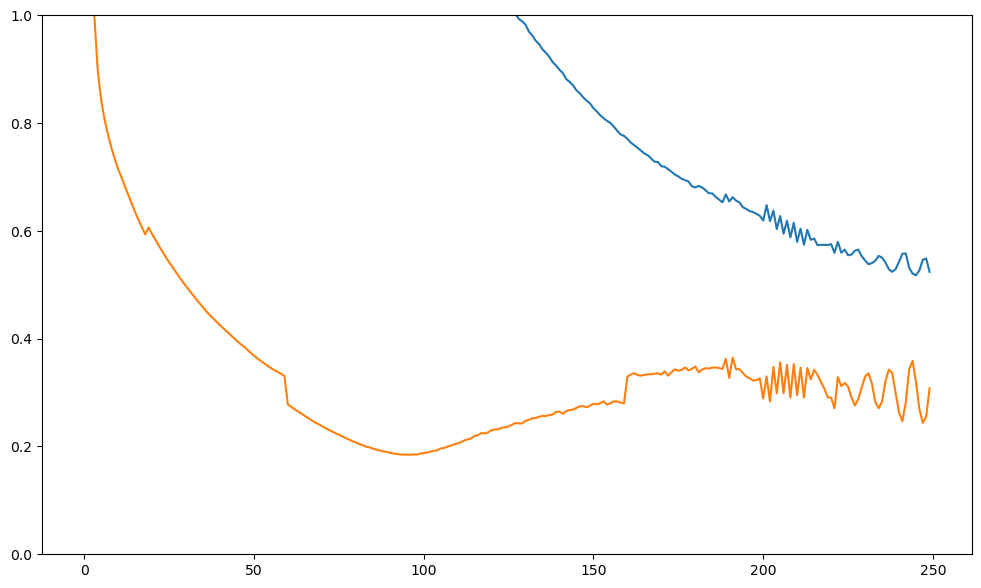

In [414]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

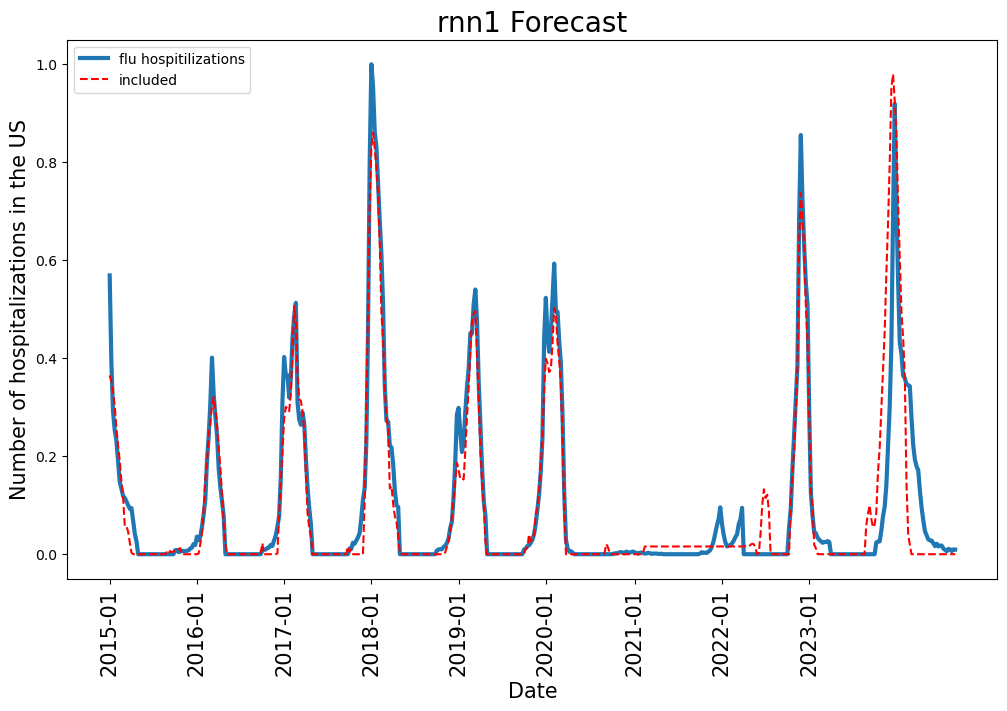

In [415]:
plot_model('2024-36')

## RNN Lin1

In [127]:
class rnn_lin1(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(rnn_lin1, self).__init__()
        
        
        
        self.lstm = nn.RNN(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.lstm(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [236]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn_lin1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 350
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [237]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.813852382968946 Val loss: 1.6786294308526384 Time: 0.775211300002411
epoch 1 0 0
Train loss: 14.164768981323277 Val loss: 1.6199545951246797 Time: 0.9409194000036223
epoch 2 0 0
Train loss: 13.254135925898346 Val loss: 1.5546604302747675 Time: 0.7698802999948384
epoch 3 0 0
Train loss: 10.78951249347078 Val loss: 1.2719125996475498 Time: 0.8734604999917792
epoch 4 0 0
Train loss: 7.851920742252297 Val loss: 0.9654108729390942 Time: 0.7556381999893347
epoch 5 0 0
Train loss: 6.775781561042546 Val loss: 0.8557393944102822 Time: 0.8344005000108154
epoch 6 0 0
Train loss: 6.278595597527556 Val loss: 0.8103640122293082 Time: 0.7118664000008721
epoch 7 0 0
Train loss: 6.250140250748686 Val loss: 0.8047412251059419 Time: 0.7292224000120768
epoch 8 0 0
Train loss: 6.241102121485891 Val loss: 0.8032262009911781 Time: 0.7305506999982754
epoch 9 0 0
Train loss: 5.6481481207514355 Val loss: 0.7490863437629586 Time: 0.7255351000057999
epoch 10 0 0
Train loss: 5.6420998456

(0.0, 1.0)

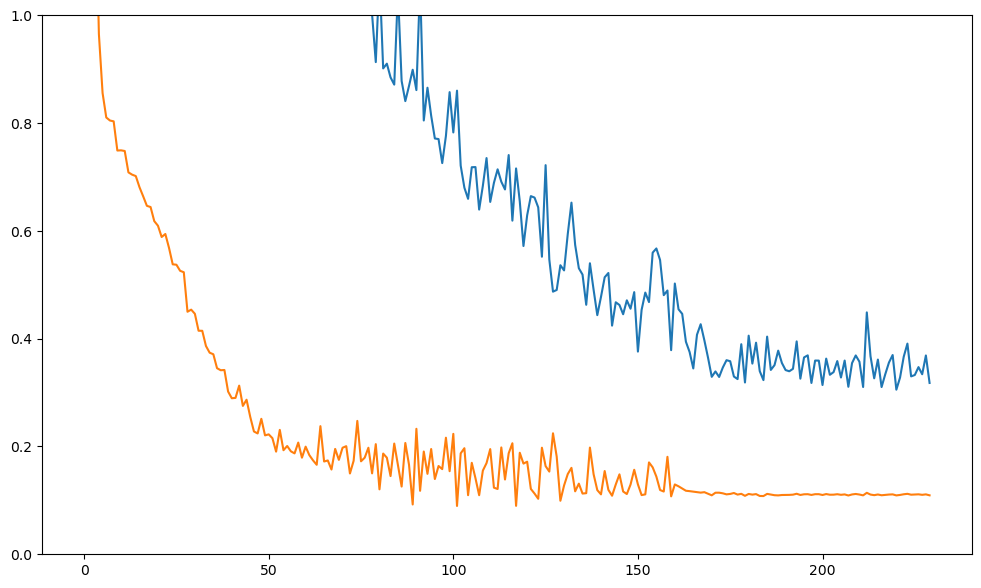

In [238]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

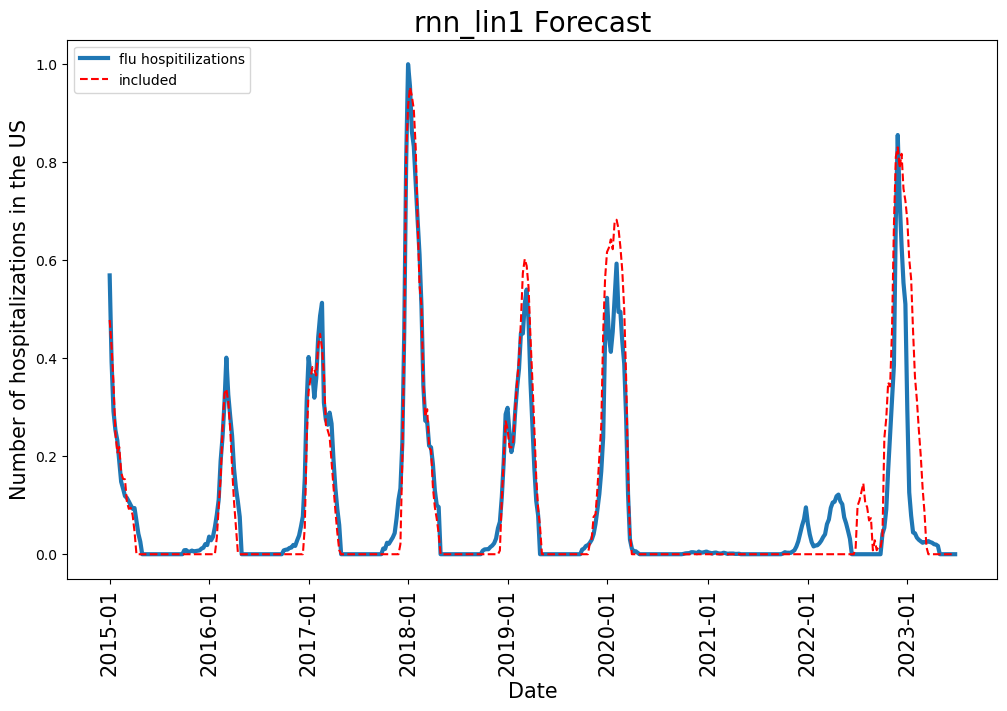

In [239]:
plot_model('2023-26')

### 23-24

In [420]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn_lin1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_23-24.pth'
LOAD_PATH =   'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
#print(LOAD_PATH)
#model.load_state_dict(torch.load(LOAD_PATH))


loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [421]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 17.158650442744374 Val loss: 1.9056460706234526 Time: 0.7953784000128508
epoch 1 0 0
Train loss: 16.076517992049574 Val loss: 1.78978495379888 Time: 0.7602748000063002
epoch 2 0 0
Train loss: 13.39482808222316 Val loss: 1.4868875761675815 Time: 0.7065459000004921
epoch 3 0 0
Train loss: 9.126310729019746 Val loss: 1.041220014806696 Time: 0.7140037999779452
epoch 4 0 0
Train loss: 7.637575042590754 Val loss: 0.8810910466184259 Time: 0.6842527999833692
epoch 5 0 0
Train loss: 7.2278271683984485 Val loss: 0.8302255755724341 Time: 0.7233678000047803
epoch 6 0 0
Train loss: 7.045331036102851 Val loss: 0.8066679755888908 Time: 0.7690966000081971
epoch 7 0 0
Train loss: 6.680441689195014 Val loss: 0.765917694515007 Time: 0.8420970999868587
epoch 8 0 0
Train loss: 6.409537647284285 Val loss: 0.7332985029786139 Time: 0.7049852999916766
epoch 9 0 0
Train loss: 6.115835190692771 Val loss: 0.7066894770901516 Time: 0.9993518999835942
epoch 10 0 0
Train loss: 5.82355712271249

(0.0, 1.0)

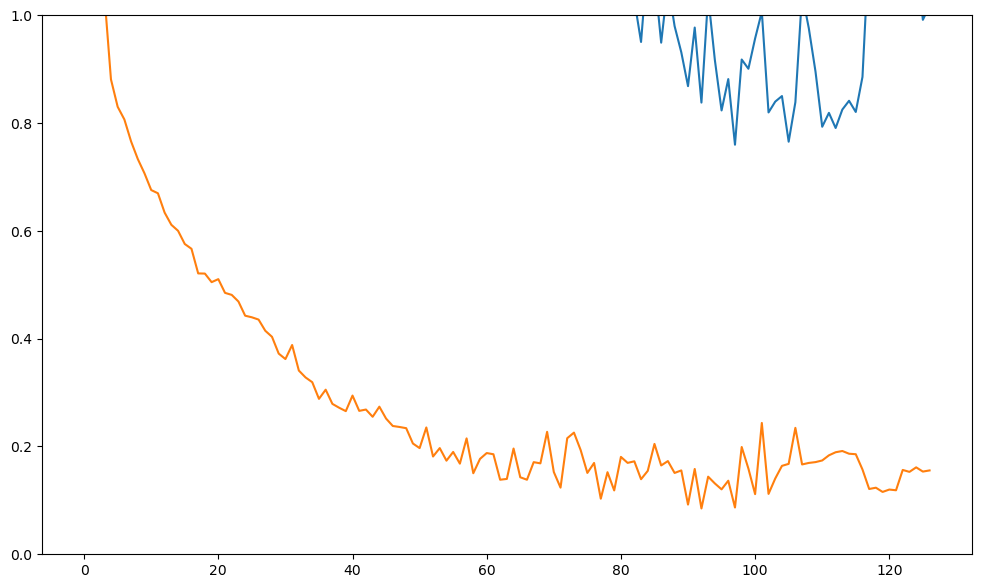

In [422]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

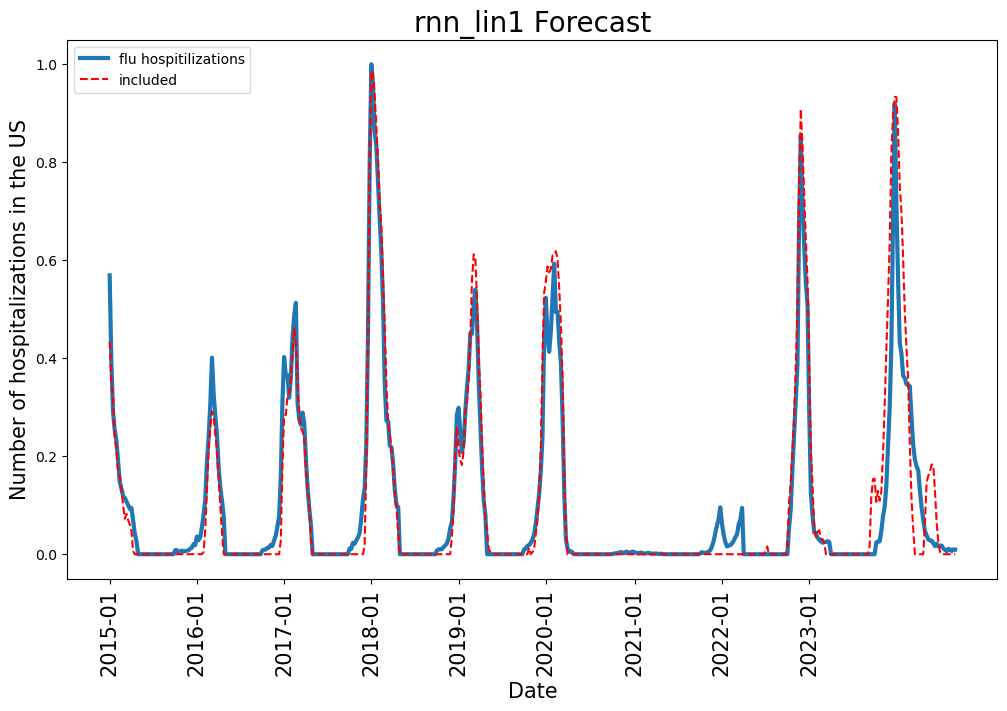

In [423]:
plot_model('2024-36')

## GRU

In [128]:
class gru(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(gru, self).__init__()
        
        
        
        self.gru= nn.GRU(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            #nn.Dropout(0.05),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.gru(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.gru(logits)
        
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [246]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-3
num_epochs = 300
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [247]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.662144067642288 Val loss: 2.096923647953184 Time: 0.6309827999939444
epoch 1 0 0
Train loss: 9.035387384875277 Val loss: 1.070261505998972 Time: 0.698080400004983
epoch 2 0 0
Train loss: 6.598462851410943 Val loss: 1.0035622667673014 Time: 0.7533313000021735
epoch 3 0 0
Train loss: 7.8406642902182 Val loss: 0.9434672475416089 Time: 0.6417175999959
epoch 4 0 1
Train loss: 5.823054649389917 Val loss: 0.8206151736835393 Time: 0.7031236999901012
epoch 5 0 0
Train loss: 6.484641001405748 Val loss: 0.8464701340424035 Time: 0.6696801999933086
epoch 6 1 1
Train loss: 5.702556186061061 Val loss: 0.8713842207844886 Time: 0.6152203999954509
epoch 7 2 0
Train loss: 5.4181091699300055 Val loss: 0.8084334685793204 Time: 0.6676136000023689
epoch 8 0 0
Train loss: 4.691499658099332 Val loss: 0.7695116628318867 Time: 0.704687899997225
epoch 9 0 0
Train loss: 4.638204967068339 Val loss: 0.7988935092400107 Time: 0.6122659999964526
epoch 10 1 0
Train loss: 4.402853010818006 Val 

(0.0, 1.0)

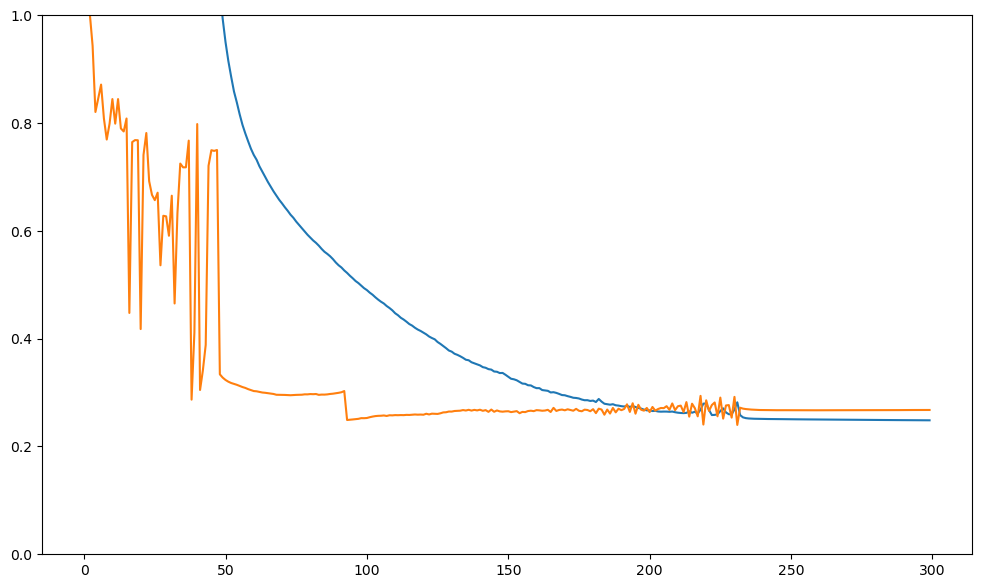

In [248]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

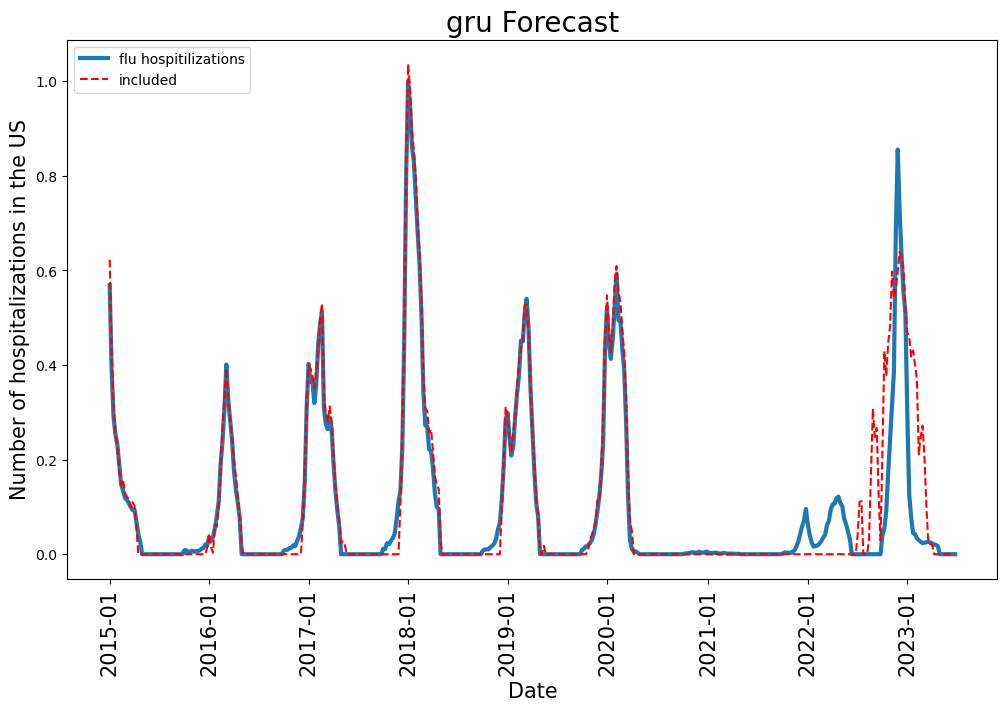

In [249]:
plot_model('2023-26')

### 23-24

In [424]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_23-24.pth'
LOAD_PATH =   'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
#print(LOAD_PATH)
#model.load_state_dict(torch.load(LOAD_PATH))


loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [425]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 16.369588148330877 Val loss: 1.850960111228235 Time: 0.6191153000108898
epoch 1 0 0
Train loss: 15.151694955713175 Val loss: 1.7270521764000517 Time: 0.6152852000086568
epoch 2 0 0
Train loss: 13.101666570824051 Val loss: 1.512896296347717 Time: 0.6077682999894023
epoch 3 0 0
Train loss: 10.328535617485372 Val loss: 1.2079510681014871 Time: 0.6014985000074375
epoch 4 0 0
Train loss: 8.480546275119387 Val loss: 0.9956554378735157 Time: 0.5987371999945026
epoch 5 0 0
Train loss: 7.890907659046405 Val loss: 0.9231104376446216 Time: 0.6157777000044007
epoch 6 0 0
Train loss: 7.670027880215919 Val loss: 0.8904955163936544 Time: 0.616259500005981
epoch 7 0 0
Train loss: 7.519416390614651 Val loss: 0.8676936444339519 Time: 0.6181091999751516
epoch 8 0 0
Train loss: 7.399115785605204 Val loss: 0.8502187442797772 Time: 0.625465900026029
epoch 9 0 0
Train loss: 7.291926496183834 Val loss: 0.835297211656627 Time: 0.7593687000044156
epoch 10 0 0
Train loss: 7.18771026983700

(0.0, 1.0)

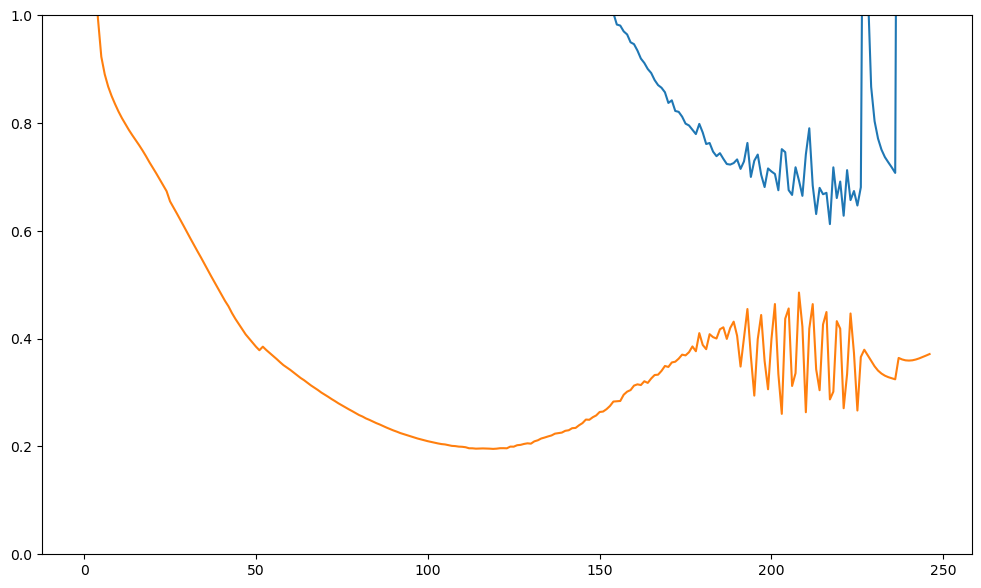

In [426]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

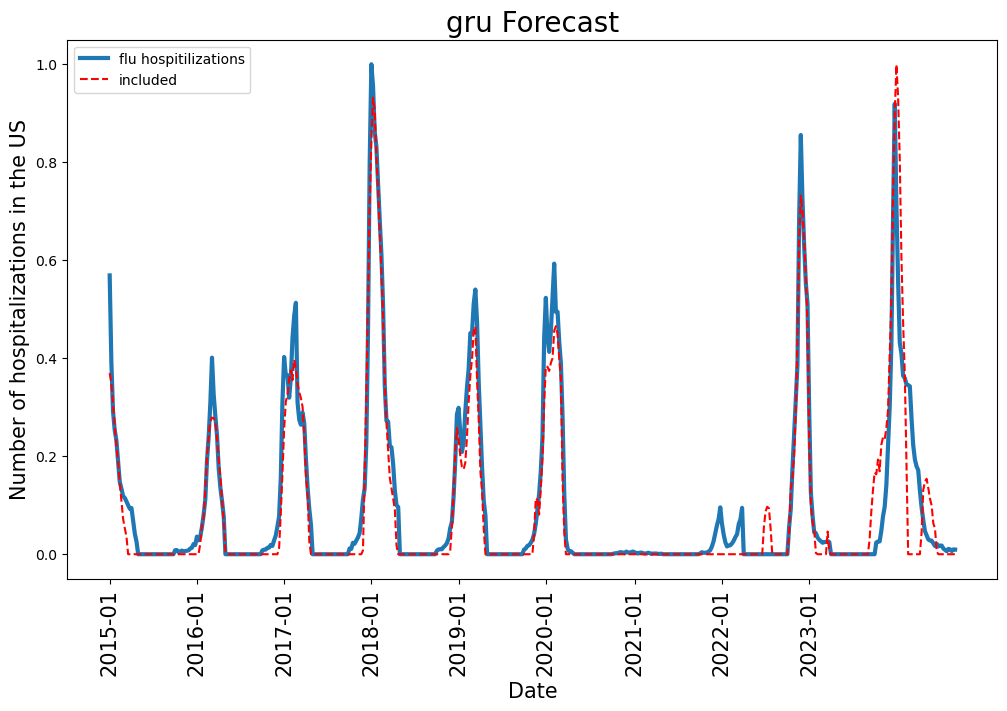

In [427]:
plot_model('2024-36')

## GRU1

In [129]:
class gru1(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(gru1, self).__init__()
        
        
        
        self.rnn = nn.GRU(seq_len,seq_len,num_layers = 1)
        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        

 
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.rnn(x.permute(0,2,1))        
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [251]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [252]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 13.799858744774296 Val loss: 1.5460328518442483 Time: 0.4388842000043951
epoch 1 0 0
Train loss: 10.56529965966077 Val loss: 1.235958982230168 Time: 0.40601399999286514
epoch 2 0 0
Train loss: 8.65167840347484 Val loss: 1.0461534137008044 Time: 0.41808920000039507
epoch 3 0 0
Train loss: 7.298132626788435 Val loss: 0.910098543338515 Time: 0.412307000005967
epoch 4 0 0
Train loss: 6.5209181288496145 Val loss: 0.8230838452757817 Time: 0.4166448999894783
epoch 5 0 0
Train loss: 6.1067148269454945 Val loss: 0.772117812446447 Time: 0.40698739999788813
epoch 6 0 0
Train loss: 5.86244692582919 Val loss: 0.7400158291676681 Time: 0.4263645000028191
epoch 7 0 0
Train loss: 5.692408730820624 Val loss: 0.7169743863689656 Time: 0.40847399999620393
epoch 8 0 0
Train loss: 5.5542227230919226 Val loss: 0.6991989179253187 Time: 0.4246752000035485
epoch 9 0 0
Train loss: 5.437729046401582 Val loss: 0.6841846145779721 Time: 0.4070096000068588
epoch 10 0 0
Train loss: 5.33128982807

(0.0, 1.0)

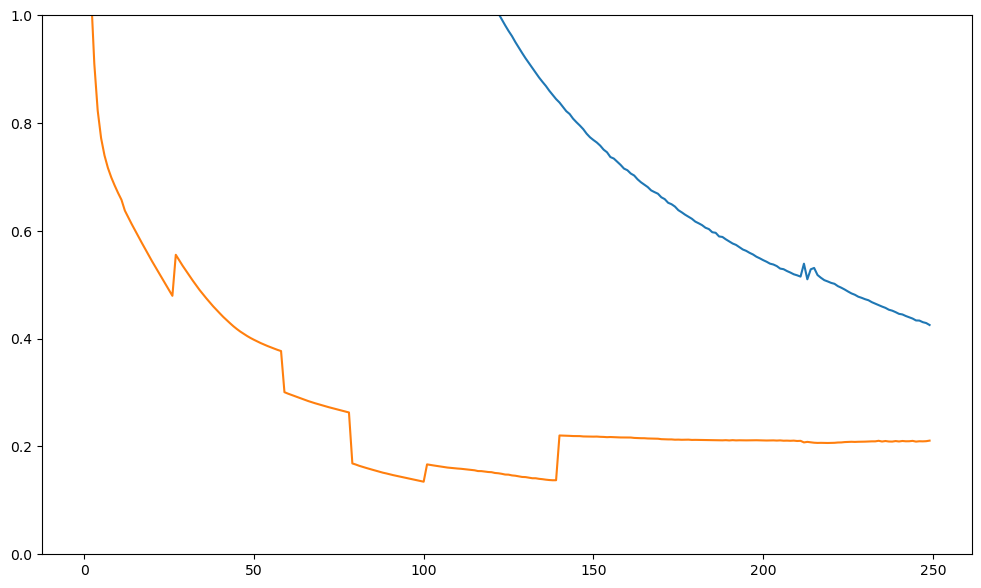

In [253]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

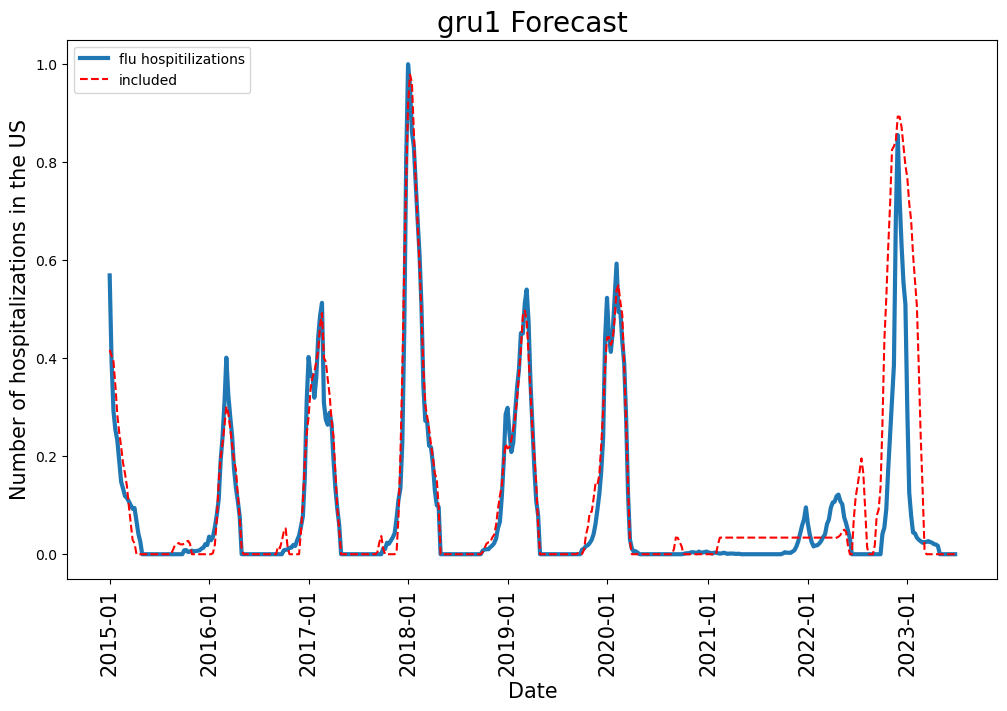

In [254]:
plot_model('2023-26')

### 23-24

In [430]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_23-24.pth'
LOAD_PATH =   'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
#print(LOAD_PATH)
#model.load_state_dict(torch.load(LOAD_PATH))


loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-27')
noise = False
forecast = 30

torch.manual_seed(4)

In [431]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 18.866160876845697 Val loss: 2.047118183430779 Time: 0.4290478999901097
epoch 1 0 0
Train loss: 12.882038473420813 Val loss: 1.4629214154362329 Time: 0.4360889999952633
epoch 2 0 0
Train loss: 10.153905312358342 Val loss: 1.18321249111407 Time: 0.43639210000401363
epoch 3 0 0
Train loss: 8.336863299750405 Val loss: 0.9922417030844857 Time: 0.4017508999968413
epoch 4 0 0
Train loss: 7.370459906879812 Val loss: 0.8853323174900788 Time: 0.40284470000187866
epoch 5 0 0
Train loss: 6.899963511991121 Val loss: 0.8294068958912467 Time: 0.40054060000693426
epoch 6 0 0
Train loss: 6.6298059986492035 Val loss: 0.7955760644846788 Time: 0.3988168000068981
epoch 7 0 0
Train loss: 6.43625772504631 Val loss: 0.7709985278904596 Time: 0.4510576000029687
epoch 8 0 0
Train loss: 6.269746914141503 Val loss: 0.7508997502058776 Time: 0.4282958000258077
epoch 9 0 0
Train loss: 6.119854725751971 Val loss: 0.732829675455786 Time: 0.4772123000002466
epoch 10 0 0
Train loss: 5.98091823565

(0.0, 1.0)

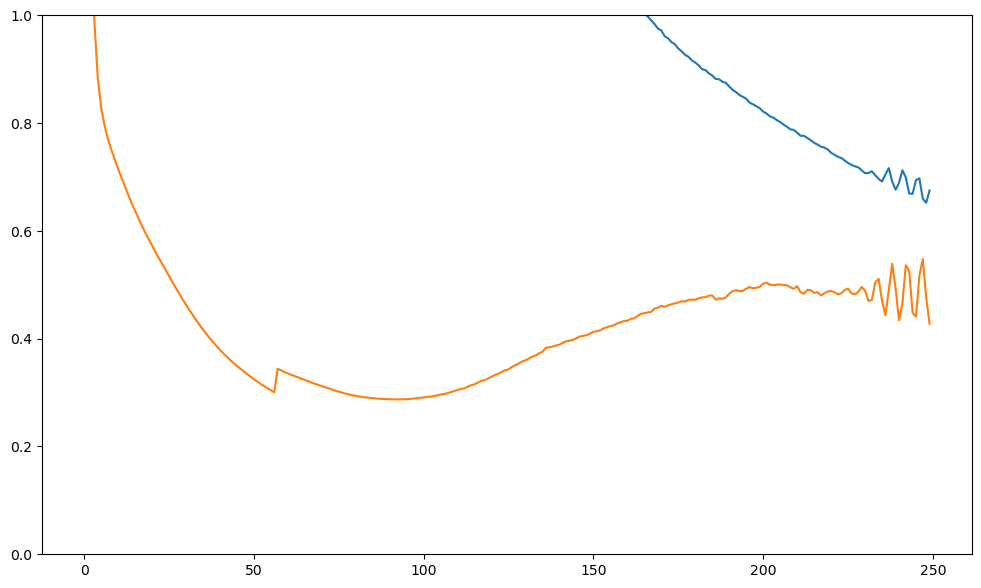

In [432]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

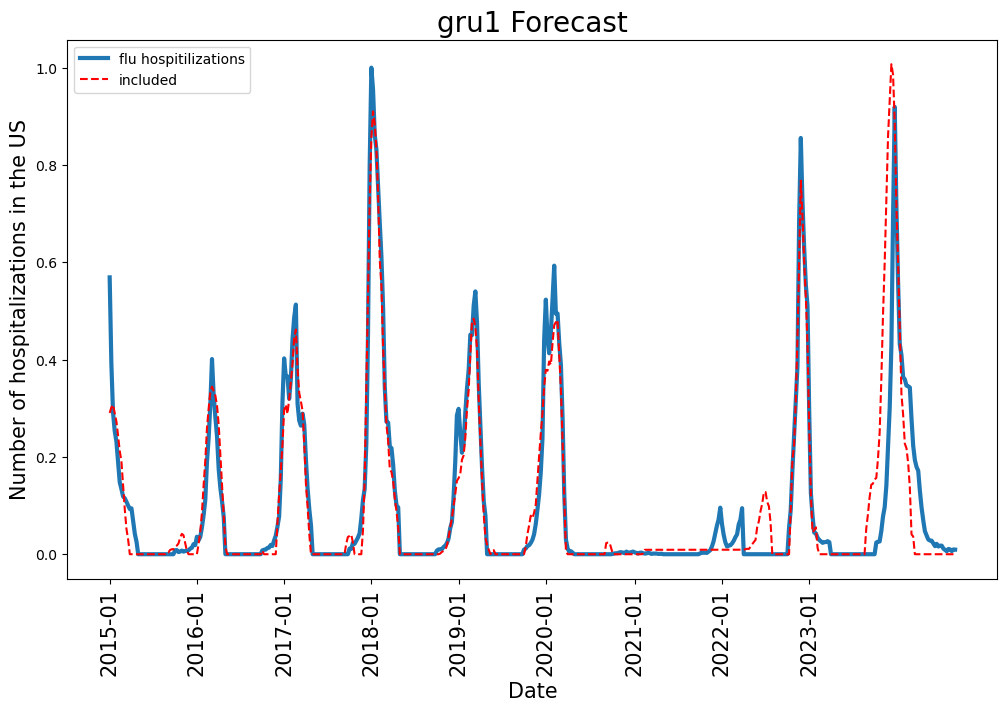

In [433]:
plot_model('2024-36')

## GRU Lin1

In [130]:
class gru_lin1(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(gru_lin1, self).__init__()
        
        
        
        self.lstm = nn.GRU(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.01),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.lstm(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        
        logits = self.seq(logits)
        
        
        return logits

### 22-23

In [256]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_lin1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [257]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.444349419037621 Val loss: 1.6389940945230959 Time: 1.191930599990883
epoch 1 0 0
Train loss: 14.196415542251714 Val loss: 1.6120588519253058 Time: 0.8322536000050604
epoch 2 0 0
Train loss: 13.390316405930548 Val loss: 1.5254508757470453 Time: 0.8689499000029173
epoch 3 0 0
Train loss: 10.71196962610605 Val loss: 1.2333948231681073 Time: 0.8423118999926373
epoch 4 0 0
Train loss: 7.64460392778539 Val loss: 0.9110745904124429 Time: 0.8305189999955473
epoch 5 0 0
Train loss: 6.890208340694594 Val loss: 0.8331028343977087 Time: 0.8395160000072792
epoch 6 0 0
Train loss: 6.550787002704936 Val loss: 0.7940889450617601 Time: 0.8350767999945674
epoch 7 0 0
Train loss: 6.357648657997281 Val loss: 0.7718931732569289 Time: 0.8530536000034772
epoch 8 0 0
Train loss: 6.15599887047026 Val loss: 0.7510874233261104 Time: 0.8499059999885503
epoch 9 0 0
Train loss: 5.982127911109046 Val loss: 0.7307629998437682 Time: 0.8385273000021698
epoch 10 0 0
Train loss: 5.7505985519785

(0.0, 1.0)

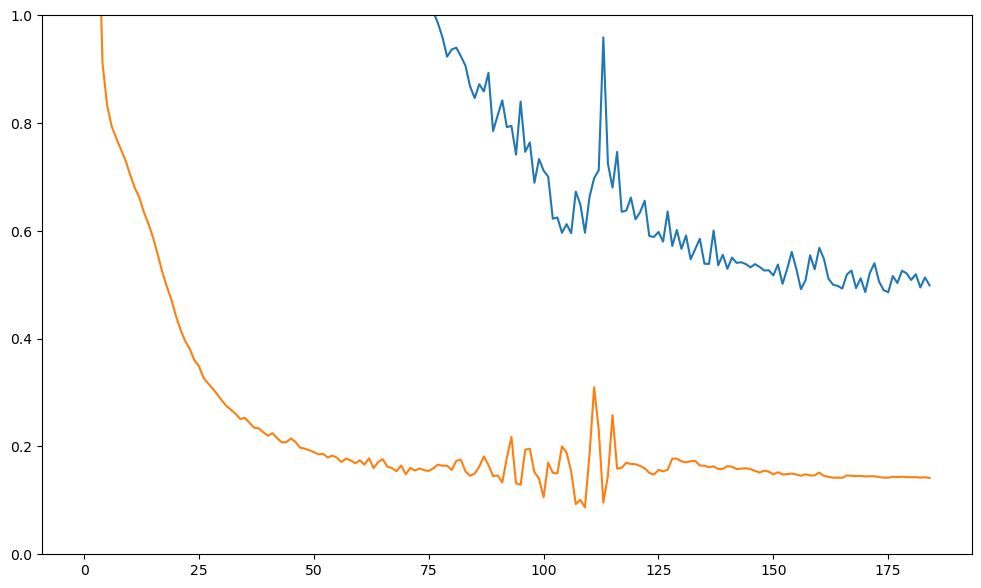

In [258]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

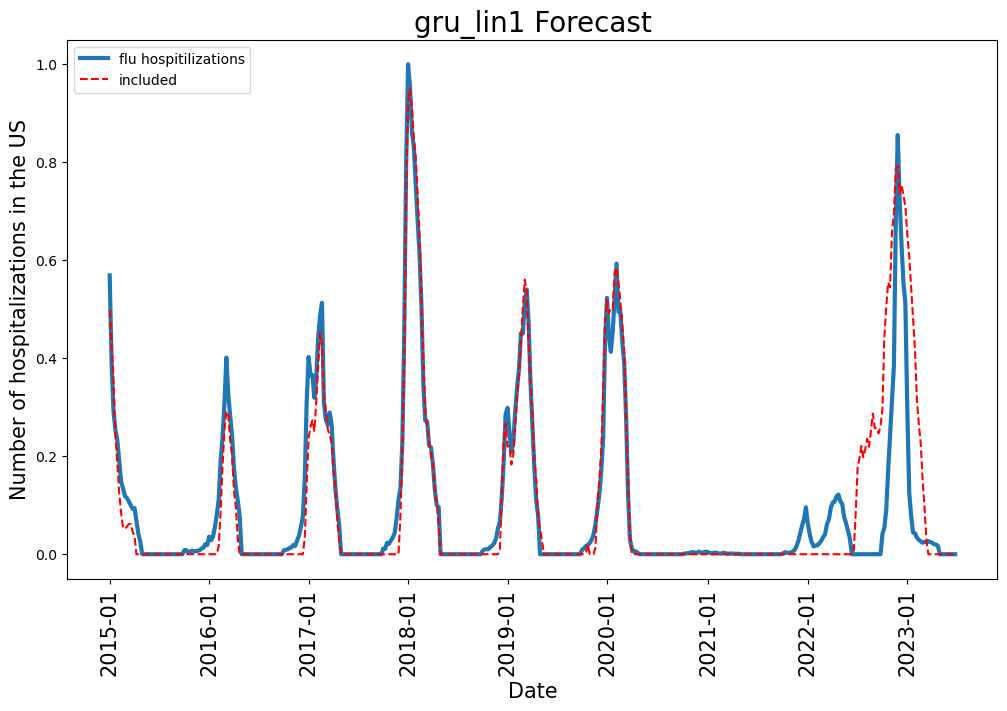

In [259]:
plot_model('2023-26')

### 23-24

In [438]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_lin1(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
#PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_new_22-23.pth'
PATH =  'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_23-24.pth'
LOAD_PATH =   'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
#print(LOAD_PATH)
#model.load_state_dict(torch.load(LOAD_PATH))


loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-27')
noise = False
forecast = 30

torch.manual_seed(4)


In [439]:
loss_t,loss_v, peaks = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 16.95934212483077 Val loss: 1.8877466275333927 Time: 0.9722820000024512
epoch 1 0 0
Train loss: 16.518313987069824 Val loss: 1.838745642524091 Time: 1.2154262000112794
epoch 2 0 0
Train loss: 14.772777052926983 Val loss: 1.648219379548973 Time: 1.9375609999988228
epoch 3 0 0
Train loss: 10.642549983958308 Val loss: 1.2060556971429603 Time: 2.1663144000049215
epoch 4 0 0
Train loss: 8.193414914998153 Val loss: 0.9500766848451471 Time: 4.214348799985601
epoch 5 0 0
Train loss: 7.7072970387138895 Val loss: 0.8894802425509273 Time: 0.947612800024217
epoch 6 0 0
Train loss: 7.315720221170363 Val loss: 0.8476400690810596 Time: 1.001418800005922
epoch 7 0 0
Train loss: 7.04160965371068 Val loss: 0.8128536769438133 Time: 1.0325463000044692
epoch 8 0 0
Train loss: 6.697536589271721 Val loss: 0.7760290168700155 Time: 0.9729959999967832
epoch 9 0 0
Train loss: 6.507879238622898 Val loss: 0.7579408277368879 Time: 0.9490151999925729
epoch 10 0 0
Train loss: 6.184004516531274

(0.0, 1.0)

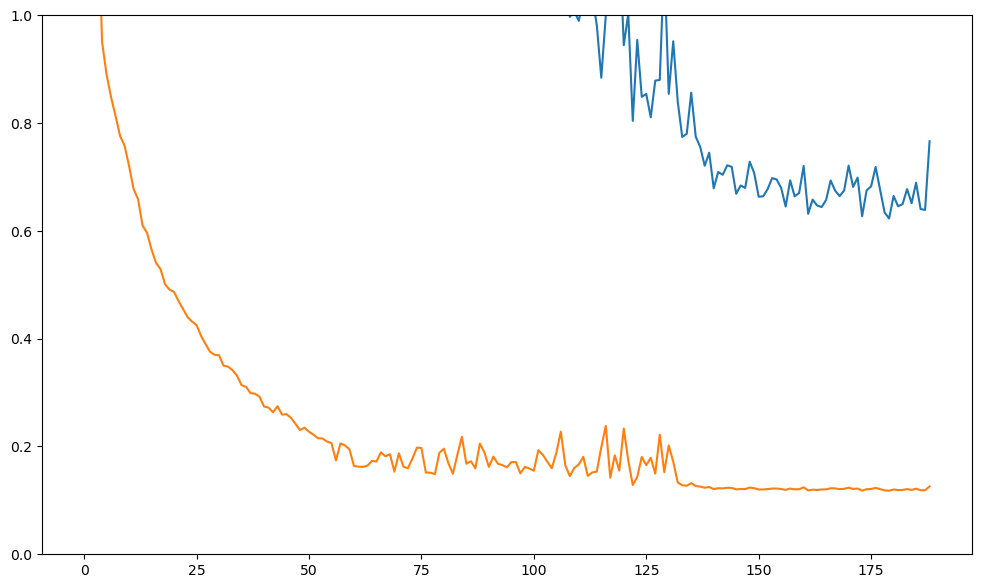

In [440]:
plt.plot(loss_t)
plt.plot(loss_v)
plt.ylim([0,1])

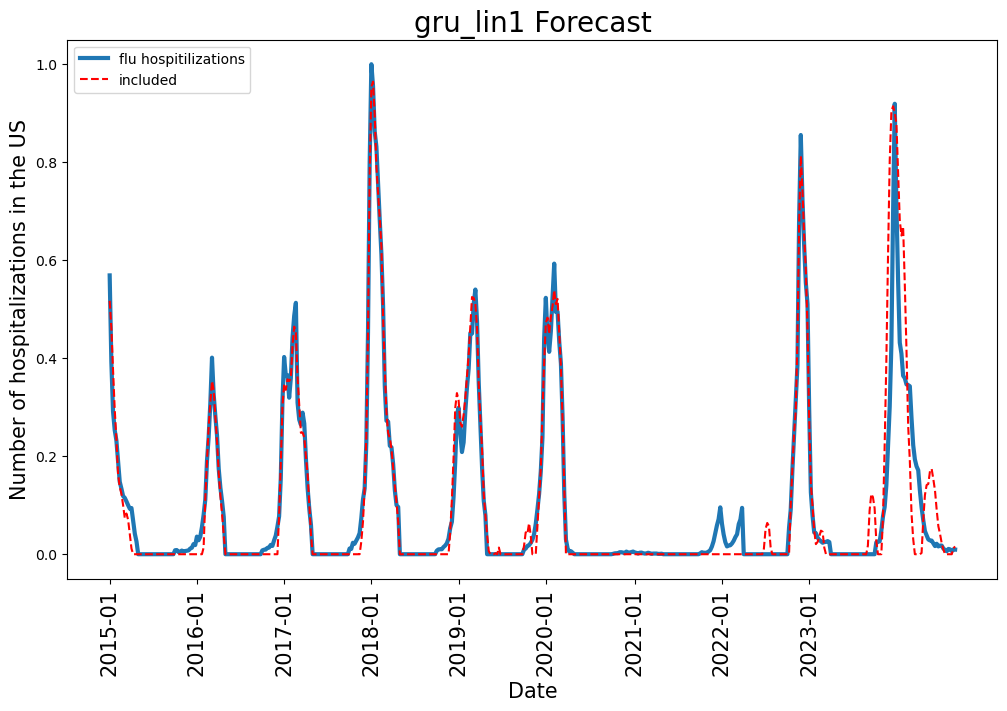

In [441]:
plot_model('2024-36')

# Summary

## 22-23

In [131]:
model_list = [rnn(26,5), rnn_lin1(26,5), gru1(26,5), gru_lin1(26,5), lstm(26,5), lstm1(26,5), lstm_lin1(26,5)]
#model_list = [lstm(26,5), lstm1(26,5), lstm_lin1(26,5)]

In [144]:
max_ = flu_surv['INF_ALL'].max()/0.09

rnn
rnn_lin1
gru1
gru_lin1
lstm
lstm1
lstm_lin1


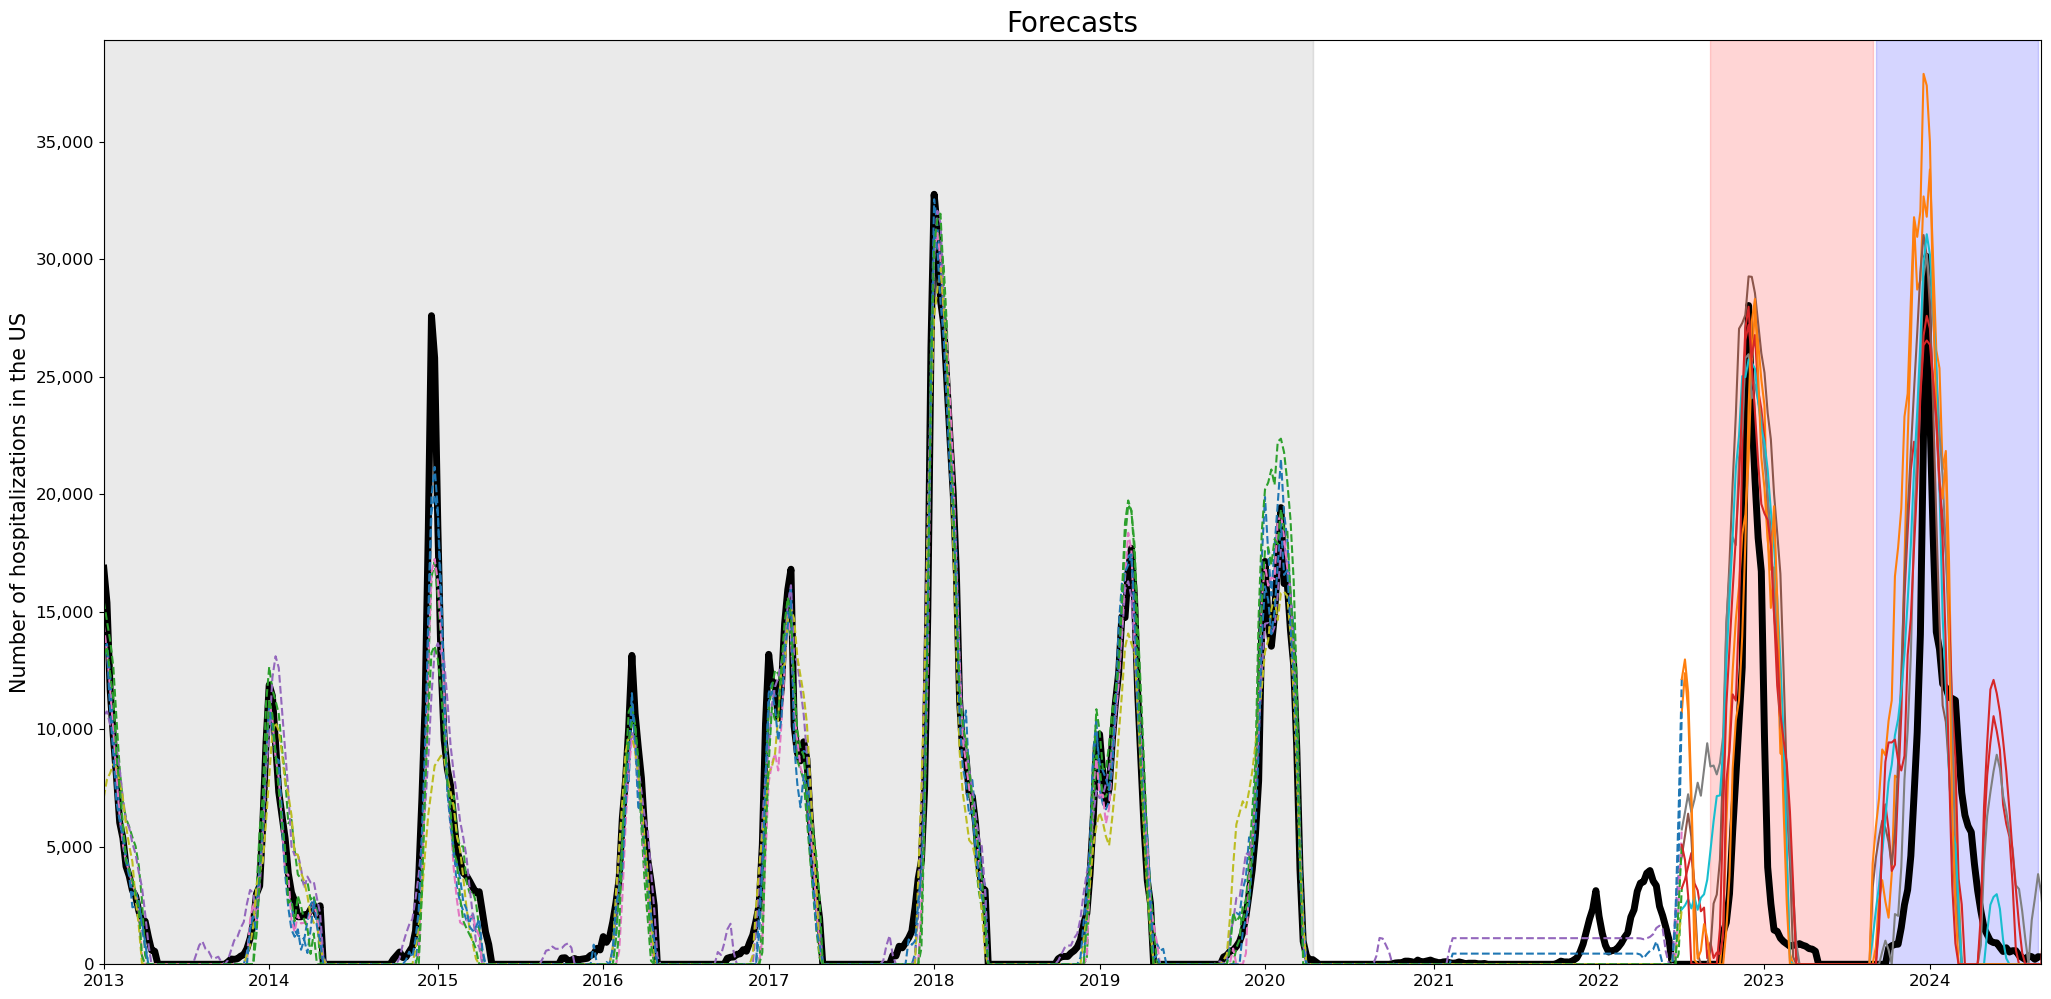

In [151]:
# plot all models
plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batched_sequence = data_in
fig, ax = plt.subplots(figsize=(25,12))
ax.plot(max_*plot_df["INF_ALL"].loc['2013-01':],linewidth=5,color='black')
for model in model_list:
    model = model.to(device)
    print(model.__class__.__name__)

    MODEL_PATH = 'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
    pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

    
    plot_df[model.__class__.__name__] = pred

    #plt.rcParams['figure.figsize'] = (25, 12)

    
    #plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
    ax.plot(max_*plot_df[model.__class__.__name__].loc['2013-01':'2022-27'],linestyle="dashed")#,label=model.__class__.__name__+'(included)')
    ax.plot(max_*plot_df[model.__class__.__name__].loc['2022-27':],label=model.__class__.__name__)#label=model.__class__.__name__+'(prediction)',linewidth=1)
    #plt.legend(loc='upper left')
    x_ticks=['2013-01','2014-01','2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01','2024-01']
    labels = ['2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']

    plt.xlim(['2013-01','2024-36'])

    ax.axvspan('2013-01', '2020-16', color='gray', alpha=0.025)
    ax.axvspan('2022-36', '2023-35', color='red', alpha=0.025)
    ax.axvspan('2023-36', '2024-35', color='blue', alpha=0.025)
    ax.set_ylim([0,1.2*max_])
    ax.set_xticks(ticks = x_ticks,labels=labels,size=12)

    #ax.set_yticks(size=12)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title('Forecasts',size =20)
    ax.set_ylabel('Number of hospitalizations in the US',fontsize=15)
    #plt.xlabel('Date',size=15)

rnn
rnn_lin1
gru1
gru_lin1
lstm
lstm1
lstm_lin1


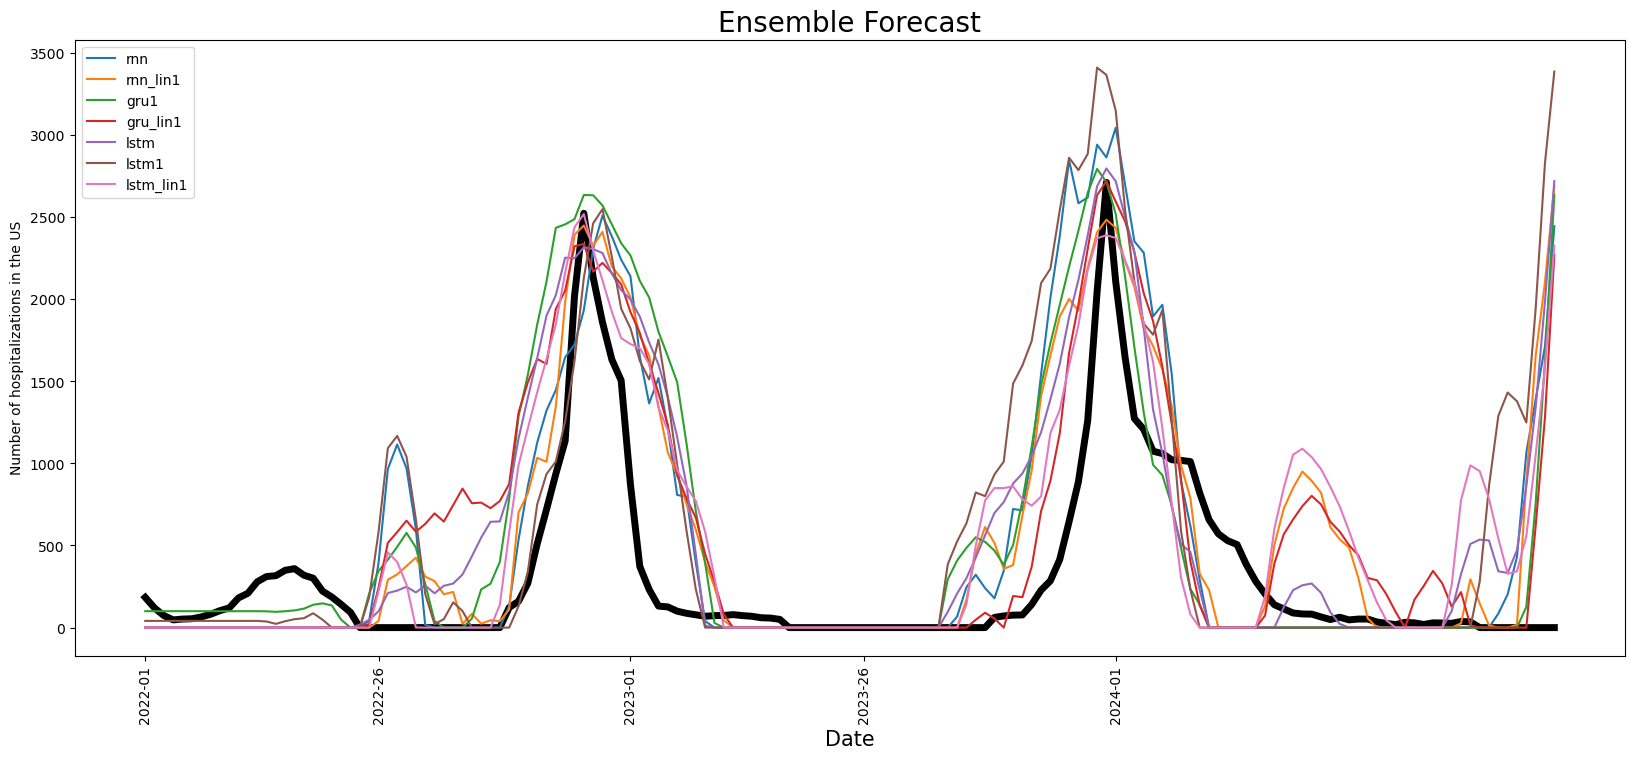

In [332]:
# plot all models
plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batched_sequence = data_in
start_date = '2022-01'
plt.plot(max_*plot_df["INF_ALL"].loc[start_date:],linewidth=5,color='black')
for model in model_list:
   #model = model.to(device)
    print(model.__class__.__name__)

    MODEL_PATH = 'C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'
    pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

    
    plot_df[model.__class__.__name__] = pred

    plt.rcParams['figure.figsize'] = (20, 8)

    
    #plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
  #  plt.plot(max_*plot_df[model.__class__.__name__].loc['2013-01':'2022-27'],linestyle="dashed")#,label=model.__class__.__name__+'(included)')
    plt.plot(max_*plot_df[model.__class__.__name__].loc[start_date:],label=model.__class__.__name__)#label=model.__class__.__name__+'(prediction)',linewidth=1)
    plt.legend(loc='upper left')
    x_ticks=['2022-01','2022-26','2023-01','2023-26','2024-01']



    plt.xticks(ticks = x_ticks,rotation=90)
    plt.title('Ensemble Forecast',size =20)
    plt.ylabel('Number of hospitalizations in the US')
    plt.xlabel('Date',size=15)

In [333]:
plot_df.loc['2022-14':'2022-40']= np.zeros(shape=(len(plot_df.loc['2022-14':'2022-40'] ),8))
plot_df.loc['2023-14':'2023-40']= np.zeros(shape=(len(plot_df.loc['2023-14':'2023-40'] ),8))
#plot_df = plot_df.drop('INF_ALL',axis=1)

Text(0.5, 0, 'Date')

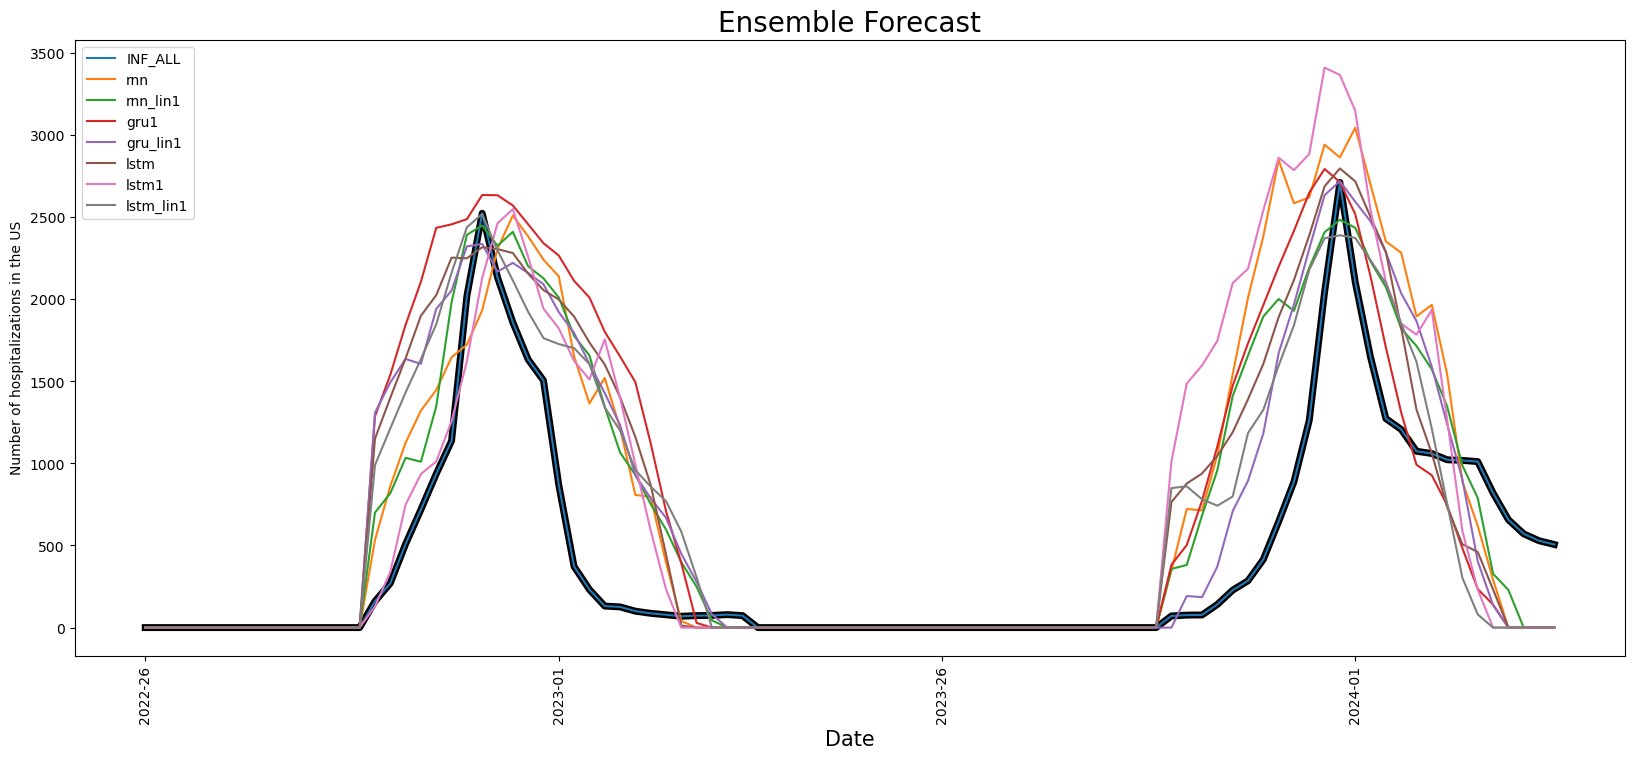

In [334]:
# plot all models

start_date = '2022-26'
end_date = '2024-14'
plt.plot(max_*plot_df["INF_ALL"].loc[start_date:end_date],linewidth=5,color='black')
for col in plot_df.columns:
   

    plt.rcParams['figure.figsize'] = (20, 8)
    plt.plot(max_*plot_df[col].loc[start_date:end_date],label=col)
    
plt.legend(loc='upper left')
x_ticks=['2022-26','2023-01','2023-26','2024-01']
plt.xticks(ticks = x_ticks,rotation=90)
plt.title('Ensemble Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US')
plt.xlabel('Date',size=15)

In [152]:
def make_lorenzian_params(window1,window2,pred_df):

    maxs, maxs_loc, half_width_list, width_list = [],[],[],[]
    for col in list(pred_df.columns):

        max_ = pred_df[col].loc[window1:window2].max()
        id_max_ = pred_df[col].loc[window1:window2].idxmax()

        maxs.append(max_)
        maxs_loc.append(id_max_)

        half_max = 0.5 * max_

        for id in list(pred_df.loc[window1:id_max_].index):
            
            if pred_df[col].loc[id] > half_max:

                id_half = id
                break

        for id in list(pred_df.loc[id_max_:window2].index):
            
            if pred_df[col].loc[id] < half_max:

                id_sec_half = id
                break

        half_width = len(pred_df.loc[id_half:id_max_])
        width = len(pred_df.loc[id_half:id_sec_half])
        half_width_list.append(half_width)
        width_list.append(width)

    curve_params = pd.DataFrame(data=zip(maxs,maxs_loc,half_width_list,width_list),columns = ['max','max_loc','half_width','width'],index=list(pred_df.columns))
    return curve_params

In [153]:
def lorentzian(max_,gamma,x0,x):
    func_ = (1/np.pi) * (0.5*gamma) / ( (x-x0)**2 + (0.5*gamma)**2)
    weight = max_ * np.pi * gamma/2
    func_*=weight
    return func_ 

In [154]:
def make_lorenzian_df(pred_df,window1,window2,curve_params,two_bool):

    max_val = curve_params['max'].mean()
    curve_params['max_loc_adj'] = curve_params['max_loc'].apply(lambda x: int(x.split('-')[1]) if int(x.split('-')[1]) > 10 else int(x.split('-')[1])+52)

    loc = curve_params['max_loc_adj'].mean()
    loc_std = curve_params['max_loc_adj'].std()

    # assuming models get the width wrong by a factor of 2

    #gamma = 9.8
    gamma = curve_params['half_width'].mean()

    if two_bool == True:

        gamma*=2


    # pred_df hard coded in here is bad practice but whatever

    index_tmp = list(pred_df.loc[window1:window2].index)

    lor = lorentzian(max_val,gamma,loc,np.arange(int(window1.split('-')[1]),int(window1.split('-')[1])+len(index_tmp),1))

    return pd.DataFrame(data = lor,columns = ['smooth'],index=index_tmp)

In [155]:
pred_df = plot_df.copy()

In [156]:
window1, window2 = '2022-30','2023-17'
curve_params = make_lorenzian_params(window1,window2,pred_df)
curve_params = curve_params.drop(['INF_ALL'],axis=0)
lor_223 = make_lorenzian_df(pred_df,window1,window2,curve_params,False)

window1, window2 = '2023-30','2024-17'
curve_params = make_lorenzian_params(window1,window2,pred_df)
curve_params = curve_params.drop(['INF_ALL'],axis=0)
lor_234 = make_lorenzian_df(pred_df,window1,window2,curve_params,False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Date')

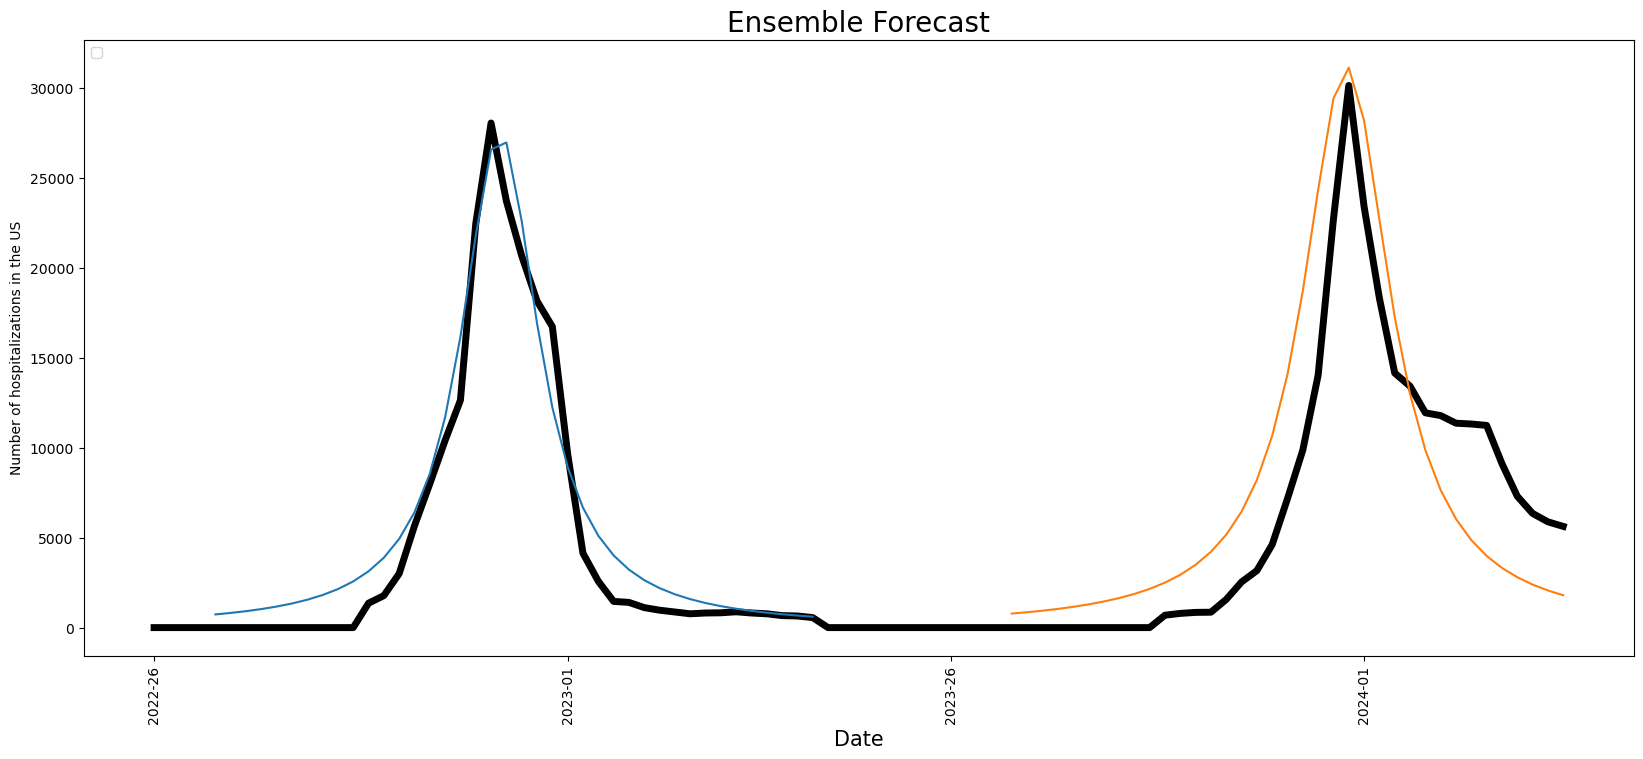

In [158]:
# plot all models

start_date = '2022-26'
end_date = '2024-14'
plt.plot(max_*plot_df["INF_ALL"].loc[start_date:end_date],linewidth=5,color='black')
plt.rcParams['figure.figsize'] = (20, 8)

plt.plot(max_*lor_223.loc[start_date:end_date])#,label=col)
plt.plot(max_*lor_234.loc[start_date:end_date])#,label=col)

    
plt.legend(loc='upper left')
x_ticks=['2022-26','2023-01','2023-26','2024-01']
plt.xticks(ticks = x_ticks,rotation=90)
plt.title('Ensemble Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US')
plt.xlabel('Date',size=15)

In [159]:
def make_many_lorenzian_df(pred_df,window1,window2,curve_params,two_bool):

    max_val = curve_params['max'].mean()
    max_val_std = curve_params['max'].std()
    loc = curve_params['max_loc_adj'].mean()
    loc_std = curve_params['max_loc_adj'].std()
    gamma = curve_params['half_width'].mean()
    gamma_std = curve_params['half_width'].std()

    if two_bool == True:

        gamma*=2
    
    index_tmp = list(pred_df.loc[window1:window2].index)
    output_df = pd.DataFrame(index=index_tmp)
    for i in range(100):
        max_r = np.random.normal(max_val,max_val_std)
        loc_r = np.random.normal(loc,loc_std)
        gamma_r = np.random.normal(gamma,gamma_std)
        lor = lorentzian(max_r,gamma_r,loc_r,np.arange(int(window1.split('-')[1]),int(window1.split('-')[1])+len(index_tmp),1))
        output_df[i] = lor
    mean_ = output_df.T.mean().T
    std_ = output_df.T.std().T
    output_df = pd.DataFrame(data = mean_,columns = ['Mean'],index=index_tmp)
    output_df['plus'] = output_df['Mean'] + std_
    output_df['minus'] = output_df['Mean'] - std_
    return output_df

In [163]:
window1, window2 = '2022-30','2023-17'
curve_params = make_lorenzian_params(window1,window2,pred_df)
curve_params = curve_params.drop(['INF_ALL'],axis=0)
lor_223 = make_lorenzian_df(pred_df,window1,window2,curve_params,False)
lor_err_223 = make_many_lorenzian_df(pred_df,window1,window2,curve_params,False)

window1, window2 = '2023-30','2024-17'
curve_params = make_lorenzian_params(window1,window2,pred_df)
curve_params = curve_params.drop(['INF_ALL'],axis=0)
lor_234 = make_lorenzian_df(pred_df,window1,window2,curve_params,False)
lor_err_234 = make_many_lorenzian_df(pred_df,window1,window2,curve_params,False)

In [361]:
max_*lor_err_234['minus'].loc[start_date:end_date]

2023-30      45.513092
2023-31      49.883715
2023-32      54.909804
2023-33      60.727958
2023-34      67.511891
2023-35      75.485059
2023-36      84.938522
2023-37      96.256610
2023-38     109.954465
2023-39     126.733983
2023-40     147.568849
2023-41     173.836487
2023-42     207.527168
2023-43     251.582053
2023-44     310.448698
2023-45     391.000510
2023-46     504.033547
2023-47     666.491135
2023-48     903.571584
2023-49    1244.996134
2023-50    1698.037131
2023-51    2166.841805
2023-52    2350.326585
2024-01    2067.159245
2024-02    1595.025162
2024-03    1167.505927
2024-04     848.633319
2024-05     627.214894
2024-06     475.357178
2024-07     369.680010
2024-08     294.340558
2024-09     239.221672
2024-10     197.897620
2024-11     166.224450
2024-12     141.468674
2024-13     121.782901
2024-14     105.888795
Name: minus, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Date')

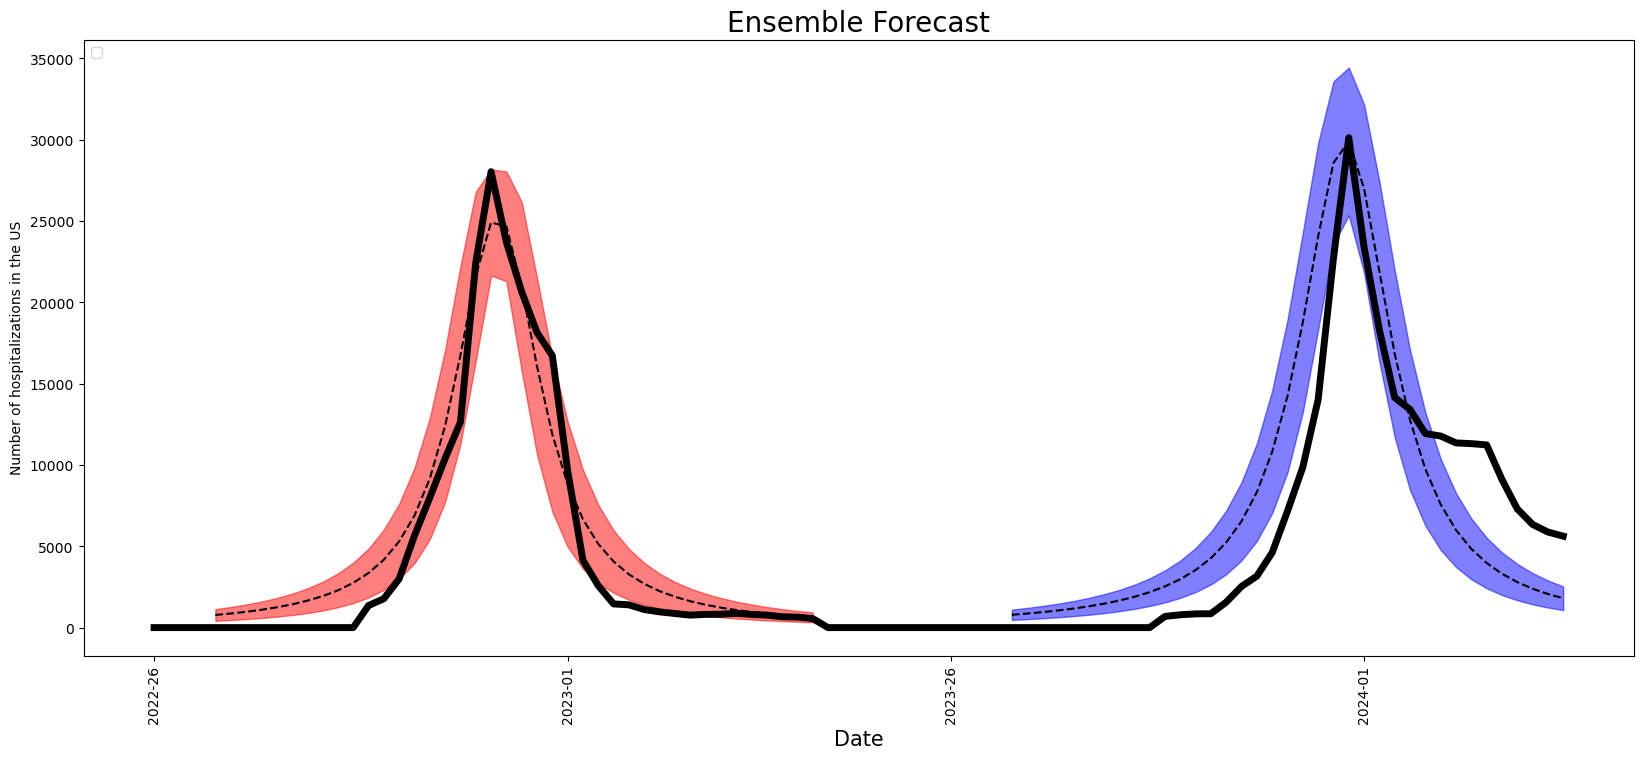

In [169]:
# plot all models

start_date = '2022-26'
end_date = '2024-14'
plt.plot(max_*plot_df["INF_ALL"].loc[start_date:end_date],linewidth=5,color='black')
plt.rcParams['figure.figsize'] = (20, 8)

#plt.plot(max_*lor_223.loc[start_date:end_date])
plt.plot(max_*lor_err_234['Mean'].loc[start_date:end_date],linestyle='dashed',color='black')
plt.plot(max_*lor_err_223['Mean'].loc[start_date:end_date],linestyle='dashed',color='black')

plt.fill_between(lor_err_223.loc[start_date:end_date].index,max_*lor_err_223['minus'].loc[start_date:end_date],max_*lor_err_223['plus'].loc[start_date:end_date],color='red',alpha=0.5)

plt.fill_between(lor_err_234.loc[start_date:end_date].index,max_*lor_err_234['minus'].loc[start_date:end_date],max_*lor_err_234['plus'].loc[start_date:end_date],color='blue',alpha=0.5)

    
plt.legend(loc='upper left')
x_ticks=['2022-26','2023-01','2023-26','2024-01']
plt.xticks(ticks = x_ticks,rotation=90)
plt.title('Ensemble Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US')
plt.xlabel('Date',size=15)

## 23-24

In [170]:
index_old = list(usa_infall_norm.index)
index_old[-1]

'2024-48'

In [171]:
index_new = []
start_date = index_old[-1]

yr = int(start_date[:4])
day = int(start_date[-2:])
for i in range(21):
    if day == 52:
        day = 1
        yr +=1
    else:
        day+=1
    if day < 10:
        day_str = '0'+str(day)
    else:
        day_str = str(day)
    new_date = str(yr)+'-'+day_str
    index_new.append(new_date)
index_new = index_old[21:] + index_new

In [172]:
model_names = []
for model in model_list:
    model_names.append(model.__class__.__name__)

In [173]:
batched_sequence =  Dataset_(df["INF_ALL"],df.drop(['INF_ALL','season'],axis=1),26,26)

(777,)


In [174]:
predictions = []
for i in range(len(model_list)):

    model = model_list[i].to(device)
    MODEL_PATH ='C:\\Users\\christopher.johnson\\Documents\\'+model.__class__.__name__+'_new_22-23_val.pth'

    pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)
    print(pred.shape)
    predictions.append(pred[:,0])

#so_cos = list(df_norm.columns)
#for i in range(len(so_cos)):
#    predictions.append(df_norm[so_cos[i]].shift(-21).to_numpy())
predictions = np.array(predictions)

pred_new_df = pd.DataFrame(data=predictions.T, columns = model_names,index = index_new)
#pred_new_df = pred_df.join(df_norm,on=pred_df.index)

(777, 1)
(777, 1)
(777, 1)
(777, 1)
(777, 1)
(777, 1)
(777, 1)


<AxesSubplot:>

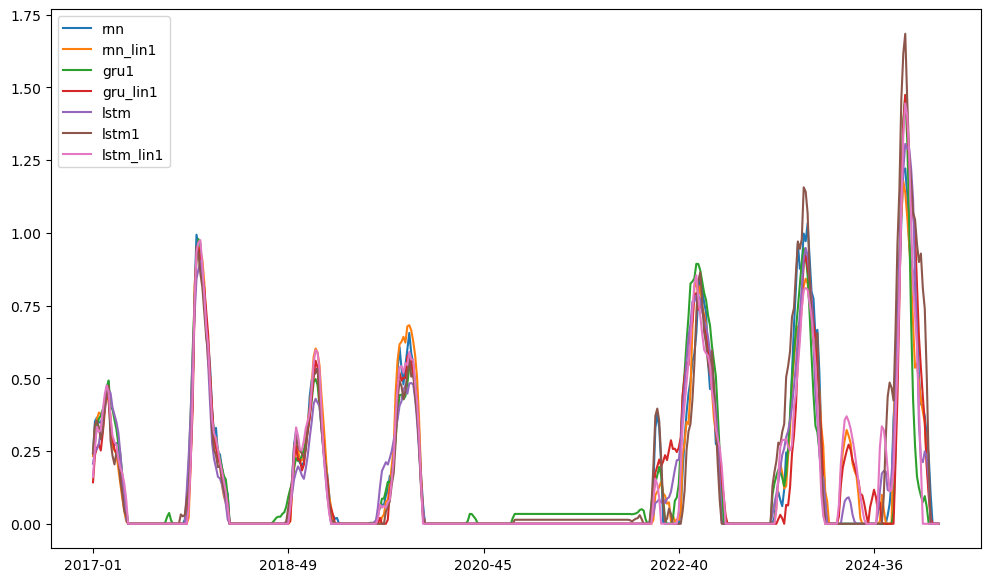

In [457]:
pred_new_df.loc['2017-01':].plot(kind='line')

In [175]:
window1, window2 = '2024-30','2025-17'
curve_params = make_lorenzian_params(window1,window2,pred_new_df)
lor_245 = make_lorenzian_df(pred_new_df,window1,window2,curve_params,False)
lor_err_245 = make_many_lorenzian_df(pred_new_df,window1,window2,curve_params,False)

Text(0, 0.5, 'Number of hospitalizations in the US')

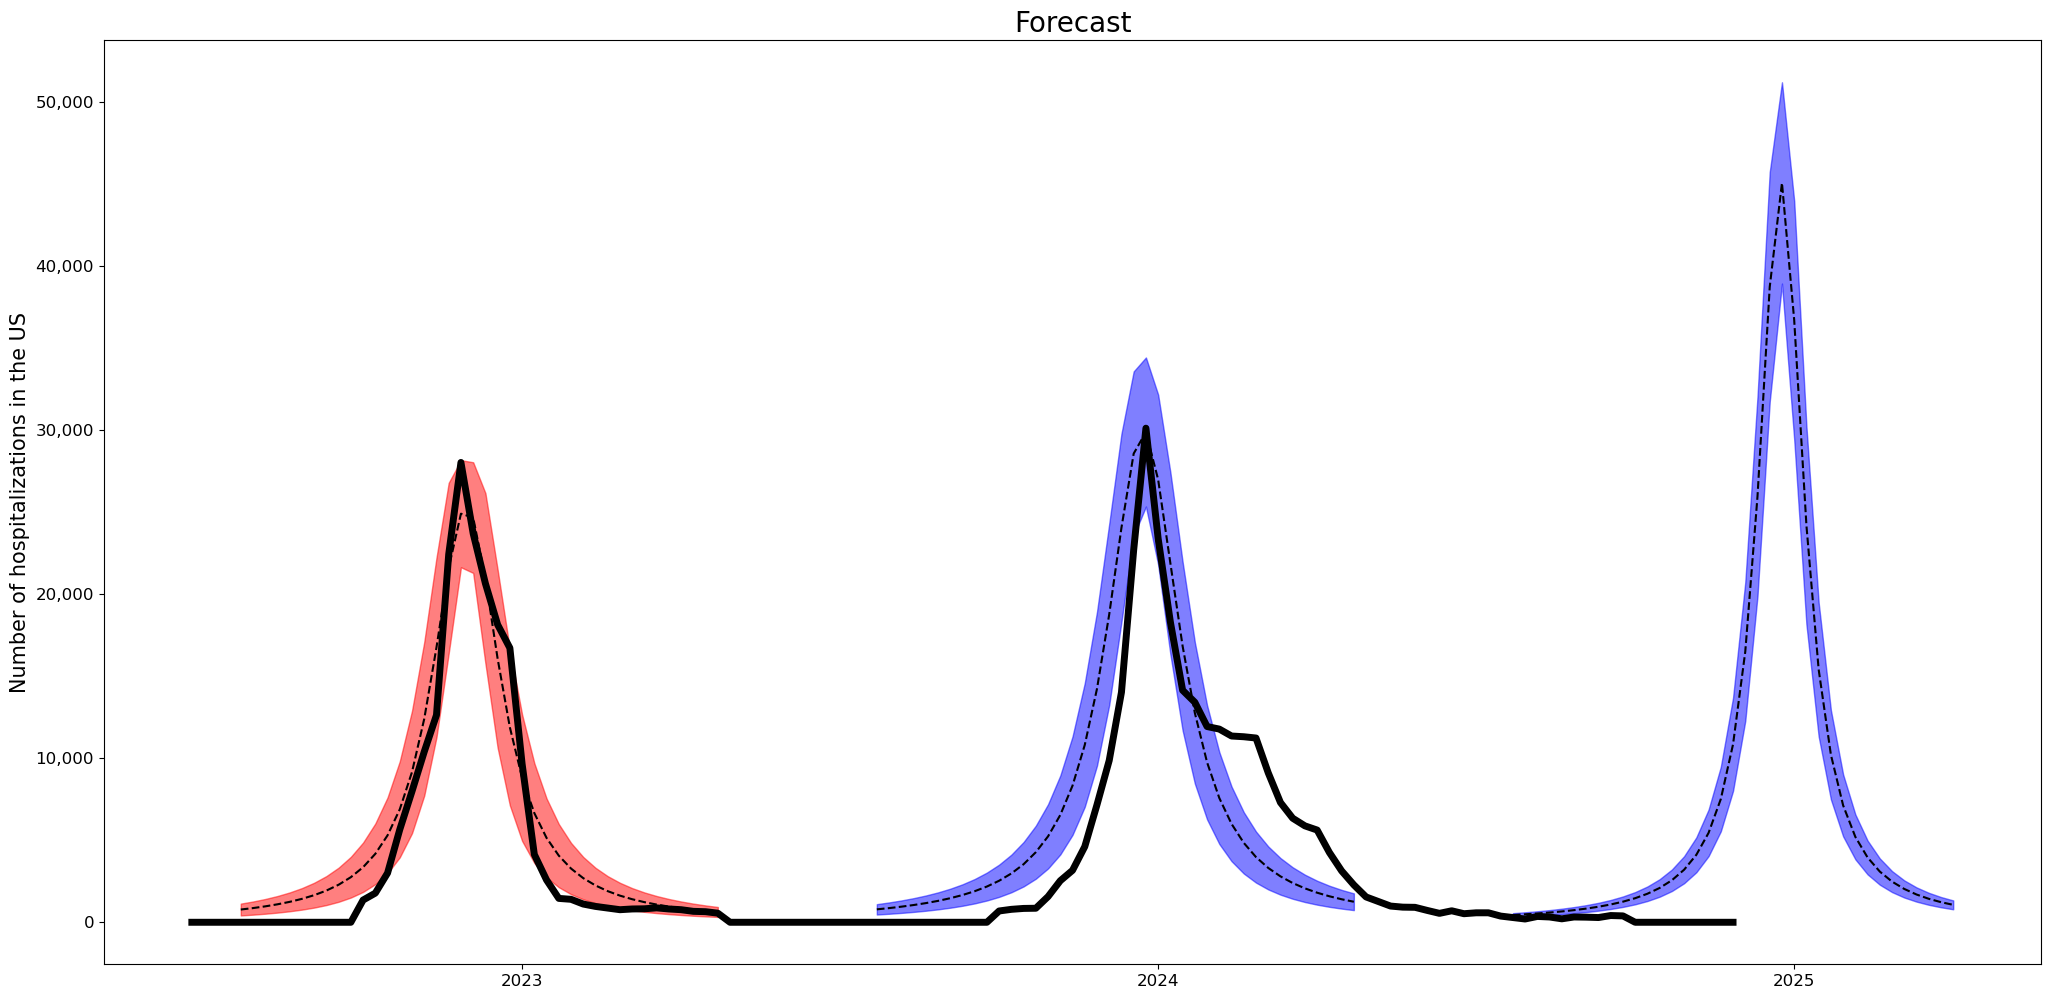

In [179]:
# plot all models
fig, ax = plt.subplots(figsize=(25,12))
start_date = '2022-26'
end_date = '2025-14'
ax.plot(max_*plot_df["INF_ALL"].loc[start_date:end_date],linewidth=5,color='black')
#plt.rcParams['figure.figsize'] = (20, 8)

#plt.plot(max_*lor_223.loc[start_date:end_date])
ax.plot(max_*lor_err_234['Mean'].loc[start_date:end_date],linestyle='dashed',color='black')
ax.plot(max_*lor_err_245['Mean'].loc[start_date:end_date],linestyle='dashed',color='black')
ax.plot(max_*lor_err_223['Mean'].loc[start_date:end_date],linestyle='dashed',color='black')

ax.fill_between(lor_err_245.loc[start_date:end_date].index,max_*lor_err_245['minus'].loc[start_date:end_date],max_*lor_err_245['plus'].loc[start_date:end_date],color='blue',alpha=0.5)

ax.fill_between(lor_err_234.loc[start_date:end_date].index,max_*lor_err_234['minus'].loc[start_date:end_date],max_*lor_err_234['plus'].loc[start_date:end_date],color='blue',alpha=0.5)

ax.fill_between(lor_err_223.loc[start_date:end_date].index,max_*lor_err_223['minus'].loc[start_date:end_date],max_*lor_err_223['plus'].loc[start_date:end_date],color='red',alpha=0.5)


ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='y', labelsize=12)
#plt.legend(loc='upper left')
x_ticks=['2023-01','2024-01','2025-01']
labels = ['2023','2024','2025']
ax.set_xticks(ticks = x_ticks,labels=labels,size=12)
ax.set_title('Forecasts',size =20)
ax.set_ylabel('Number of hospitalizations in the US',fontsize=15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Date')

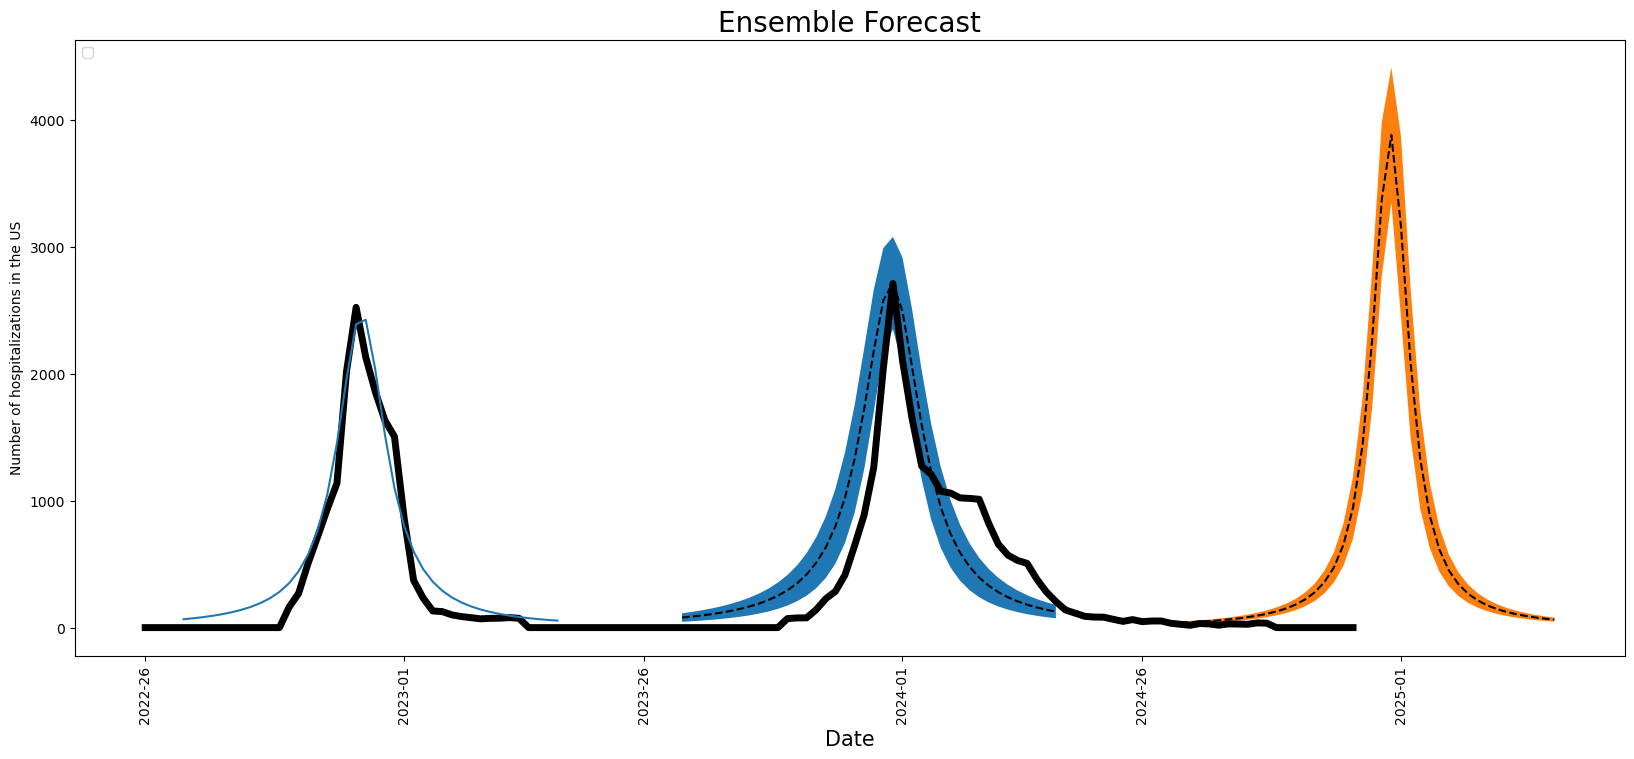

In [470]:
# plot all models

start_date = '2022-26'
end_date = '2025-37'
plt.plot(max_*plot_df["INF_ALL"].loc[start_date:end_date],linewidth=5,color='black')
plt.rcParams['figure.figsize'] = (20, 8)

plt.plot(max_*lor_223.loc[start_date:end_date])
plt.plot(max_*lor_err_234['Mean'].loc[start_date:end_date],linestyle='dashed',color='black')
plt.fill_between(lor_err_234.loc[start_date:end_date].index,max_*lor_err_234['minus'].loc[start_date:end_date],max_*lor_err_234['plus'].loc[start_date:end_date])

plt.plot(max_*lor_err_245['Mean'].loc[start_date:end_date],linestyle='dashed',color='black')
plt.fill_between(lor_err_245.loc[start_date:end_date].index,max_*lor_err_245['minus'].loc[start_date:end_date],max_*lor_err_245['plus'].loc[start_date:end_date])

    
plt.legend(loc='upper left')
x_ticks=['2022-26','2023-01','2023-26','2024-01','2024-26','2025-01']
plt.xticks(ticks = x_ticks,rotation=90)
plt.title('Ensemble Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US')
plt.xlabel('Date',size=15)